# Аналитика в Яндекс.Афише.

## ОГЛАВЛЕНИЕ

1. [Описание проекта](#projekt) 
2. [Цель и задачи проекта](#purpose)     
3. [Описание данных](#data)    
4. [Открытие данных и изучение общей информации](#start)
5. [Подготовка данных](#preparation)   
6. [Анализ данных](#analysis)    
  6.1. [Продуктовые метрики](#product)   
  6.2. [Торговые метрики](#trading)   
  6.3. [Маркетинговые метрики](#marketing)
7. [Общий вывод](#conclusion)
8. [Рекомендации](#recommendations)

### Описание проекта
<a name="projekt"></a>

Необходимо оптимизировать маркетинговые затраты Яндекс.Афиши. В распоряжении есть данные с июня 2017 по конец мая 2018 года:  
- лог сервера с данными о посещениях сайта Яндекс.Афиши;  
- выгрузка всех заказов за этот период;  
- статистика рекламных расходов.

### Цель и задачи проекта
<a name="purpose"></a>

Цель проекта - изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда клиент окупается.     
<br>Для этого необходимо построить отчёты и посчитать метрики:  
1. по продукту:  
  - сколько людей пользуются в день, неделю, месяц?  
  - сколько сессий в день?  
  - сколько длится одна сессия?  
  - как часто люди возвращаются?  
2. по продажам:  
  - когда люди начинают покупать?  
  - сколько раз покупают за период?  
  - какой средний чек?  
  - сколько денег приносят (LTV)?    
3. по маркетингу:  
  - сколько денег потратили (всего / на каждый источник / по времени)?   
  - сколько стоило привлечение одного покупателя из каждого источника?  
  - на сколько окупились расходы (ROI)? 

### Описание данных
<a name="data"></a>

#### Таблица visits (лог сервера с информацией о посещениях сайта)

- Uid — уникальный идентификатор пользователя  
- Device — категория устройства пользователя  
- Start Ts — дата и время начала сессии  
- End Ts — дата и время окончания сессии  
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

#### Таблица orders (информация о заказах)

- Uid — уникальный id пользователя, который сделал заказ  
- Buy Ts — дата и время заказа  
- Revenue — выручка Яндекс.Афиши с этого заказа

#### Таблица costs (информация о затратах на маркетинг)

- source_id — идентификатор рекламного источника  
- dt — дата  
- costs — затраты на этот рекламный источник в этот день

### Открытие данных и изучение общей информации
<a name="start"></a>

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline         
plt.rcParams.update({'font.size': 16})
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
from pylab import rcParams
rcParams['figure.figsize'] = 18, 9

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

#### Таблица visits (лог сервера с информацией о посещениях сайта)

In [4]:
# прочитаем DataFrame
try:
    visits = pd.read_csv('visits_log.csv')  # локальный путь
except:
    visits = pd.read_csv('/datasets/visits_log.csv')  # путь на сервере

In [5]:
# выведем на экран 10 случайных строк таблицы
visits.sample(10)

Device               End Ts  Source Id             Start Ts  \
91497   desktop  2017-10-09 20:31:00          9  2017-10-09 20:31:00   
91055   desktop  2017-09-23 15:53:00          2  2017-09-23 15:48:00   
30528   desktop  2017-12-11 16:25:00          9  2017-12-11 15:55:00   
223911  desktop  2017-10-20 15:16:00          3  2017-10-20 15:10:00   
58416   desktop  2017-12-11 23:30:00          3  2017-12-11 23:16:00   
327644  desktop  2018-04-25 19:39:00          1  2018-04-25 18:43:00   
333153    touch  2017-10-11 23:28:00          3  2017-10-11 23:14:00   
22774   desktop  2017-07-12 10:48:00          4  2017-07-12 10:44:00   
303176    touch  2018-01-27 22:54:00          3  2018-01-27 22:50:00   
334100  desktop  2017-11-29 13:24:00          2  2017-11-29 13:00:00   

                         Uid  
91497    4024705693529557615  
91055    8673890496628921255  
30528     452420286655108338  
223911   2218097342220238791  
58416     700046770807416490  
327644  10222628295252157810  
333153  17075794370632945313  
22774   18147454979854072958  
303176   2705982283013641080  
334100  16895737306928828916

In [6]:
# посмотрим сводную информацию таблицы
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В таблице 359400 строк, 5 столбцов, тип данных у трёх столбцов строковый, у двух - целочисленный. В названии столбцов есть строчные буквы и пробелы. В столбцах `Start Ts`  и `End Ts` значения даты и времени начала и окончания сессии указаны не в формате `datetime`.

In [7]:
# посмотрим количество уникальных значений по столбцам таблицы
for column in visits.columns:
    print(column)
    print()
    print(visits[column].value_counts())
    print()        

Device

desktop    262567
touch       96833
Name: Device, dtype: int64

End Ts

2017-11-24 16:51:00    23
2017-11-24 16:52:00    21
2017-11-24 16:50:00    18
2017-11-24 16:46:00    15
2017-11-24 16:48:00    14
                       ..
2017-11-22 12:47:00     1
2017-11-08 20:52:00     1
2017-12-20 10:40:00     1
2017-08-15 22:56:00     1
2018-02-24 11:14:00     1
Name: End Ts, Length: 224760, dtype: int64

Source Id

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64

Start Ts

2017-11-24 16:06:00    19
2017-11-24 17:19:00    15
2017-11-24 17:21:00    15
2018-05-31 10:01:00    15
2017-11-24 15:57:00    14
                       ..
2018-03-30 01:05:00     1
2017-09-27 19:16:00     1
2018-03-23 17:31:00     1
2018-02-02 15:33:00     1
2017-08-28 08:12:00     1
Name: Start Ts, Length: 224303, dtype: int64

Uid

12869801667763685675    893
3263486045884611639     615
11255648391090536411    551


Пользователи посещали сайт с устройств двух категорий, пришли из 9 вариантов рекламных источников. За анализируемый период сайт посещало 228169 уникальных пользователей, количество посещений одним пользователем - от 1 до 893. 

In [8]:
# найдем долю посещений на различных категориях устройств
round(visits['Device'].value_counts(normalize = True) * 100, 1)

desktop   73.10
touch     26.90
Name: Device, dtype: float64

73,1% посещений произведено со стационарных устройств, 26,9% - с мобильных.

In [9]:
# определим период информации в таблице
(visits['Start Ts'].min(), visits['Start Ts'].max())

('2017-06-01 00:01:00', '2018-05-31 23:59:00')

В таблице содержится информация за период с 01.06.2017 по 31.05.2018.

In [10]:
# определим долю строк, где время начала сессии совпадает со временем ее окончания
round(len(visits.loc[visits['End Ts'] == visits['Start Ts']]) / len(visits) * 100, 1) 

10.0

В 10% строк таблицы время начала сессии совпадает со временем ее окончания. Так как время в таблице указано с округлением до минут, вероятнее всего пользовательская сессия в этих случаях продлилась не более минуты.

In [11]:
# найдем строки, где время начала сессии позже времени ее окончания
visits.loc[visits['End Ts'] < visits['Start Ts']]

Device               End Ts  Source Id             Start Ts  \
4181    desktop  2018-03-25 03:18:00          3  2018-03-25 03:50:00   
177972  desktop  2018-03-25 03:09:00          9  2018-03-25 03:55:00   

                         Uid  
4181    13092152539246794986  
177972   4621202742905035453

Имеется две строки, в которых время начала сессии позже времени ее окончания. Вероятнее всего это сбой при выгрузке данных.

In [12]:
# найдем долю посещений из различных рекламных источников
round(visits['Source Id'].value_counts(normalize = True) * 100, 1)

4    28.30
3    23.80
5    18.60
2    13.30
1     9.50
9     3.70
10    2.80
7     0.00
6     0.00
Name: Source Id, dtype: float64

Самый популярный - четвертый рекламный источник, из которого пришло 28,3% пользователей.

In [13]:
# определим количество пропущенных значений в таблице
visits.isnull().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

Пропущенные значения отсутствуют.

In [14]:
# посчитаем количество дубликатов
visits.duplicated().sum()

0

Дубликаты отсутствуют.

#### Таблица orders (информация о заказах)

In [15]:
# прочитаем DataFrame
try:
    orders = pd.read_csv('orders_log.csv')  # локальный путь
except:
    orders = pd.read_csv('/datasets/orders_log.csv')  # путь на сервере

In [16]:
# выведем на экран 10 случайных строк таблицы
orders.sample(10)

Buy Ts  Revenue                   Uid
2976   2017-07-10 15:57:00     9.78  10436457472806358878
31410  2018-01-28 00:47:00     0.61   8293490400197848676
41759  2018-03-25 13:31:00     0.49   4957878011336122372
25566  2017-12-23 13:05:00     1.22   6957872296030604485
32865  2018-02-04 11:47:00     1.22   7364949248371105092
1279   2017-06-12 02:04:00     2.63  11804975128514880569
19999  2017-11-25 13:13:00     2.93  11920452646463905188
44197  2018-04-15 19:36:00     2.44   4329169423564702693
37645  2018-03-01 21:38:00     0.92   1836987794034274678
44806  2018-04-20 14:14:00     2.80  15415872313363693874

In [17]:
# посмотрим сводную информацию таблицы
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В таблице 50415 строк, 3 столбца, тип данных у одного столбца строковый, у одного - целочисленный, у одного - вещественный. В названии столбцов есть строчные буквы и пробелы. В столбце `Buy Ts` значения даты и времени заказа указаны не в формате `datetime`.

In [18]:
# проведем базовую проверку столбца с выручкой 
orders['Revenue'].describe()

count   50,415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max      2,633.28
Name: Revenue, dtype: float64

В среднем выручка от одного заказа составляет около 5 рублей, более 75% заказов приносят выручку ниже средней, максимальная выручка от одного заказа - 2633,28 рубля.

In [19]:
# посмотрим на строки таблицы с выручкой более 1000 рублей
orders.query('Revenue > 1000')

Buy Ts  Revenue                   Uid
23165  2017-12-10 13:04:00 1,195.64   5539673724080479777
23244  2017-12-10 20:17:00 2,633.28   5539673724080479777
24607  2017-12-17 18:06:00 1,109.10  11149926373378902217
36522  2018-02-23 08:54:00 1,236.28  11149926373378902217
36682  2018-02-24 09:25:00 1,221.37  11149926373378902217
40386  2018-03-18 09:13:00 1,073.11  11149926373378902217
47507  2018-05-16 19:53:00 1,080.44  11149926373378902217

Было совершено 7 крупных покупок стоимостью более 1000 рублей каждая, эти покупки были совершены двумя покупателями. 3 таких покупки были совершены в декабре 2017 года, 2 - в феврале 2018 года. Вероятнее всего это корпоративные клиенты, покупавшие билеты для своих работников, либо перекупщики билетов, решившие заработать на наиболее популярных мероприятиях. 

In [20]:
# посмотрим количество уникальных значений по столбцам таблицы
for column in orders.columns:
    print(column)
    print()
    print(orders[column].value_counts())
    print()        

Buy Ts

2018-05-31 10:13:00    9
2017-11-24 17:42:00    8
2017-11-24 17:36:00    7
2018-05-31 10:27:00    7
2018-05-31 10:02:00    7
                      ..
2017-10-06 17:11:00    1
2018-04-20 23:29:00    1
2017-12-26 08:44:00    1
2018-05-17 14:35:00    1
2018-02-11 23:10:00    1
Name: Buy Ts, Length: 45991, dtype: int64

Revenue

1.83        2552
2.44        2464
3.67        2421
1.22        2216
3.05        2041
            ... 
7.56           1
7.55           1
1,236.28       1
14.27          1
107.55         1
Name: Revenue, Length: 1149, dtype: int64

Uid

3644482766749211722     239
13888745432979765063    238
11920452646463905188    227
6731421022966725351     183
5139615590553126732     150
                       ... 
10123118655365033769      1
17398492294358629398      1
15974676665349104064      1
16705253310465048548      1
9505264890679494151       1
Name: Uid, Length: 36523, dtype: int64



За анализируемый период заказы осуществило 36523 уникальных пользователя, количество заказов одного пользователя - от 1 до 239.  

In [21]:
# определим период информации в таблице
(orders['Buy Ts'].min(), orders['Buy Ts'].max())

('2017-06-01 00:10:00', '2018-06-01 00:02:00')

В таблице содержится информация за период с 01.06.2017 по 01.06.2018. Рассмотрим строки с информацией вне анализируемого периода.

In [22]:
# найдем строки таблицы с заказами с информацией вне анализируемого периода
orders[orders['Buy Ts'] >= '2018-06-01 00:00:00']

Buy Ts  Revenue                Uid
50414  2018-06-01 00:02:00     3.42  83872787173869366

Имеется одна строка с оплатой заказа вне анализируемого периода. Найдем все посещения сайта данным пользователем.

In [23]:
# найдем строки таблицы с посещениями с информацией вне анализируемого периода
visits.query('Uid == "83872787173869366"')

Device               End Ts  Source Id             Start Ts  \
299620  desktop  2018-06-01 00:04:00          4  2018-05-31 23:59:00   

                      Uid  
299620  83872787173869366

Сессия началась 31.05.2018 в 23:59:00, вся ее продолжительность пришлась на дату вне анализируемого периода.

In [24]:
# посчитаем количество строк таблицы с нулевой выручкой
len(orders.query('Revenue == 0'))

51

Имеется 51 значение с нулевой выручкой от заказа (вероятнее всего реализованы либо акционные, либо льготные билеты).

In [25]:
# определим количество пропущенных значений в таблице
orders.isnull().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

Пропущенные значения отсутствуют.

In [26]:
# посчитаем количество дубликатов
orders.duplicated().sum()

0

Дубликаты отсутствуют.

#### Таблица costs (информация о затратах на маркетинг)

In [27]:
# прочитаем DataFrame
try:
    costs = pd.read_csv('costs.csv')  # локальный путь
except:
    costs = pd.read_csv('/datasets/costs.csv')  # путь на сервере

In [28]:
# выведем на экран 10 случайных строк таблицы
costs.sample(10)

source_id          dt  costs
2014          9  2017-12-16  20.42
111           1  2017-09-20  75.74
1459          5  2017-06-08 156.32
2360         10  2017-11-29  18.28
1255          4  2017-11-14  57.03
2531         10  2018-05-21  13.76
1735          5  2018-03-11 100.82
175           1  2017-11-23 112.96
1854          9  2017-07-09   5.18
7             1  2017-06-08  56.63

In [29]:
# посмотрим сводную информацию таблицы
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В таблице 2542 строки, 3 столбца, тип данных у одного столбца строковый, у одного - целочисленный, у одного - вещественный.  В столбце `dt` значения даты осуществления рекламных затрат указаны не в формате `datetime`. 

In [30]:
# проведем базовую проверку столбца с затратами
costs['costs'].describe()

count   2,542.00
mean      129.48
std       156.30
min         0.54
25%        21.95
50%        77.30
75%       170.06
max     1,788.28
Name: costs, dtype: float64

В среднем ежедневные рекламные затраты на один источник составляют около 129 рублей, максимальные ежедневные затраты на один источник - 1788,28 рублей, минимальные - 0,54 рубля. 

In [31]:
# посмотрим количество уникальных значений по столбцам таблицы
for column in costs.columns:
    print(column)
    print()
    print(costs[column].value_counts())
    print()        

source_id

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

dt

2018-01-15    7
2018-02-12    7
2018-03-03    7
2018-03-25    7
2018-02-10    7
             ..
2017-08-18    7
2017-11-24    7
2017-09-09    7
2017-11-23    7
2018-03-31    1
Name: dt, Length: 364, dtype: int64

costs

16.25     3
50.77     3
12.87     3
6.35      3
16.81     3
         ..
193.39    1
13.68     1
91.65     1
45.10     1
62.25     1
Name: costs, Length: 2396, dtype: int64



Всего затраты осуществлялись на 7 рекламных источников. На все рекламные источники траты осуществлялись ежедневно за исключением 31.03.2018, когда затраты были произведены только на пятый рекламный источник. Не осуществлялись затраты на шестой и седьмой рекламные источники, из которых пришли пользователи, осуществившие соответственно 6 и 36 посещений сайта. 

In [32]:
# определим период информации в таблице
(costs['dt'].min(), costs['dt'].max())

('2017-06-01', '2018-05-31')

В таблице содержится информация за период с 01.06.2017 по 31.05.2018.

In [33]:
# определим количество пропущенных значений в таблице
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

Пропущенные значения отсутствуют.

In [34]:
# посчитаем количество дубликатов
costs.duplicated().sum()

0

Дубликаты отсутствуют.

### Вывод

При изучении таблиц с данными установлено следующее:

1. Таблица `visits` (лог сервера с информацией о посещениях сайта):  
  - в таблице 359400 строк, 5 столбцов, пропущенные значения и дубликаты отсутствуют;   
  - тип данных у трёх столбцов строковый, у двух - целочисленный;    
  - в таблице содержится информация за период с 01.06.2017 по 31.05.2018;  
  - пользователи посещали сайт с устройств двух категорий: 73,1% посещений произведено со стационарных устройств, 26,9% - с мобильных;      
  - пользователи пришли из 9 вариантов рекламных источников, самый популярный - четвертый рекламный источник, из которого пришло 28,3% пользователей;  
  - за анализируемый период сайт посетило 228169 уникальных пользователей, количество посещений одним пользователем - от 1 до 893;  
  - в названии столбцов есть строчные буквы и пробелы;
  - в столбцах `Start Ts`  и `End Ts` значения даты и времени начала и окончания сессии указаны не в формате `datetime`;   
  - в 10% строк таблицы время начала сессии совпадает со временем ее окончания, вероятнее всего пользовательская сессия в этих случаях продлилась не более минуты;   
  - имеется две строки, в которых время начала сессии позже времени ее окончания, вероятнее всего это сбой при выгрузке данных.  
2. Таблица `orders` (информация о заказах):
  - в таблице 50415 строк, 3 столбца, пропущенные значения и дубликаты отсутствуют;   
  - тип данных у одного столбца строковый, у одного - целочисленный, у одного - вещественный;  
  - в таблице содержится информация за период с 01.06.2017 по 01.06.2018, имеется одна строка с информацией вне анализируемого периода;  
  - в среднем выручка от одного заказа составляет около 5 рублей, более 75% заказов приносят выручку ниже средней, максимальная выручка от одного заказа - 2633,28 рубля;  
  - было совершено 7 крупных покупок стоимостью более 1000 рублей каждая, эти покупки были совершены двумя покупателями. 3 таких покупки были совершены в декабре 2017 года, 2 - в феврале 2018 года (вероятнее всего это корпоративные клиенты, покупавшие билеты для своих работников, либо перекупщики билетов, решившие заработать на наиболее популярных мероприятиях);   
  - имеется 51 значение с нулевой выручкой от заказа (вероятнее всего реализованы либо акционные, либо льготные билеты);   
  - за анализируемый период заказы осуществило 36523 уникальных пользователя, количество заказов одного пользователя - от 1 до 239;   
  - в названии столбцов есть строчные буквы и пробелы;
  - в столбце `Buy Ts` значения даты и времени заказа указаны не в формате `datetime`.  
3. Таблица `costs` (информация о затратах на маркетинг):
  - в таблице 2542 строки, 3 столбца, пропущенные значения и дубликаты отсутствуют;   
  - тип данных у одного столбца строковый, у одного - целочисленный, у одного - вещественный;  
  - в таблице содержится информация за период с 01.06.2017 по 31.05.2018;  
  - всего затраты осуществлялись на 7 рекламных источников;   
  - в среднем ежедневные рекламные затраты на один источник составляют около 129 рублей, максимальные ежедневные затраты на один источник - 1788,28 рублей, минимальные - 0,54 рубля;  
  - на все рекламные источники траты осуществлялись ежедневно за исключением 31.03.2018, когда затраты были произведены только на пятый рекламный источник;   
  - не производились затраты на шестой и седьмой рекламные источники, из которых пришли пользователи, осуществившие соответственно 6 и 36 посещений сайта;   
  - в столбце `dt` значения даты осуществления рекламных затрат указаны не в формате `datetime`.  

Проанализировав вышеизложенное, необходимо выполнить следующее:   
1. названия столбцов в таблицах `visits` и `orders` привести к нижнему регистру, из названий убрать пробелы;    
2. для удобства в дальнейшем исследовании поменять порядок столбцов во всех таблицах; 
3. значения даты и времени начала и окончания сессии в таблице `visits`, даты и времени заказа в таблице `orders`, даты осуществления рекламных затрат в таблице `costs` привести к формату `datetime`;  
4. поменять местами время начала и окончания сессии в двух строках таблицы `visits`;   
5. в таблицах `visits` и `orders` удалить строки с информацией вне анализируемого периода.

### Подготовка данных
<a name="preparation"></a>

#### Таблица visits (лог сервера с информацией о посещениях сайта)

In [35]:
# поменяем названия столбцов
visits.columns = ['device',
                  'session_end_ts',
                  'source_id',
                  'session_start_ts',
                  'uid']
visits.head()

device       session_end_ts  source_id     session_start_ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [36]:
# поменяем порядок столбцов
visits = visits[['uid',
                 'device',
                 'source_id',
                 'session_start_ts',
                 'session_end_ts']]
visits.head()

uid   device  source_id     session_start_ts  \
0  16879256277535980062    touch          4  2017-12-20 17:20:00   
1    104060357244891740  desktop          2  2018-02-19 16:53:00   
2   7459035603376831527    touch          5  2017-07-01 01:54:00   
3  16174680259334210214  desktop          9  2018-05-20 10:59:00   
4   9969694820036681168  desktop          3  2017-12-27 14:06:00   

        session_end_ts  
0  2017-12-20 17:38:00  
1  2018-02-19 17:21:00  
2  2017-07-01 01:54:00  
3  2018-05-20 11:23:00  
4  2017-12-27 14:06:00

In [37]:
# поменяем местами строки, где время начала сессии позже времени ее окончания
visits.loc[4181, ['session_start_ts', 'session_end_ts']]\
    = visits.loc[4181, ['session_end_ts', 'session_start_ts']].values
visits.loc[177972, ['session_start_ts', 'session_end_ts']]\
    = visits.loc[177972, ['session_end_ts', 'session_start_ts']].values
(visits.loc[4181, ['session_start_ts', 'session_end_ts']],
     visits.loc[177972, ['session_start_ts', 'session_end_ts']])

(session_start_ts    2018-03-25 03:18:00
 session_end_ts      2018-03-25 03:50:00
 Name: 4181, dtype: object,
 session_start_ts    2018-03-25 03:09:00
 session_end_ts      2018-03-25 03:55:00
 Name: 177972, dtype: object)

In [38]:
# удалим строку вне анализируемого периода
visits = visits.drop(index = 299620)\
               .reset_index(drop = True)
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359399 entries, 0 to 359398
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   uid               359399 non-null  uint64
 1   device            359399 non-null  object
 2   source_id         359399 non-null  int64 
 3   session_start_ts  359399 non-null  object
 4   session_end_ts    359399 non-null  object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [39]:
# приведем значения даты и времени начала и окончания сессии к формату "datetime"
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'],
                                            format = '%Y-%m-%d %H:%M:%S')
visits['session_end_ts'] = pd.to_datetime(visits['session_end_ts'],
                                          format = '%Y-%m-%d %H:%M:%S')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359399 entries, 0 to 359398
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   uid               359399 non-null  uint64        
 1   device            359399 non-null  object        
 2   source_id         359399 non-null  int64         
 3   session_start_ts  359399 non-null  datetime64[ns]
 4   session_end_ts    359399 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


#### Таблица orders (информация о заказах)

In [40]:
# поменяем названия столбцов
orders.columns = ['order_ts',
                  'revenue',
                  'uid']
orders.head()

order_ts  revenue                   uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

In [41]:
# поменяем порядок столбцов
orders = orders[['uid',
                 'revenue',
                 'order_ts']]
orders.head()

uid  revenue             order_ts
0  10329302124590727494    17.00  2017-06-01 00:10:00
1  11627257723692907447     0.55  2017-06-01 00:25:00
2  17903680561304213844     0.37  2017-06-01 00:27:00
3  16109239769442553005     0.55  2017-06-01 00:29:00
4  14200605875248379450     0.37  2017-06-01 07:58:00

In [42]:
# удалим строку вне анализируемого периода
orders = orders.drop(index = 50414)\
               .reset_index(drop = True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50414 entries, 0 to 50413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   uid       50414 non-null  uint64 
 1   revenue   50414 non-null  float64
 2   order_ts  50414 non-null  object 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [43]:
# приведем значения даты и времени заказа к формату "datetime"
orders['order_ts'] = pd.to_datetime(orders['order_ts'],
                                  format = '%Y-%m-%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50414 entries, 0 to 50413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   uid       50414 non-null  uint64        
 1   revenue   50414 non-null  float64       
 2   order_ts  50414 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


#### Таблица costs (информация о затратах на маркетинг)

In [44]:
# поменяем названия столбцов
costs.columns = ['source_id',
                 'date',
                 'costs']
costs.head()

source_id        date  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

In [45]:
# поменяем порядок столбцов
costs = costs[['source_id',
               'costs',
               'date']]
costs.head()

source_id  costs        date
0          1  75.20  2017-06-01
1          1  62.25  2017-06-02
2          1  36.53  2017-06-03
3          1  55.00  2017-06-04
4          1  57.08  2017-06-05

In [46]:
# приведем значения даты осуществления затрат к формату "datetime"
costs['date'] = pd.to_datetime(costs['date'],
                               format = '%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   costs      2542 non-null   float64       
 2   date       2542 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Вывод

В целях подготовки данных провели следующую работу:  
1. названия столбцов в таблицах `visits` и `orders` привели к нижнему регистру, из названий убрали пробелы;    
2. поменяли порядок столбцов во всех таблицах; 
3. значения даты и времени начала и окончания сессии в таблице `visits`, даты и времени заказа в таблице `orders`, даты осуществления затрат на маркетинг в таблице `costs` привели к формату `datetime`;   
4. поменяли местами время начала и окончания сессии в двух строках таблицы `visits`;   
5. в таблицах `visits` и `orders` удалили строки с информацией вне анализируемого периода.

### Анализ данных
<a name="analysis"></a>

#### Продуктовые метрики
<a name="product"></a>

##### Сколько людей пользуются в день, неделю, месяц?   

###### По всей совокупности 

In [47]:
# добавим в таблицу столбцы с годом, месяцем, неделей, днем недели и днем сессии
visits['session_year']  = visits['session_start_ts'].dt.year
visits['session_month'] = visits['session_start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['session_start_ts'].astype('datetime64[W]')
visits['session_day_of_week']  = visits['session_start_ts'].dt.weekday
visits['session_date'] = visits['session_start_ts'].dt.date
visits.head()

uid   device  source_id    session_start_ts  \
0  16879256277535980062    touch          4 2017-12-20 17:20:00   
1    104060357244891740  desktop          2 2018-02-19 16:53:00   
2   7459035603376831527    touch          5 2017-07-01 01:54:00   
3  16174680259334210214  desktop          9 2018-05-20 10:59:00   
4   9969694820036681168  desktop          3 2017-12-27 14:06:00   

       session_end_ts  session_year session_month session_week  \
0 2017-12-20 17:38:00          2017    2017-12-01   2017-12-14   
1 2018-02-19 17:21:00          2018    2018-02-01   2018-02-15   
2 2017-07-01 01:54:00          2017    2017-07-01   2017-06-29   
3 2018-05-20 11:23:00          2018    2018-05-01   2018-05-17   
4 2017-12-27 14:06:00          2017    2017-12-01   2017-12-21   

   session_day_of_week session_date  
0                    2   2017-12-20  
1                    0   2018-02-19  
2                    5   2017-07-01  
3                    6   2018-05-20  
4                    2   2017-12-27

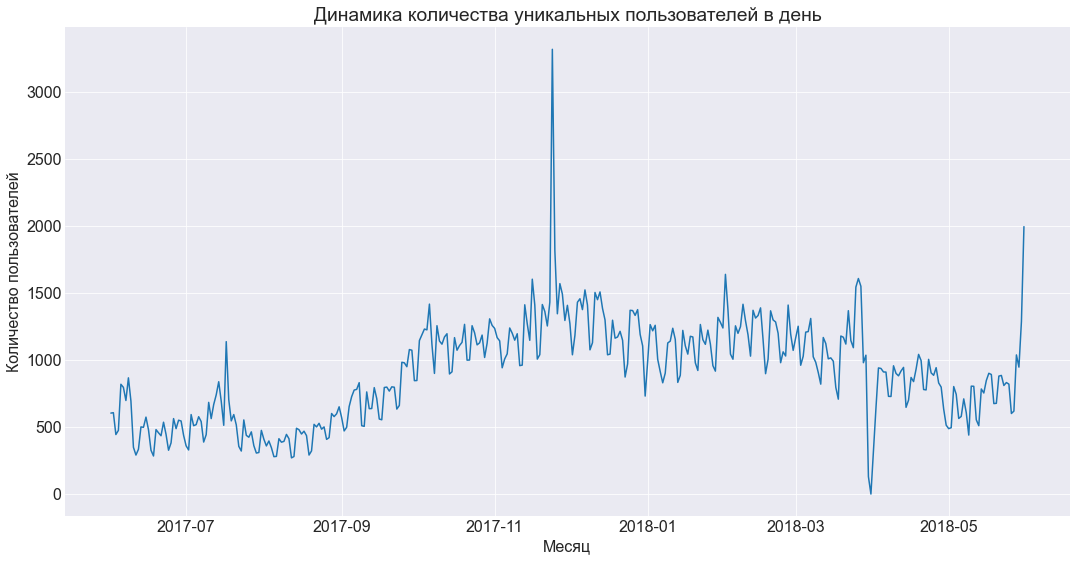

In [48]:
# посмотрим на динамику количества уникальных пользователей в день
dau = visits.groupby('session_date')\
            .agg({'uid': 'nunique'})\
            .reset_index()
fig, ax = plt.subplots()
plt.title('Динамика количества уникальных пользователей в день')
ax = sns.lineplot(x = 'session_date',
                  y = 'uid',
                  data = dau)       
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.show()

Динамика количества уникальных пользователей в день очень неравномерна, на графике имеются "зубцы", которые, вероятнее всего, свидетельствуют о разном распределении пользователей по дням недели. 

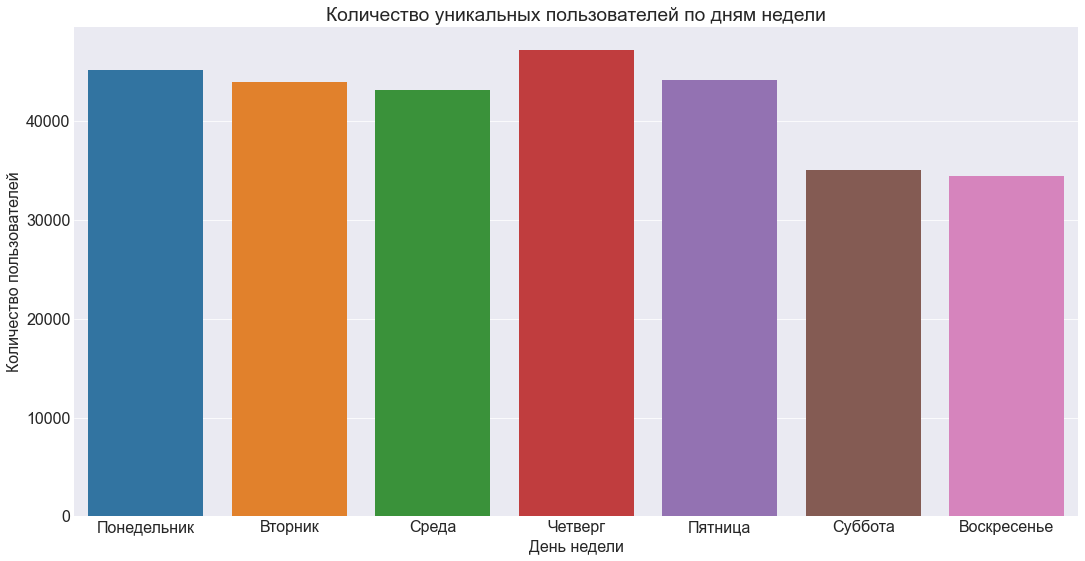

In [49]:
# посмотрим на количество уникальных пользователей по дням недели
nunique_day_of_week = visits.groupby('session_day_of_week')\
                            .agg({'uid': 'nunique'})\
                            .reset_index()
day_of_week = ['Понедельник',
               'Вторник',
               'Среда',
               'Четверг',
               'Пятница',
               'Суббота',
               'Воскресенье']
fig, ax = plt.subplots()
plt.title('Количество уникальных пользователей по дням недели')
ax = sns.barplot(x = 'session_day_of_week',
                 y = 'uid',
                 data = nunique_day_of_week)       
plt.xlabel('День недели')
plt.ylabel('Количество пользователей')
ax.set_xticklabels(labels = day_of_week)
plt.show()

Как и предполагалось, в выходные дни количество уникальных пользователей на сайте падает, наибольшее количество таких пользователей по четвергам.

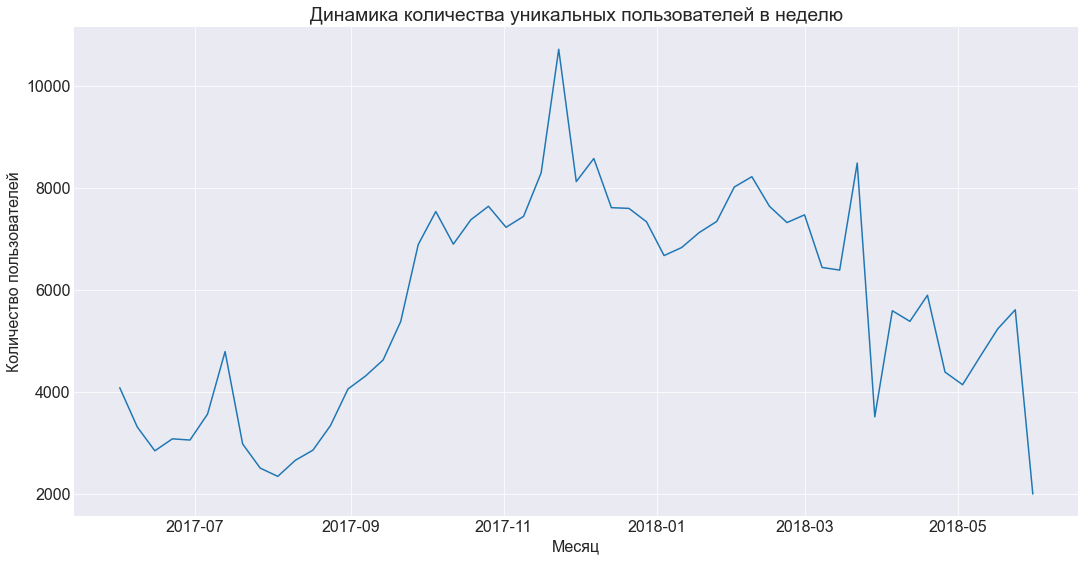

In [50]:
# посмотрим на динамику количества уникальных пользователей в неделю
wau = visits.groupby('session_week')\
            .agg({'uid': 'nunique'})\
            .reset_index()
fig, ax = plt.subplots()
plt.title('Динамика количества уникальных пользователей в неделю')
ax = sns.lineplot(x = 'session_week',
                  y = 'uid',
                  data = wau)       
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.show()

Имеется значительный недельный "всплеск" привлечения уникальных пользователей в конце декабря 2017 года, вероятнее всего связанный с новогодними праздниками. Кроме того есть небольшие "всплески" в начале октября 2017 года и середине марта 2018 года. В свою очередь "спад" отмечался в начале августа 2017 года и конце марта 2018 года.

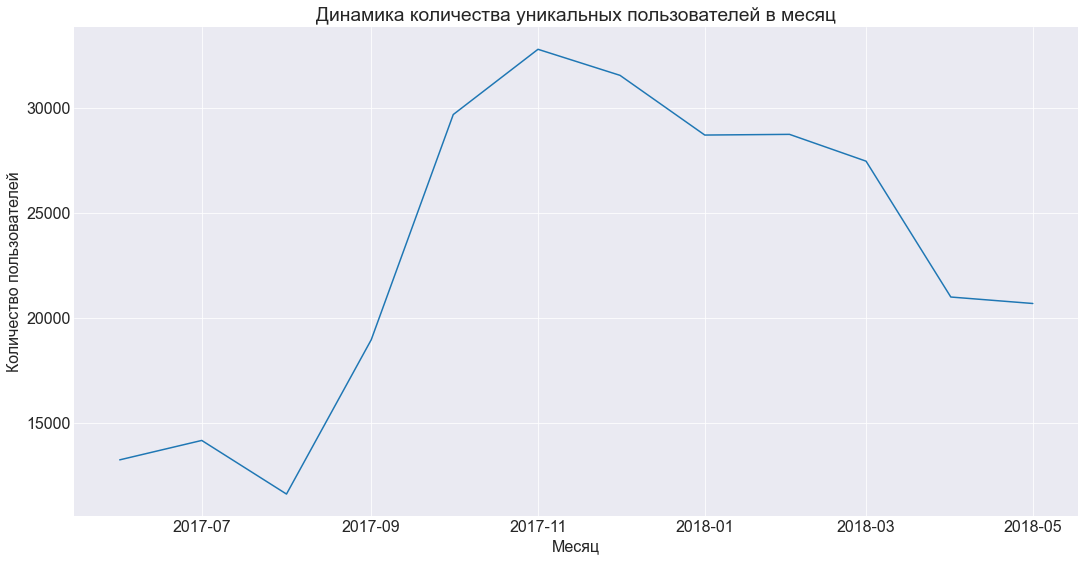

In [51]:
# посмотрим на динамику количества уникальных пользователей в месяц
mau = visits.groupby('session_month')\
            .agg({'uid': 'nunique'})\
            .reset_index()
fig, ax = plt.subplots()
plt.title('Динамика количества уникальных пользователей в месяц')
ax = sns.lineplot(x = 'session_month',
                  y = 'uid',
                  data = mau)       
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.show()

Наибольшее количество уникальных пользователей было привлечено на сайт в ноябре 2017 года, после которого их количество неуклонно снижается, наименьшее - в августе 2017 года.

In [52]:
# посчитаем средние метрики пользовательской активности
users_unique_count = visits['uid'].agg('nunique')
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
sticky_factor_wau = dau_total / wau_total * 100
sticky_factor_mau = dau_total / mau_total * 100
d = {'n_users': users_unique_count,
     'dau': int(dau_total),
     'wau': int(wau_total),
     'mau': int(mau_total),
     'sticky_factor_wau_pct': float(sticky_factor_wau),
     'sticky_factor_mau_pct': float(sticky_factor_mau)}
visits_metrics_all = pd.DataFrame(data = d,
                                  index = ['all'])
visits_metrics_all

n_users  dau   wau    mau  sticky_factor_wau_pct  sticky_factor_mau_pct
all   228168  907  5621  23228                  16.15                   3.91

Общее количество уникальных пользователей - 228168. Среднее количество уникальных пользователей в день - 907, в неделю - 5621, в месяц - 23228. Вовлечённость недельной аудитории - 16,15%, месячной - 3,91%.

In [53]:
# напишем функцию для расчета метрик пользовательской активности по различным группам
def user_activity(df, column):
    columns = [column, 'n_users', 'dau', 'wau', 'mau', 'sticky_factor_wau_pct', 'sticky_factor_mau_pct']
    visits_metrics = pd.DataFrame([], columns = columns)
    visits_metrics[column] = df[column].sort_values().unique()
    for parameter in visits_metrics[column]:
        visits_metrics.loc[visits_metrics[column] == parameter, 'n_users'] = \
            df.loc[df[column] == parameter]['uid'].agg('nunique')
        visits_metrics.loc[visits_metrics[column] == parameter, 'dau'] = \
            int(df.loc[df[column] == parameter].groupby('session_date').agg({'uid': 'nunique'}).mean())
        visits_metrics.loc[visits_metrics[column] == parameter, 'wau'] = \
            int(df.loc[df[column] == parameter].groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean())
        visits_metrics.loc[visits_metrics[column] == parameter, 'mau'] = \
            int(df.loc[df[column] == parameter].groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())
    visits_metrics['sticky_factor_wau_pct'] = visits_metrics['dau'] / visits_metrics['wau'] * 100
    visits_metrics['sticky_factor_mau_pct'] = visits_metrics['dau'] / visits_metrics['mau'] * 100
    return visits_metrics

###### По категориям устройств 

In [54]:
# применим функцию для расчета метрик пользовательской активности по категориям устройств
visits_metrics_device = user_activity(visits,
                                      'device')
visits_metrics_device

device n_users  dau   wau    mau sticky_factor_wau_pct  \
0  desktop  164522  659  4061  16724                 16.23   
1    touch   71345  252  1607   6825                 15.68   

  sticky_factor_mau_pct  
0                  3.94  
1                  3.69

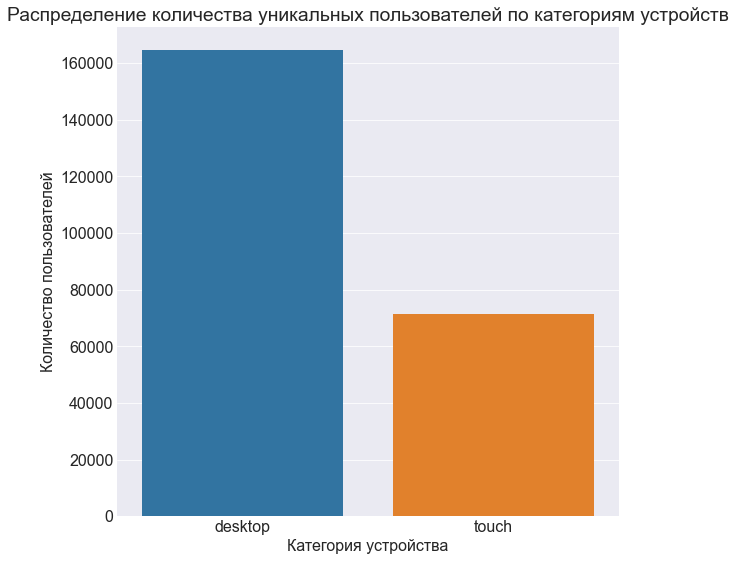

In [55]:
# посмотрим на распределение количества уникальных пользователей по категориям устройств
fig, ax = plt.subplots(figsize = (9, 9))
plt.title('Распределение количества уникальных пользователей по категориям устройств')
ax = sns.barplot(x = 'device',
                 y = 'n_users',
                 data = visits_metrics_device)       
plt.xlabel('Категория устройства')
plt.ylabel('Количество пользователей')
plt.show()

Общее количество уникальных пользователей, использующих стационарные устройства, - 164522, мобильные - 71345. Сумма рассчитанных показателей больше, чем общее количество уникальных пользователей, так как есть пользователи, которые для посещения сайта используют как стационарные, так и мобильные устройства. Среднее количество уникальных пользователей в день со стационарных устройств - 659, с мобильных - 252, в неделю - соответственно 4061 и 1607, в месяц - соответственно 16724 и 6825. Показатели вовлечённости пользователей практически равны на разных устройствах, в то же время на стационарных устройствах они незначительно выше, чем на мобильных.

In [56]:
# определим количество пользователей, которые для посещения сайта используют как стационарные, так и мобильные устройства
a = visits.query('device == "desktop"')['uid']\
          .value_counts().index.to_list()
visits.query('device == "touch" and uid == @a')['uid']\
      .agg('nunique')

7699

7699 пользователей для посещения сайта используют как стационарные, так и мобильные устройства.

In [57]:
# проверим правильность расчетов
visits_metrics_device['n_users'].sum()\
    - visits.query('device == "touch" and uid == @a')['uid'].agg('nunique')\
        - visits_metrics_all['n_users'].sum()    

0

###### По рекламным источникам 

In [58]:
# применим функцию для расчета метрик пользовательской активности по рекламным источникам
visits_metrics_source = user_activity(visits,
                                      'source_id')
visits_metrics_source

source_id n_users  dau   wau   mau sticky_factor_wau_pct  \
0          1   18999   80   456  1818                 17.54   
1          2   26245  120   703  2752                 17.07   
2          3   74756  232  1536  6758                 15.10   
3          4   83524  275  1797  7765                 15.30   
4          5   56974  175  1146  5017                 15.27   
5          6       6    1     1     1                100.00   
6          7      34    1     1     2                100.00   
7          9    9264   36   233   987                 15.45   
8         10    8067   26   163   707                 15.95   

  sticky_factor_mau_pct  
0                  4.40  
1                  4.36  
2                  3.43  
3                  3.54  
4                  3.49  
5                100.00  
6                 50.00  
7                  3.65  
8                  3.68

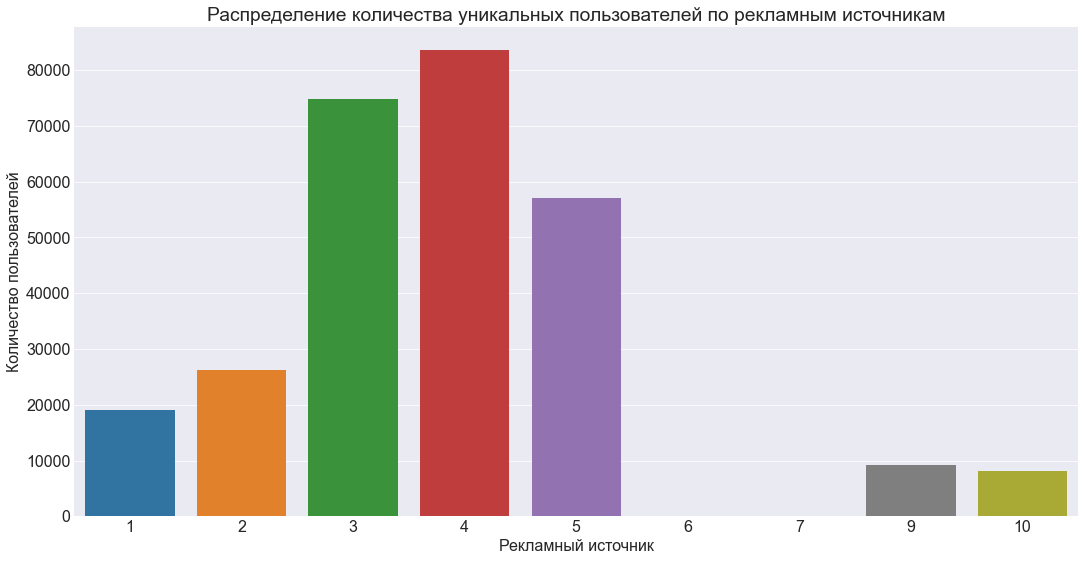

In [59]:
# посмотрим на распределение количества уникальных пользователей по рекламным источникам
fig, ax = plt.subplots()
plt.title('Распределение количества уникальных пользователей по рекламным источникам')
ax = sns.barplot(x = 'source_id',
                 y = 'n_users',
                 data = visits_metrics_source)       
plt.xlabel('Рекламный источник')
plt.ylabel('Количество пользователей')
plt.show()

Наибольшее общее количество уникальных пользователей привлечено на сайт при помощи четвертого рекламного источника - 83524, при помощи третьего - 74756. Сумма рассчитанных показателей больше, чем общее количество уникальных пользователей, так как есть пользователи, которые были привлечены с использованием различных источников. Наибольшее среднее количество уникальных пользователей было привлечено на сайт также при помощи четвертого рекламного источника (275 в день, 1797 в неделю и 7765 в месяц), при помощи третьего источника в среднем привлечено 232 пользователя в день, 1536 в неделю и 6758 в месяц.  При помощи шестого и седьмого рекламных источников пользователи практически не привлекались. Показатели вовлечённости аудитории выше у первого и второго рекламных источников.

##### Сколько сессий в день?    

###### По всей совокупности 

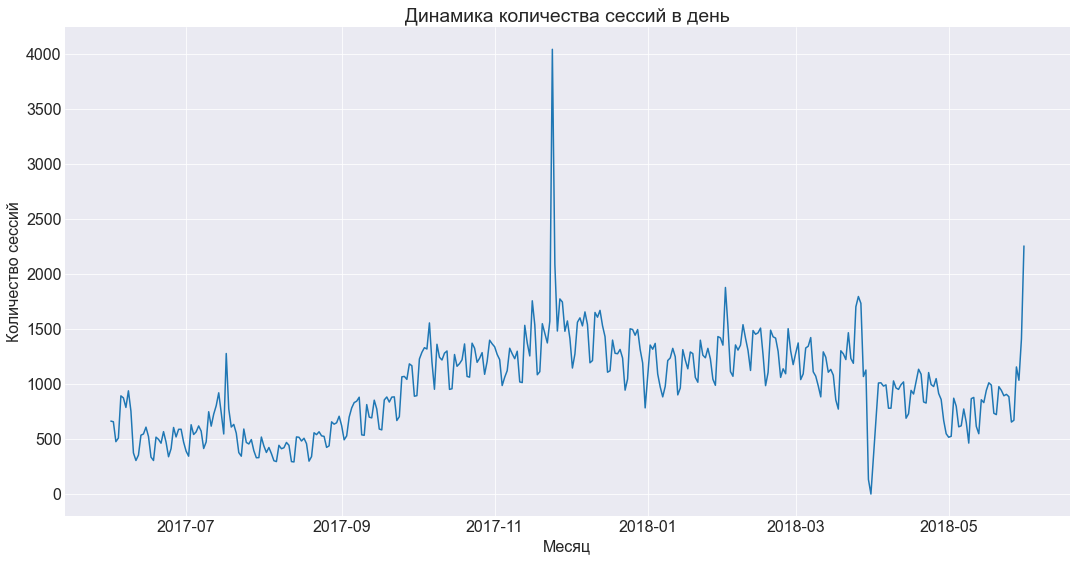

In [60]:
# посмотрим на динамику количества сессий в день
sessions_per_user = visits.groupby('session_date')\
                          .agg({'uid': ['count','nunique']})\
                          .reset_index()
sessions_per_user.columns = ['session_date',
                             'n_sessions',
                             'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
fig, ax = plt.subplots()
plt.title('Динамика количества сессий в день')
ax = sns.lineplot(x = 'session_date',
                  y = 'n_sessions',
                  data = sessions_per_user)       
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.show()

Имеется заметный "всплеск" в декабре, вероятнее всего связанный с новогодними праздниками. Также был небольшой "всплеск" в середине июля, середине февраля, ближе к концу марта, в конце мая. В то же время в конце марта - начале апреля имеется заметный "спад". Вероятнее всего, это связано с техническими неполадками на сайте.

In [61]:
# рассчитаем статистические показатели количества сессий в день
min_sessions_per_day = sessions_per_user['n_sessions'].agg('min')
max_sessions_per_day = sessions_per_user['n_sessions'].agg('max')
mean_sessions_per_day = sessions_per_user['n_sessions'].agg('mean')
median_sessions_per_day = int(sessions_per_user['n_sessions'].agg('median'))
d = {'min_sessions_per_day': min_sessions_per_day,
     'max_sessions_per_day': max_sessions_per_day,
     'mean_sessions_per_day': mean_sessions_per_day,
     'median_sessions_per_day': median_sessions_per_day}
sessions_metrics_all = pd.DataFrame(data = d,
                                    index = ['all'])
sessions_metrics_all

min_sessions_per_day  max_sessions_per_day  mean_sessions_per_day  \
all                     1                  4042                 987.36   

     median_sessions_per_day  
all                     1003

Минимальное количество сессий в день - 1, максимальное - 4042, среднее - 987, медианное - 1003. Поскольку среднее арифметическое незначительно отличается от медианы, в качестве основного показателя среднего количества сессий в день применим среднее арифметическое.

In [62]:
# оставим в таблице основной показатель меры центральной тенденции
sessions_metrics_all = sessions_metrics_all[['mean_sessions_per_day']].astype('int')\
                       .rename(columns = {'mean_sessions_per_day':'avg_sessions_per_day'})
sessions_metrics_all

avg_sessions_per_day
all                   987

In [63]:
# определим день с одной сессией
sessions_per_user.query('n_sessions == 1')

session_date  n_sessions  n_users  sessions_per_user
303   2018-03-31           1        1               1.00

Всего одна сессия была 31.03.2018. Как было ранее установлено, именно в этот день затраты были произведены только на пятый рекламный источник. Вероятнее всего, как уже было отмечено, на сайте в этот день были технические неполадки.

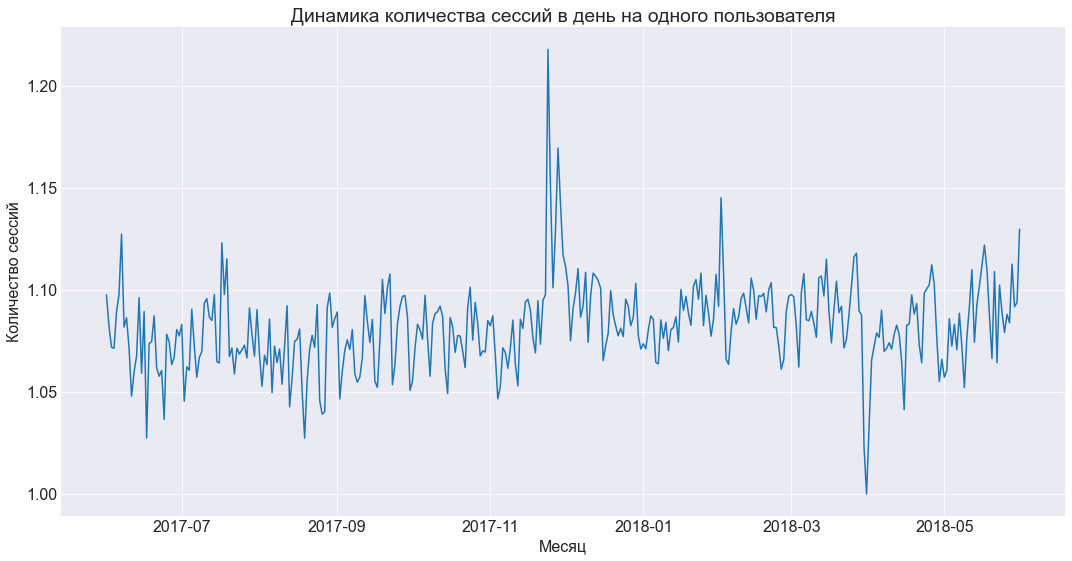

In [64]:
# посмотрим на динамику количества сессий в день на одного пользователя
fig, ax = plt.subplots()
plt.title('Динамика количества сессий в день на одного пользователя')
ax = sns.lineplot(x = 'session_date',
                  y = 'sessions_per_user',
                  data = sessions_per_user)       
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.show()

Динамика ежедневного количества сессий, приходящихся на одного пользователя,  близка к динамике количества ежедневных сессий с аналогичными "всплесками" и "спадами".

In [65]:
# рассчитаем статистические показатели количества сессий в день на одного пользователя
min_sessions_per_user_day = sessions_per_user['sessions_per_user'].agg('min')
max_sessions_per_user_day = sessions_per_user['sessions_per_user'].agg('max')
mean_sessions_per_user_day = sessions_per_user['sessions_per_user'].agg('mean')
median_sessions_per_user_day = sessions_per_user['sessions_per_user'].agg('median')
d = {'min_sessions_per_user_day': min_sessions_per_user_day,
     'max_sessions_per_user_day': max_sessions_per_user_day,
     'mean_sessions_per_user_day': mean_sessions_per_user_day,
     'median_sessions_per_user_day': median_sessions_per_user_day}
sessions_metrics_user_all = pd.DataFrame(data = d,
                                         index = ['all'])
sessions_metrics_user_all

min_sessions_per_user_day  max_sessions_per_user_day  \
all                       1.00                       1.22   

     mean_sessions_per_user_day  median_sessions_per_user_day  
all                        1.08                          1.08

Минимальное ежедневное количество сессий, приходящихся на одного пользователя, - 1, максимальное - 1,22, среднее и медианное - 1,08. Поскольку среднее арифметическое не отличается от медианы, в качестве основного показателя среднего количества сессий в день на одного пользователя применим среднее арифметическое.

In [66]:
# оставим в таблице основной показатель меры центральной тенденции
sessions_metrics_all['avg_sessions_per_user_day'] = sessions_metrics_user_all['mean_sessions_per_user_day']
sessions_metrics_all

avg_sessions_per_day  avg_sessions_per_user_day
all                   987                       1.08

###### По категориям устройств 

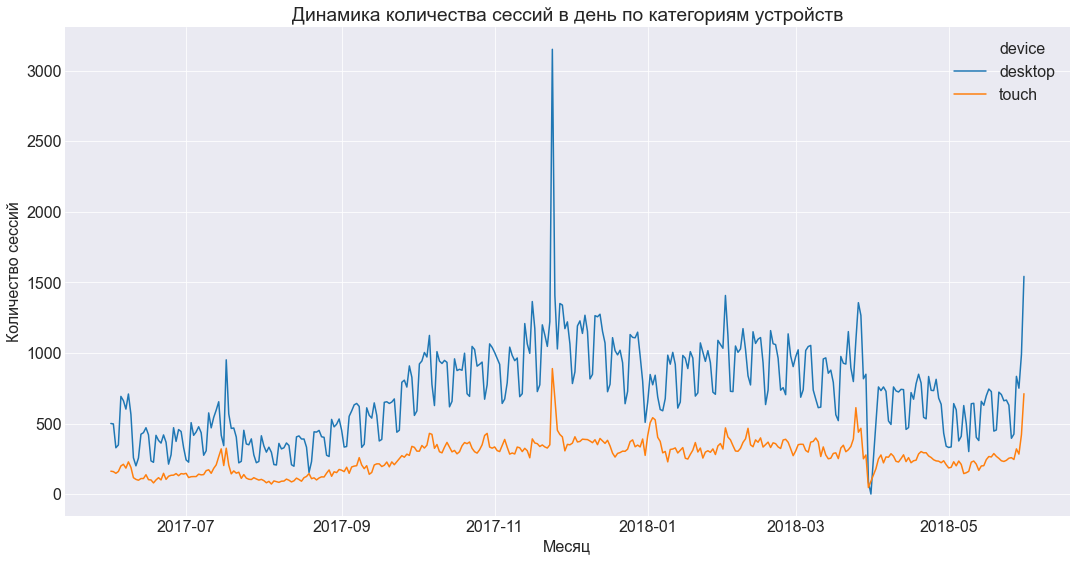

In [67]:
# посмотрим на динамику количества сессий в день по категориям устройств
sessions_per_user_device = visits.groupby(['device', 'session_date'])\
                                 .agg({'uid': ['count','nunique']})\
                                 .reset_index()
sessions_per_user_device.columns = ['device',
                                    'session_date',
                                    'n_sessions',
                                    'n_users']
sessions_per_user_device['sessions_per_user'] = sessions_per_user_device['n_sessions'] / sessions_per_user_device['n_users']
fig, ax = plt.subplots()
plt.title('Динамика количества сессий в день по категориям устройств')
ax = sns.lineplot(x = 'session_date',
                  y = 'n_sessions',
                  data = sessions_per_user_device,
                  hue = 'device')       
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.show()

Колебания количества сессий в день значительно выше при использовании стационарных устройств. Кроме того, ни в один из дней не было превышения случаев использования мобильных устройств для посещения сайта по сравнению со стационарными. 

In [68]:
# рассчитаем статистические показатели количества сессий в день по категориям устройств
sessions_metrics_device = sessions_per_user_device.groupby('device')['n_sessions']\
                                                  .agg(['min', 'max', 'mean', 'median'])\
                                                  .rename(columns = {'min':'min_sessions_per_day',
                                                                     'max':'max_sessions_per_day',
                                                                     'mean':'mean_sessions_per_day',
                                                                     'median':'median_sessions_per_day'})\
                                                  .reset_index()
sessions_metrics_device

device  min_sessions_per_day  max_sessions_per_day  mean_sessions_per_day  \
0  desktop                     1                  3152                 721.34   
1    touch                    47                   890                 266.76   

   median_sessions_per_day  
0                      711  
1                      278

Минимальное количество сессий в день при использовании стационарных устройств - 1, максимальное - 3152, среднее - 721, медианное - 711. При использовании мобильных устройств минимальное количество сессий в день - 47, максимальное - 890, среднее - 267, медианное - 278. Поскольку среднее арифметическое незначительно отличается от медианы, в качестве основного показателя среднего количества сессий в день применим среднее арифметическое.

In [69]:
# оставим в таблице основной показатель меры центральной тенденции
sessions_metrics_device = sessions_metrics_device[['device', 'mean_sessions_per_day']]\
                          .rename(columns = {'mean_sessions_per_day':'avg_sessions_per_day'})
sessions_metrics_device['avg_sessions_per_day'] = sessions_metrics_device['avg_sessions_per_day'].round().astype('int')
sessions_metrics_device

device  avg_sessions_per_day
0  desktop                   721
1    touch                   267

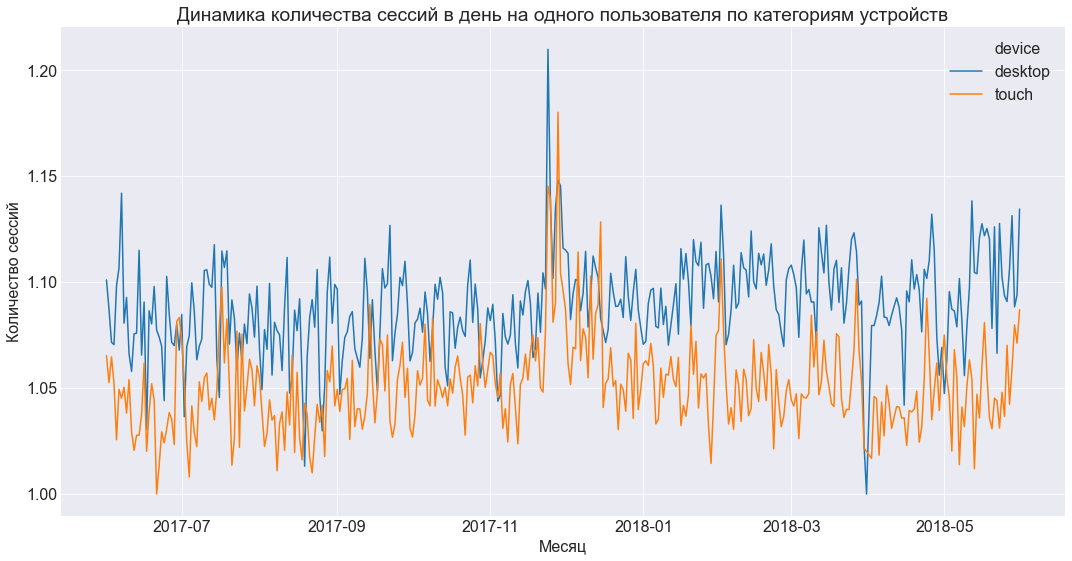

In [70]:
# посмотрим на динамику количества сессий в день на одного пользователя по категориям устройств
fig, ax = plt.subplots()
plt.title('Динамика количества сессий в день на одного пользователя по категориям устройств')
ax = sns.lineplot(x = 'session_date',
                  y = 'sessions_per_user',
                  data = sessions_per_user_device,
                  hue = 'device')       
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.show()

Динамика ежедневного количества сессий, приходящихся на одного пользователя, по категориям устройств близка к динамике количества ежедневных сессий. В то же время наблюдаются более значительные колебания этого показателя по сравнению с количеством ежедневных сессий у пользователей мобильных устройств, кроме того есть дни, когда количество сессий, приходящихся на одного пользователя, выше именно у владельцев мобильных устройств.

In [71]:
# рассчитаем статистические показатели количества сессий в день на одного пользователя по категориям устройств
sessions_metrics_user_device = sessions_per_user_device.groupby('device')['sessions_per_user']\
                                                       .agg(['min', 'max', 'mean', 'median'])\
                                                       .rename(columns = {'min':'min_sessions_per_user_day',
                                                                          'max':'max_sessions_per_user_day',
                                                                          'mean':'mean_sessions_per_user_day',
                                                                          'median':'median_sessions_per_user_day'})\
                                                       .reset_index()
sessions_metrics_user_device

device  min_sessions_per_user_day  max_sessions_per_user_day  \
0  desktop                       1.00                       1.21   
1    touch                       1.00                       1.18   

   mean_sessions_per_user_day  median_sessions_per_user_day  
0                        1.09                          1.09  
1                        1.05                          1.05

Минимальное количество сессий в день на одного пользователя при использовании стационарных устройств - 1, максимальное - 1,21, среднее и медианное - 1,09. При использовании мобильных устройств минимальное количество сессий в день на одного пользователя - 1, максимальное - 1,18, среднее и медианное чуть ниже, чем при использовании стационарных, - 1,05. Поскольку среднее арифметическое не отличается от медианы, в качестве основного показателя среднего количества сессий в день на одного пользователя применим среднее арифметическое.

In [72]:
# оставим в таблице основной показатель меры центральной тенденции
sessions_metrics_device['avg_sessions_per_user_day'] = sessions_metrics_user_device['mean_sessions_per_user_day']
sessions_metrics_device

device  avg_sessions_per_day  avg_sessions_per_user_day
0  desktop                   721                       1.09
1    touch                   267                       1.05

###### По рекламным источникам

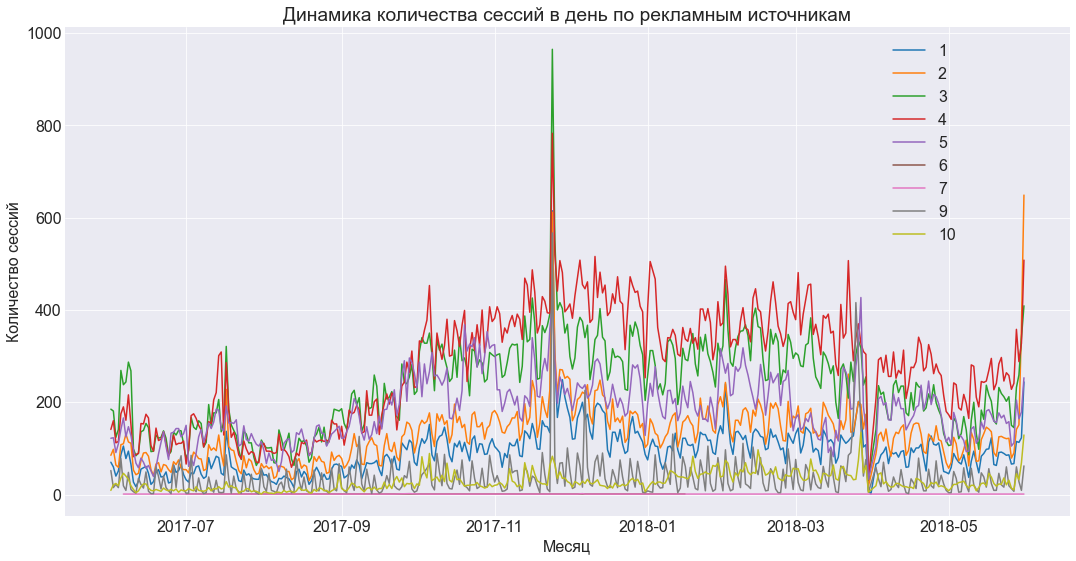

In [73]:
# посмотрим на динамику количества сессий в день по рекламным источникам
sessions_per_user_source = visits.groupby(['source_id', 'session_date'])\
                                 .agg({'uid': ['count','nunique']})\
                                 .reset_index()
sessions_per_user_source.columns = ['source_id',
                                    'session_date',
                                    'n_sessions',
                                    'n_users']
sessions_per_user_source['sessions_per_user'] = sessions_per_user_source['n_sessions'] / sessions_per_user_source['n_users']
fig, ax = plt.subplots()
ax.set(title = 'Динамика количества сессий в день по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Количество сессий')
for source in sessions_per_user_source['source_id'].unique():
    ax.plot(sessions_per_user_source.query('source_id == @source')['session_date'],
            sessions_per_user_source.query('source_id == @source')['n_sessions'],
            label = source)   
ax.grid = True
ax.legend(bbox_to_anchor = (0.81, 0.53))
plt.show()

Динамика количества сессий в день по рекламным источникам очень похожа, декабрьский "пик" при этом достигнут, в основном благодаря пользователям, пришедшим из третьего и четвертого рекламных источников.

In [74]:
# рассчитаем статистические показатели количества сессий в день по рекламным источникам
sessions_metrics_source = sessions_per_user_source.groupby('source_id')['n_sessions']\
                                                  .agg(['min', 'max', 'mean', 'median'])\
                                                  .rename(columns = {'min':'min_sessions_per_day',
                                                                     'max':'max_sessions_per_day',
                                                                     'mean':'mean_sessions_per_day',
                                                                     'median':'median_sessions_per_day'})\
                                                  .reset_index()
sessions_metrics_source

source_id  min_sessions_per_day  max_sessions_per_day  \
0          1                     1                   615   
1          2                    18                   649   
2          3                    32                   965   
3          4                    32                   783   
4          5                    33                   427   
5          6                     1                     1   
6          7                     1                     2   
7          9                     1                   567   
8         10                     1                   135   

   mean_sessions_per_day  median_sessions_per_day  
0                  93.74                       91  
1                 131.20                      131  
2                 235.84                      238  
3                 280.42                      300  
4                 184.31                      181  
5                   1.00                        1  
6                   1.06                        1  
7                  36.58                       22  
8                  27.62                       23

У третьего рекламного источника самый высокий показатель максимального количества сессий в день - 965. Среднее количество сессий в день наибольшее у четвертого рекламного источника - 280, медианное у него же - 300. Поскольку на некоторых рекламных источниках среднее арифметическое существенно отличается от медианы, в качестве основного показателя среднего количества сессий в день применим медиану.

In [75]:
# оставим в таблице основной показатель меры центральной тенденции
sessions_metrics_source = sessions_metrics_source[['source_id', 'median_sessions_per_day']]\
                          .rename(columns = {'median_sessions_per_day':'avg_sessions_per_day'})
sessions_metrics_source

source_id  avg_sessions_per_day
0          1                    91
1          2                   131
2          3                   238
3          4                   300
4          5                   181
5          6                     1
6          7                     1
7          9                    22
8         10                    23

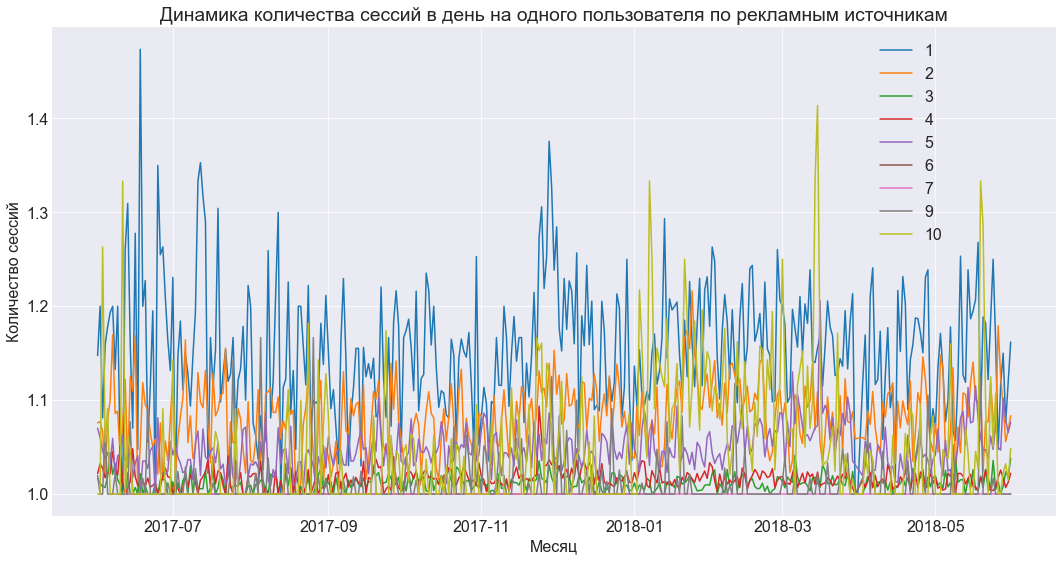

In [76]:
# посмотрим на динамику количества сессий в день на одного пользователя по рекламным источникам
fig, ax = plt.subplots()
ax.set(title = 'Динамика количества сессий в день на одного пользователя по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Количество сессий')
for source in sessions_per_user_source['source_id'].unique():
    ax.plot(sessions_per_user_source.query('source_id == @source')['session_date'],
            sessions_per_user_source.query('source_id == @source')['sessions_per_user'],
            label = source)    
ax.grid = True
ax.legend(bbox_to_anchor = (0.81, 0.53))
plt.show()

Динамика количества сессий в день на одного пользователя по рекламным источникам подвержена более значительным колебаниям, при этом у первого рекламного источника имеется самое большое количество "всплесков" этого показателя. 

In [77]:
# рассчитаем статистические показатели количества сессий в день на одного пользователя по рекламным источникам
sessions_metrics_user_source = sessions_per_user_source.groupby('source_id')['sessions_per_user']\
                                                       .agg(['min', 'max', 'mean', 'median'])\
                                                       .rename(columns = {'min':'min_sessions_per_user_day',
                                                                          'max':'max_sessions_per_user_day',
                                                                          'mean':'mean_sessions_per_user_day',
                                                                          'median':'median_sessions_per_user_day'})\
                                                       .reset_index()
sessions_metrics_user_source

source_id  min_sessions_per_user_day  max_sessions_per_user_day  \
0          1                       1.00                       1.47   
1          2                       1.00                       1.22   
2          3                       1.00                       1.04   
3          4                       1.00                       1.09   
4          5                       1.00                       1.21   
5          6                       1.00                       1.00   
6          7                       1.00                       1.00   
7          9                       1.00                       1.17   
8         10                       1.00                       1.41   

   mean_sessions_per_user_day  median_sessions_per_user_day  
0                        1.15                          1.15  
1                        1.08                          1.08  
2                        1.01                          1.01  
3                        1.02                          1.02  
4                        1.05                          1.04  
5                        1.00                          1.00  
6                        1.00                          1.00  
7                        1.01                          1.00  
8                        1.05                          1.01

Как уже отмечалось ранее, лучший рекламный источник по количеству сессий в день на одного пользователя - первый (максимальное - 1,47, среднее и медианное - 1,15). У третьего и четвертого рекламных источников, у которых наибольшие показатели абсолютного количества сессий в день, среднее количество сессий в день на одного пользователя близко к 1 - соответственно 1,01 и 1,02. Поскольку на некоторых рекламных источниках среднее арифметическое существенно отличается от медианы, в качестве основного показателя среднего количества сессий в день на одного пользователя применим медиану.

In [78]:
# оставим в таблице основной показатель меры центральной тенденции
sessions_metrics_source['avg_sessions_per_user_day'] = sessions_metrics_user_source['median_sessions_per_user_day']
sessions_metrics_source

source_id  avg_sessions_per_day  avg_sessions_per_user_day
0          1                    91                       1.15
1          2                   131                       1.08
2          3                   238                       1.01
3          4                   300                       1.02
4          5                   181                       1.04
5          6                     1                       1.00
6          7                     1                       1.00
7          9                    22                       1.00
8         10                    23                       1.01

#####  Сколько длится одна сессия?    

###### По всей совокупности 

In [79]:
# добавим в таблицу столбец с продолжительностью сессии в секундах
visits['session_duration_sec'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds
visits.head()

uid   device  source_id    session_start_ts  \
0  16879256277535980062    touch          4 2017-12-20 17:20:00   
1    104060357244891740  desktop          2 2018-02-19 16:53:00   
2   7459035603376831527    touch          5 2017-07-01 01:54:00   
3  16174680259334210214  desktop          9 2018-05-20 10:59:00   
4   9969694820036681168  desktop          3 2017-12-27 14:06:00   

       session_end_ts  session_year session_month session_week  \
0 2017-12-20 17:38:00          2017    2017-12-01   2017-12-14   
1 2018-02-19 17:21:00          2018    2018-02-01   2018-02-15   
2 2017-07-01 01:54:00          2017    2017-07-01   2017-06-29   
3 2018-05-20 11:23:00          2018    2018-05-01   2018-05-17   
4 2017-12-27 14:06:00          2017    2017-12-01   2017-12-21   

   session_day_of_week session_date  session_duration_sec  
0                    2   2017-12-20                  1080  
1                    0   2018-02-19                  1680  
2                    5   2017-07-01                     0  
3                    6   2018-05-20                  1440  
4                    2   2017-12-27                     0

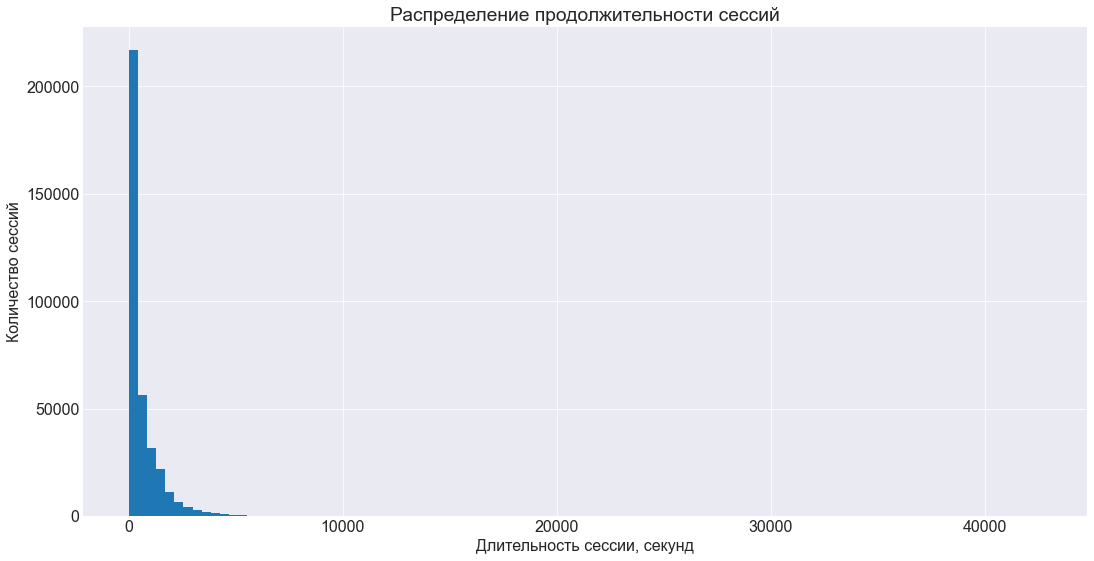

In [80]:
# посмотрим на распределение продолжительности сессий
fig, ax = plt.subplots()
ax.set(title = 'Распределение продолжительности сессий',
       xlabel = 'Длительность сессии, секунд',
       ylabel = 'Количество сессий')
ax.hist(visits['session_duration_sec'],
        bins = 100)
plt.show()

Распределение продолжительности сессий очень неравномерно, наибольшее количество сессий с короткой продолжительностью, хотя имеются и весьма продолжительные сессии. Рассчитаем меры центральной тенденции и определим показатель, который лучше всего отразит метрику ASL.

In [81]:
# рассчитаем статистические показатели продолжительности сессии
session_duration_sec_mean = int(visits['session_duration_sec'].mean())
session_duration_sec_median = int(visits['session_duration_sec'].median())
session_duration_sec_mode = int(visits['session_duration_sec'].mode())
d = {'session_duration_sec_mean': session_duration_sec_mean,
     'session_duration_sec_median': session_duration_sec_median,
     'session_duration_sec_mode': session_duration_sec_mode}
asl_metrics_all = pd.DataFrame(data = d, index = ['all'])
asl_metrics_all

session_duration_sec_mean  session_duration_sec_median  \
all                        643                          300   

     session_duration_sec_mode  
all                         60

Средее арифметическое продолжительности сессии - 643 секунды, медиана - 300 секунд, мода - 60 секунд. Поскольку распределение продолжительности сессий не является нормальным и не близко к нормальному, среднее арифметическое и медиана не могут использоваться для оценки среднего показателя продолжительности сессии. Показателем ASL, в том числе в разрезе категорий устройств и рекламных источников, в данном случае будет являться мода.

In [82]:
# оставим в таблице основной показатель меры центральной тенденции
asl_metrics_all = asl_metrics_all[['session_duration_sec_mode']]\
                  .rename(columns = {'session_duration_sec_mode':'asl_sec'})
asl_metrics_all

asl_sec
all       60

###### По категориям устройств 

In [83]:
# рассчитаем ASL по категориям устройств
asl_metrics_device = visits.groupby('device')['session_duration_sec']\
                           .apply(lambda x: x.mode().iloc[0])\
                           .reset_index()\
                           .rename(columns = {'session_duration_sec':'asl_sec'})
asl_metrics_device

device  asl_sec
0  desktop       60
1    touch       60

Показатель средней продолжительности сессии ASL по категориям устройств соответствует общему показателю ASL.

###### По рекламным источникам 

In [84]:
# рассчитаем ASL по рекламным источникам
asl_metrics_source = visits.groupby('source_id')['session_duration_sec']\
                           .apply(lambda x: x.mode().iloc[0])\
                           .reset_index()\
                           .rename(columns = {'session_duration_sec':'asl_sec'})
asl_metrics_source

source_id  asl_sec
0          1       60
1          2       60
2          3       60
3          4       60
4          5       60
5          6        0
6          7      120
7          9       60
8         10       60

Показатель средней продолжительности сессии ASL по рекламным источникам соответствует общему показателю ASL, за исключением шестого и седьмого рекламных источников, при помощи которых привлечено небольшое количество пользователей.

##### Как часто люди возвращаются?  

###### По всей совокупности 

In [85]:
# определим дату первого посещения сайта пользователями
first_session = visits.groupby('uid')\
                      .agg({'session_start_ts':'min'})\
                      .rename(columns = {'session_start_ts':'first_session'})                      
first_session.head()

first_session
uid                                
11863502262781  2018-03-01 17:27:00
49537067089222  2018-02-06 15:55:00
297729379853735 2017-06-07 18:47:00
313578113262317 2017-09-18 22:49:00
325320750514679 2017-09-30 14:29:00

In [86]:
# добавим в таблицу с визитами столбец с датой первого посещения сайта пользователями
visits = visits.join(first_session,
                     on = 'uid')
visits.head()

uid   device  source_id    session_start_ts  \
0  16879256277535980062    touch          4 2017-12-20 17:20:00   
1    104060357244891740  desktop          2 2018-02-19 16:53:00   
2   7459035603376831527    touch          5 2017-07-01 01:54:00   
3  16174680259334210214  desktop          9 2018-05-20 10:59:00   
4   9969694820036681168  desktop          3 2017-12-27 14:06:00   

       session_end_ts  session_year session_month session_week  \
0 2017-12-20 17:38:00          2017    2017-12-01   2017-12-14   
1 2018-02-19 17:21:00          2018    2018-02-01   2018-02-15   
2 2017-07-01 01:54:00          2017    2017-07-01   2017-06-29   
3 2018-05-20 11:23:00          2018    2018-05-01   2018-05-17   
4 2017-12-27 14:06:00          2017    2017-12-01   2017-12-21   

   session_day_of_week session_date  session_duration_sec       first_session  
0                    2   2017-12-20                  1080 2017-12-20 17:20:00  
1                    0   2018-02-19                  1680 2018-02-19 16:53:00  
2                    5   2017-07-01                     0 2017-07-01 01:54:00  
3                    6   2018-05-20                  1440 2018-03-09 20:05:00  
4                    2   2017-12-27                     0 2017-12-27 14:06:00

Исходя из предшествующего анализа, целесообразно проводить когортный анализ с периодом в 1 месяц.

In [87]:
# добавим в таблицу столбцы с месяцами посещения и первого посещения сайта пользователями
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')
visits['first_session_month'] = visits['first_session'].astype('datetime64[M]')
visits.head()                          

uid   device  source_id    session_start_ts  \
0  16879256277535980062    touch          4 2017-12-20 17:20:00   
1    104060357244891740  desktop          2 2018-02-19 16:53:00   
2   7459035603376831527    touch          5 2017-07-01 01:54:00   
3  16174680259334210214  desktop          9 2018-05-20 10:59:00   
4   9969694820036681168  desktop          3 2017-12-27 14:06:00   

       session_end_ts  session_year session_month session_week  \
0 2017-12-20 17:38:00          2017    2017-12-01   2017-12-14   
1 2018-02-19 17:21:00          2018    2018-02-01   2018-02-15   
2 2017-07-01 01:54:00          2017    2017-07-01   2017-06-29   
3 2018-05-20 11:23:00          2018    2018-05-01   2018-05-17   
4 2017-12-27 14:06:00          2017    2017-12-01   2017-12-21   

   session_day_of_week session_date  session_duration_sec       first_session  \
0                    2   2017-12-20                  1080 2017-12-20 17:20:00   
1                    0   2018-02-19                  1680 2018-02-19 16:53:00   
2                    5   2017-07-01                     0 2017-07-01 01:54:00   
3                    6   2018-05-20                  1440 2018-03-09 20:05:00   
4                    2   2017-12-27                     0 2017-12-27 14:06:00   

  activity_month first_session_month  
0     2017-12-01          2017-12-01  
1     2018-02-01          2018-02-01  
2     2017-07-01          2017-07-01  
3     2018-05-01          2018-03-01  
4     2017-12-01          2017-12-01

In [88]:
# добавим в таблицу столбец с lifetime пользователей
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_session_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round()\
                                                     .astype('int')
visits.head()                          

uid   device  source_id    session_start_ts  \
0  16879256277535980062    touch          4 2017-12-20 17:20:00   
1    104060357244891740  desktop          2 2018-02-19 16:53:00   
2   7459035603376831527    touch          5 2017-07-01 01:54:00   
3  16174680259334210214  desktop          9 2018-05-20 10:59:00   
4   9969694820036681168  desktop          3 2017-12-27 14:06:00   

       session_end_ts  session_year session_month session_week  \
0 2017-12-20 17:38:00          2017    2017-12-01   2017-12-14   
1 2018-02-19 17:21:00          2018    2018-02-01   2018-02-15   
2 2017-07-01 01:54:00          2017    2017-07-01   2017-06-29   
3 2018-05-20 11:23:00          2018    2018-05-01   2018-05-17   
4 2017-12-27 14:06:00          2017    2017-12-01   2017-12-21   

   session_day_of_week session_date  session_duration_sec       first_session  \
0                    2   2017-12-20                  1080 2017-12-20 17:20:00   
1                    0   2018-02-19                  1680 2018-02-19 16:53:00   
2                    5   2017-07-01                     0 2017-07-01 01:54:00   
3                    6   2018-05-20                  1440 2018-03-09 20:05:00   
4                    2   2017-12-27                     0 2017-12-27 14:06:00   

  activity_month first_session_month  cohort_lifetime  
0     2017-12-01          2017-12-01                0  
1     2018-02-01          2018-02-01                0  
2     2017-07-01          2017-07-01                0  
3     2018-05-01          2018-03-01                2  
4     2017-12-01          2017-12-01                0

In [89]:
# сформируем когорты пользователей  по первому месяцу посещения сайта
cohorts = visits.groupby(['first_session_month','cohort_lifetime'])\
                .agg({'uid':'nunique'})\
                .reset_index()
cohorts.head()

first_session_month  cohort_lifetime    uid
0          2017-06-01                0  13259
1          2017-06-01                1   1043
2          2017-06-01                2    713
3          2017-06-01                3    814
4          2017-06-01                4    909

In [90]:
# определим исходное количество пользователей в когортах
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})
initial_users_count

first_session_month  cohort_users
0           2017-06-01         13259
12          2017-07-01         13140
23          2017-08-01         10181
33          2017-09-01         16704
42          2017-10-01         25977
50          2017-11-01         27248
57          2017-12-01         25268
63          2018-01-01         22624
68          2018-02-01         22197
72          2018-03-01         20589
75          2018-04-01         15709
77          2018-05-01         15272

In [91]:
# добавим в таблицу столбец с исходным количеством пользователей в когортах
cohorts = cohorts.merge(initial_users_count,
                        on = 'first_session_month')
cohorts.head()

first_session_month  cohort_lifetime    uid  cohort_users
0          2017-06-01                0  13259         13259
1          2017-06-01                1   1043         13259
2          2017-06-01                2    713         13259
3          2017-06-01                3    814         13259
4          2017-06-01                4    909         13259

In [92]:
# посчитаем показатель Retention Rate по когортам и lifetime
cohorts['retention_rate'] = cohorts['uid'] / cohorts['cohort_users']
cohorts.head()

first_session_month  cohort_lifetime    uid  cohort_users  retention_rate
0          2017-06-01                0  13259         13259            1.00
1          2017-06-01                1   1043         13259            0.08
2          2017-06-01                2    713         13259            0.05
3          2017-06-01                3    814         13259            0.06
4          2017-06-01                4    909         13259            0.07

In [93]:
# построим сводную таблицу с показателем Retention Rate по когортам и lifetime
retention_rate = cohorts.pivot_table(index = 'first_session_month',
                                     columns = 'cohort_lifetime',
                                     values = 'retention_rate',
                                     aggfunc = 'sum')
retention_rate.fillna('')

cohort_lifetime       0    1    2    3    4    5    6    7    8    9    10  \
first_session_month                                                          
2017-06-01          1.00 0.08 0.05 0.06 0.07 0.07 0.06 0.06 0.05 0.05 0.04   
2017-07-01          1.00 0.06 0.05 0.06 0.06 0.05 0.05 0.05 0.04 0.03 0.03   
2017-08-01          1.00 0.08 0.06 0.06 0.05 0.04 0.04 0.04 0.03 0.03        
2017-09-01          1.00 0.09 0.07 0.05 0.04 0.04 0.04 0.02 0.02             
2017-10-01          1.00 0.08 0.05 0.04 0.03 0.03 0.02 0.02                  
2017-11-01          1.00 0.08 0.04 0.04 0.03 0.02 0.02                       
2017-12-01          1.00 0.06 0.04 0.03 0.02 0.02                            
2018-01-01          1.00 0.06 0.04 0.02 0.02                                 
2018-02-01          1.00 0.06 0.03 0.02                                      
2018-03-01          1.00 0.04 0.03                                           
2018-04-01          1.00 0.05                                                
2018-05-01          1.00                                                     

cohort_lifetime       11  
first_session_month       
2017-06-01          0.04  
2017-07-01                
2017-08-01                
2017-09-01                
2017-10-01                
2017-11-01                
2017-12-01                
2018-01-01                
2018-02-01                
2018-03-01                
2018-04-01                
2018-05-01

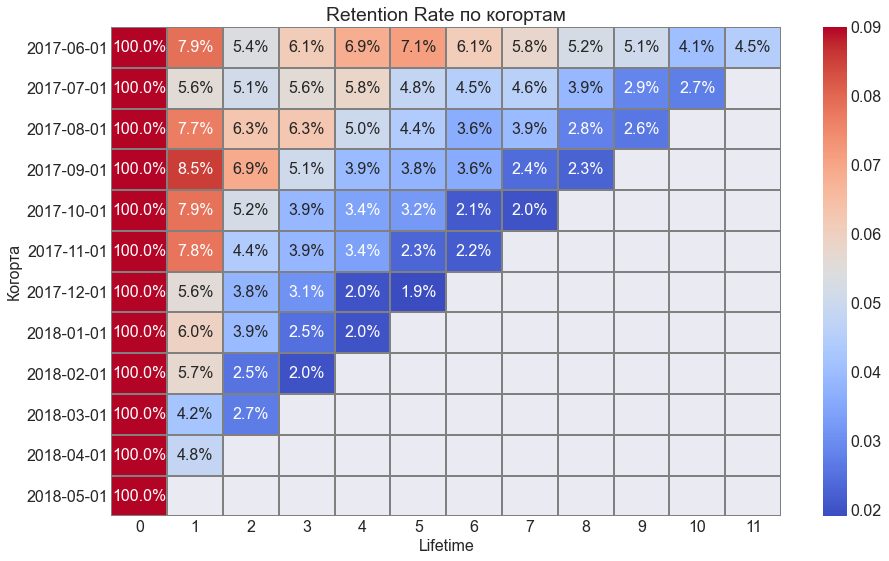

In [94]:
# создадим тепловую карту с показателем Retention Rate по когортам и lifetime
plt.figure(figsize = (15, 9))
plt.title('Retention Rate по когортам')
ax = sns.heatmap(retention_rate,
                 annot = True,
                 fmt = '.1%',
                 vmax = 0.09,
                 linewidths = 1,
                 cmap = 'coolwarm',
                 linecolor = 'gray',
                 yticklabels = retention_rate.index.date)
plt.xlabel('Lifetime')
plt.ylabel('Когорта')
plt.show()

Показатель возврата пользователя к продукту (Retention Rate) очень низок - ни в один из месяцев "жизни" когорты коэффициент удержания не был выше 10%, при этом со временем Retention Rate снижается. Retention Rate в первый месяц "жизни" убывает по когортам, начиная с января 2018 года. Так, если для когорты пользователей, пришедших в сентябре 2017 года, Retention Rate в первый месяц составлял 8,5%, то для пользователей, пришедших в декабре 2017 года, — всего 5,6%, и в дальнейшем уменьшается. Самые активные пользователи - впервые посетившие сайт в июне 2017 года, с течением времени Retention Rate у этой когорты не был менее 4%.

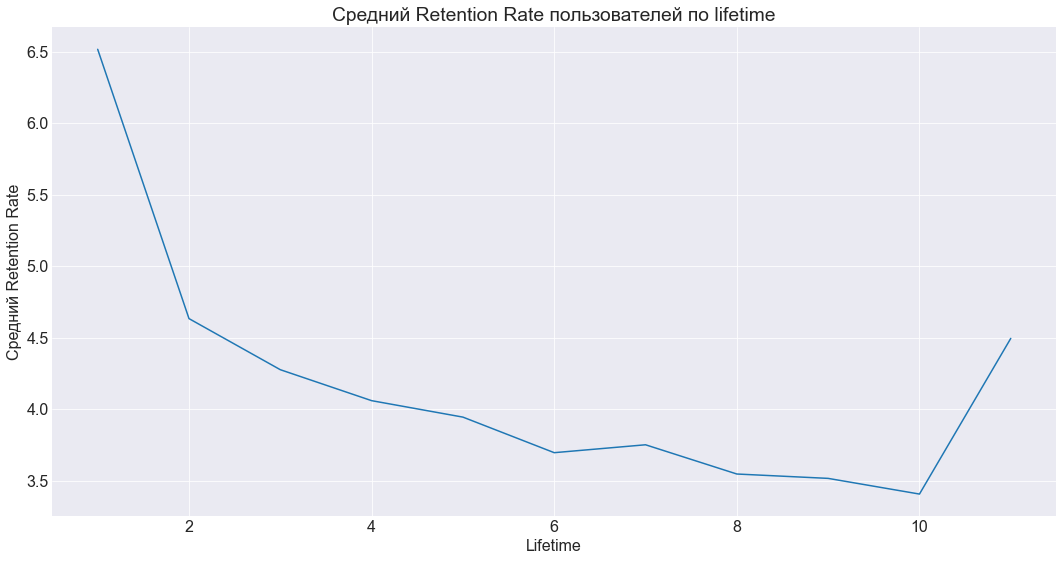

In [95]:
# посмотрим на динамику среднего Retention Rate по времени "жизни" когорты
retention_rate_mean = cohorts.groupby('cohort_lifetime')['retention_rate']\
                             .mean() * 100
fig, ax = plt.subplots()
plt.title('Средний Retention Rate пользователей по lifetime')
ax = sns.lineplot(x = retention_rate_mean[1:12].index,
                  y = retention_rate_mean[1:12])       
plt.xlabel('Lifetime')
plt.ylabel('Средний Retention Rate')
plt.show()

Средний коэффициент удержания Retention Rate с течением "жизни" когорт неуклонно снижается, за исключением 11 месяца, где всего одна когорта с самыми активными пользователями, впервые посетившими сайт в июне 2017 года.

In [96]:
# рассчитаем средний Retention Rate по первому месяцу "жизни" когорты
retention_rate_first_mean = cohorts.query('cohort_lifetime == 1')['retention_rate']\
                                   .mean() * 100
d = {'avg_retention_rate_first_pct': retention_rate_first_mean}
retention_metrics_all = pd.DataFrame(data = d,
                                     index = ['all'])
retention_metrics_all

avg_retention_rate_first_pct
all                          6.52

Средний коэффициент удержания Retention Rate по первому месяцу "жизни" когорты составляет 6,52%.

In [97]:
# посчитаем Churn Rate по когортам и lifetime
cohorts['churn_rate'] = cohorts.groupby('first_session_month')['uid']\
                               .pct_change()
cohorts.head()

first_session_month  cohort_lifetime    uid  cohort_users  retention_rate  \
0          2017-06-01                0  13259         13259            1.00   
1          2017-06-01                1   1043         13259            0.08   
2          2017-06-01                2    713         13259            0.05   
3          2017-06-01                3    814         13259            0.06   
4          2017-06-01                4    909         13259            0.07   

   churn_rate  
0         nan  
1       -0.92  
2       -0.32  
3        0.14  
4        0.12

In [98]:
# построим сводную таблицу с показателем Churn Rate по когортам и lifetime
churn_rate = cohorts.pivot_table(index = 'first_session_month',
                                 columns = 'cohort_lifetime',
                                 values = 'churn_rate',
                                 aggfunc = 'sum')
churn_rate.fillna('')

cohort_lifetime       0     1     2     3     4     5     6     7     8   \
first_session_month                                                        
2017-06-01          0.00 -0.92 -0.32  0.14  0.12  0.04 -0.15 -0.05 -0.09   
2017-07-01          0.00 -0.94 -0.09  0.09  0.04 -0.17 -0.06  0.01 -0.15   
2017-08-01          0.00 -0.92 -0.18 -0.00 -0.20 -0.12 -0.17  0.09 -0.29   
2017-09-01          0.00 -0.91 -0.19 -0.27 -0.22 -0.04 -0.05 -0.33 -0.06   
2017-10-01          0.00 -0.92 -0.34 -0.25 -0.12 -0.06 -0.34 -0.05         
2017-11-01          0.00 -0.92 -0.44 -0.12 -0.13 -0.31 -0.07               
2017-12-01          0.00 -0.94 -0.32 -0.18 -0.35 -0.06                     
2018-01-01          0.00 -0.94 -0.34 -0.37 -0.19                           
2018-02-01          0.00 -0.94 -0.55 -0.21                                 
2018-03-01          0.00 -0.96 -0.35                                       
2018-04-01          0.00 -0.95                                             
2018-05-01          0.00                                                   

cohort_lifetime        9     10   11  
first_session_month                   
2017-06-01          -0.03 -0.20 0.11  
2017-07-01          -0.26 -0.04       
2017-08-01          -0.07             
2017-09-01                            
2017-10-01                            
2017-11-01                            
2017-12-01                            
2018-01-01                            
2018-02-01                            
2018-03-01                            
2018-04-01                            
2018-05-01

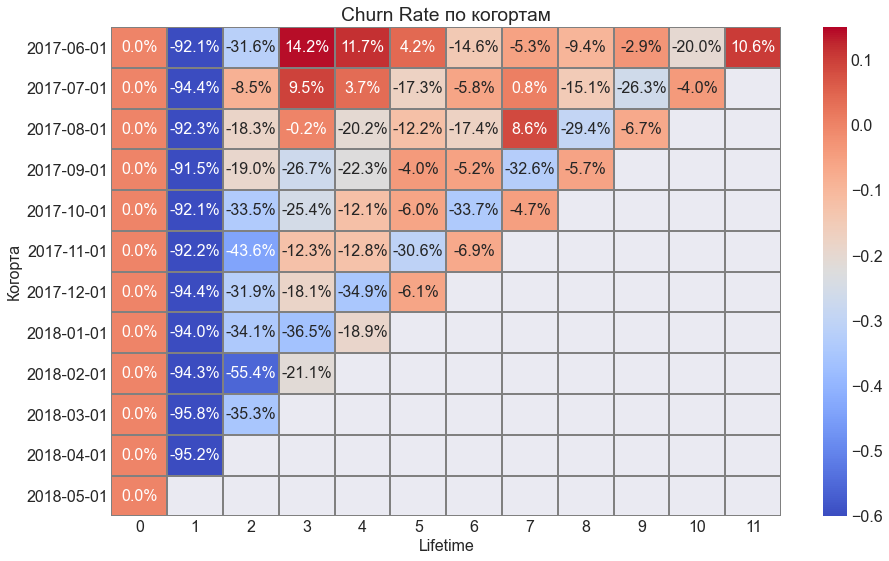

In [99]:
# создадим тепловую карту с показателем Churn Rate по когортам и lifetime
plt.figure(figsize = (15, 9))
plt.title('Churn Rate по когортам')
ax = sns.heatmap(churn_rate,
                 annot = True,
                 fmt = '.1%',
                 vmin = -0.6,
                 vmax = 0.15,
                 linewidths = 1,
                 cmap = 'coolwarm',
                 yticklabels = churn_rate.index.date,
                 linecolor = 'gray')
plt.xlabel('Lifetime')
plt.ylabel('Когорта')
plt.show()

Более 90% пользователей не возвращаются на сайт в первый месяц "жизни" когорты. В основном показатели Churn Rate отрицательные, положительных значений очень мало, что свидетельствует о том, что случаев возврата пользователей в следующем месяце по сравнению с предыдущим совсем немного. Наибольшее количество положительных значений Churn Rate у когорты пользователей, впервые посетивших сайт в июне 2017 года.

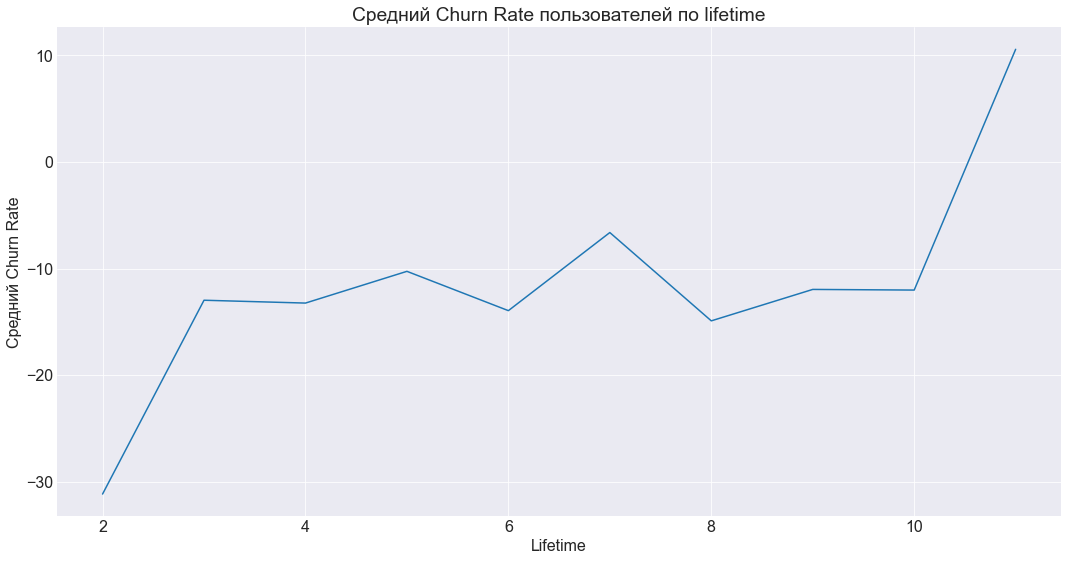

In [100]:
# посмотрим на динамику среднего Churn Rate по времени "жизни" когорты
churn_rate_mean = cohorts.groupby('cohort_lifetime')['churn_rate']\
                         .mean() * 100
fig, ax = plt.subplots()
plt.title('Средний Churn Rate пользователей по lifetime')
ax = sns.lineplot(x = churn_rate_mean[2:12].index,
                  y = churn_rate_mean[2:12])       
plt.xlabel('Lifetime')
plt.ylabel('Средний Churn Rate')
plt.show()

Средний коэффициент возврата Churn Rate с 3 месяца жизни когорт остается практически неизменным, за исключением 11 месяца, где всего одна когорта с самыми активными пользователями, впервые посетившими сайт в июне 2017 года.

###### По категориям устройств 

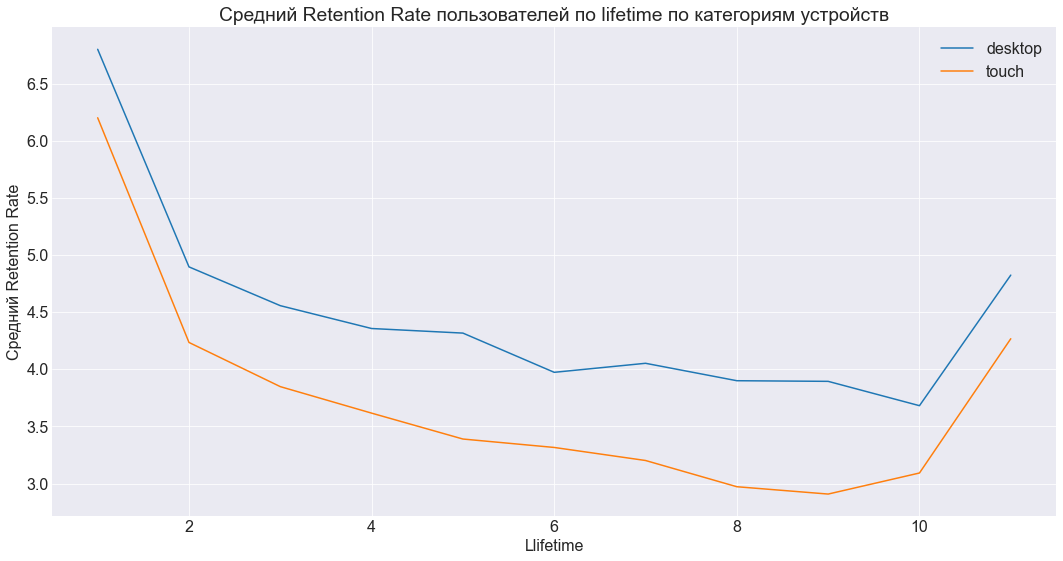

In [101]:
# посмотрим на динамику среднего Retention Rate по времени "жизни" когорты по категориям устройств
cohorts_device = visits.groupby(['device',
                                 'first_session_month',
                                 'cohort_lifetime'])\
                       .agg({'uid':'nunique'})\
                       .reset_index()
initial_users_count_device = cohorts_device[cohorts_device['cohort_lifetime'] == 0][['device',
                                                                                     'first_session_month',
                                                                                     'uid']]
initial_users_count_device = initial_users_count_device.rename(columns = {'uid':'cohort_users'})
cohorts_device = cohorts_device.merge(initial_users_count_device,
                                      on = ['device',
                                            'first_session_month'])
cohorts_device['retention_rate'] = cohorts_device['uid'] / cohorts_device['cohort_users']
retention_rate_mean_device = cohorts_device.groupby(['device',
                                                     'cohort_lifetime'])['retention_rate']\
                                           .mean() * 100
retention_rate_mean_device = retention_rate_mean_device.reset_index()
fig, ax = plt.subplots()
ax.set(title = 'Средний Retention Rate пользователей по lifetime по категориям устройств',
       xlabel = 'Llifetime',
       ylabel = 'Средний Retention Rate')
for device in retention_rate_mean_device['device'].unique():
    ax.plot(retention_rate_mean_device.query('device == @device')['cohort_lifetime'][1:12],
            retention_rate_mean_device.query('device == @device')['retention_rate'][1:12],
            label = device )
ax.legend()
plt.show()

Средний коэффициент удержания Retention Rate с течением "жизни" когорт снижается у пользователей и мобильных, и стационарных устройств.

In [102]:
# рассчитаем средний Retention Rate по первому месяцу "жизни" когорты по категориям устройств
retention_metrics_device = retention_rate_mean_device.query('cohort_lifetime == 1')\
                                                     .groupby('device')['retention_rate']\
                                                     .mean()\
                                                     .reset_index()\
                                                     .rename(columns = {'retention_rate':'avg_retention_rate_first_pct'})
retention_metrics_device

device  avg_retention_rate_first_pct
0  desktop                          6.80
1    touch                          6.20

Средний коэффициент удержания Retention Rate по первому месяцу "жизни" когорты пользователей со стационарными устройствами выше, чем с мобильными (соответственно 6,8% и 6,2%).

###### По рекламным источникам 

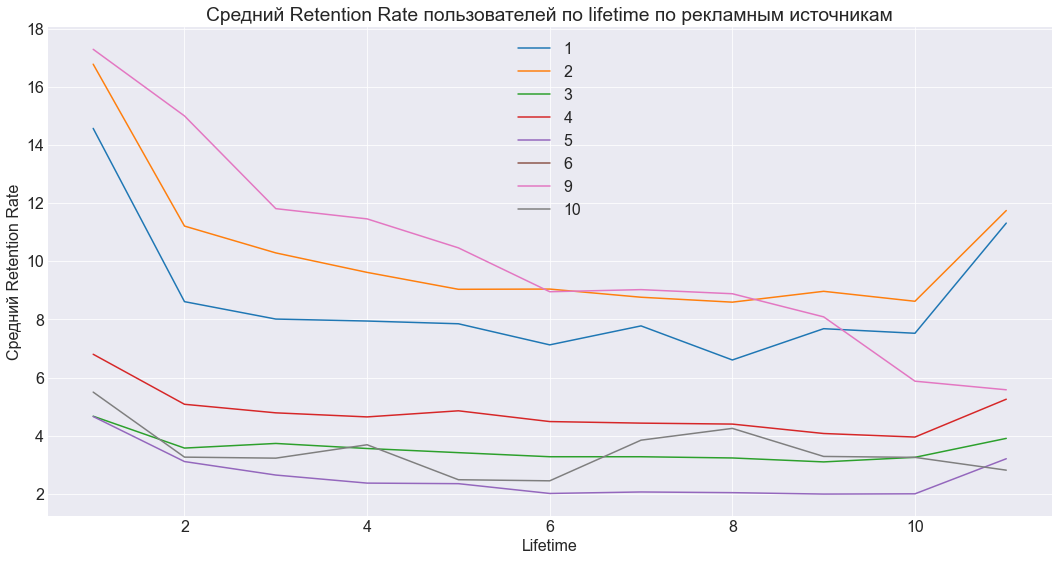

In [103]:
# посмотрим на динамику среднего Retention Rate по времени "жизни" когорты по рекламным источникам
cohorts_source = visits.groupby(['source_id',
                                 'first_session_month',
                                 'cohort_lifetime'])\
                       .agg({'uid':'nunique'})\
                       .reset_index()
initial_users_count_source = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['source_id',
                                                                                     'first_session_month',
                                                                                     'uid']]
initial_users_count_source = initial_users_count_source.rename(columns = {'uid':'cohort_users'})
cohorts_source = cohorts_source.merge(initial_users_count_source,
                                      on = ['source_id',
                                            'first_session_month'])
cohorts_source['retention_rate'] = cohorts_source['uid'] / cohorts_source['cohort_users']
retention_rate_mean_source = cohorts_source.groupby(['source_id',
                                                     'cohort_lifetime'])['retention_rate']\
                                           .mean() * 100
retention_rate_mean_source = retention_rate_mean_source.reset_index()
fig, ax = plt.subplots()
ax.set(title = 'Средний Retention Rate пользователей по lifetime по рекламным источникам',
       xlabel = 'Lifetime',
       ylabel = 'Средний Retention Rate')
for source in retention_rate_mean_source.query('source_id !=7')['source_id'].unique():
    ax.plot(retention_rate_mean_source.query('source_id == @source')['cohort_lifetime'][1:12],
            retention_rate_mean_source.query('source_id == @source')['retention_rate'][1:12],
            label = source )
ax.legend()
plt.show()

Средний коэффициент удержания Retention Rate с течением "жизни" когорт снижается у пользователей, пришедших на сайт с помощью всех рекламных источников.

In [104]:
# рассчитаем средний Retention Rate по первому месяцу "жизни" когорты по категориям устройств
retention_metrics_source = retention_rate_mean_source.query('cohort_lifetime == 1')\
                                                     .groupby('source_id')['retention_rate']\
                                                     .mean()\
                                                     .reset_index()\
                                                     .rename(columns = {'retention_rate':'avg_retention_rate_first_pct'})
retention_metrics_source

source_id  avg_retention_rate_first_pct
0          1                         14.58
1          2                         16.79
2          3                          4.67
3          4                          6.80
4          5                          4.66
5          7                        100.00
6          9                         17.30
7         10                          5.50

Из двух рекламных источников с наибольшим привлечением пользователей - третьего и четвертого - коэффициент удержания Retention Rate по первому месяцу "жизни" когорты у третьего источника очень низок - всего 4,67%. Более 15% пользователей, привлеченных с использованием девятого, второго и первого рекламных источников, возвращаются на сайт в первый месяц "жизни" когорты.

#### Вывод

In [105]:
# сведем в одну таблицу все рассчитанные продуктовые метрики
product_metrics_all = pd.concat([visits_metrics_all,
                                 sessions_metrics_all,
                                 asl_metrics_all,
                                 retention_metrics_all],
                                axis = 1)
product_metrics_all_tr = product_metrics_all.transpose()
product_metrics_all_tr

all
n_users                      228,168.00
dau                              907.00
wau                            5,621.00
mau                           23,228.00
sticky_factor_wau_pct             16.15
sticky_factor_mau_pct              3.91
avg_sessions_per_day             987.00
avg_sessions_per_user_day          1.08
asl_sec                           60.00
avg_retention_rate_first_pct       6.52

In [106]:
# сведем в одну таблицу все рассчитанные продуктовые метрики по категориям устройств
product_metrics_device = visits_metrics_device.merge(sessions_metrics_device, on = 'device')\
                                              .merge(asl_metrics_device, on = 'device')\
                                              .merge(retention_metrics_device, on = 'device')
product_metrics_device.set_index('device', inplace = True)
product_metrics_device_tr = product_metrics_device.transpose()
product_metrics_device_tr

device                       desktop  touch
n_users                       164522  71345
dau                              659    252
wau                             4061   1607
mau                            16724   6825
sticky_factor_wau_pct          16.23  15.68
sticky_factor_mau_pct           3.94   3.69
avg_sessions_per_day             721    267
avg_sessions_per_user_day       1.09   1.05
asl_sec                           60     60
avg_retention_rate_first_pct    6.80   6.20

In [107]:
# сведем в одну таблицу все рассчитанные продуктовые метрики по рекламным источникам
product_metrics_source = visits_metrics_source.merge(sessions_metrics_source, on = 'source_id')\
                                              .merge(asl_metrics_source, on = 'source_id')\
                                              .merge(retention_metrics_source, on = 'source_id')
product_metrics_source.set_index('source_id', inplace = True)
product_metrics_source_tr = product_metrics_source.transpose()
product_metrics_source_tr

source_id                        1      2      3      4      5      7     9   \
n_users                       18999  26245  74756  83524  56974     34  9264   
dau                              80    120    232    275    175      1    36   
wau                             456    703   1536   1797   1146      1   233   
mau                            1818   2752   6758   7765   5017      2   987   
sticky_factor_wau_pct         17.54  17.07  15.10  15.30  15.27 100.00 15.45   
sticky_factor_mau_pct          4.40   4.36   3.43   3.54   3.49  50.00  3.65   
avg_sessions_per_day             91    131    238    300    181      1    22   
avg_sessions_per_user_day      1.15   1.08   1.01   1.02   1.04   1.00  1.00   
asl_sec                          60     60     60     60     60    120    60   
avg_retention_rate_first_pct  14.58  16.79   4.67   6.80   4.66 100.00 17.30   

source_id                       10  
n_users                       8067  
dau                             26  
wau                            163  
mau                            707  
sticky_factor_wau_pct        15.95  
sticky_factor_mau_pct         3.68  
avg_sessions_per_day            23  
avg_sessions_per_user_day     1.01  
asl_sec                         60  
avg_retention_rate_first_pct  5.50

###### Сколько людей пользуются в день, неделю, месяц?    
<br>1. Общее количество уникальных пользователей - 228168, среднее количество уникальных пользователей в день - 907, в неделю - 5621, в месяц - 23228, вовлечённость недельной аудитории - 16,15%, месячной - 3,91%. По всей совокупности уникальных пользователей со стационарными устройствами более чем в 2,3 раза больше, чем с мобильными, в связи с чем у них выше и все показатели пользовательской активности. Показатели вовлечённости пользователей у посетителей сайта со стационарных устройств незначительно выше, чем с мобильных.  Наибольшее общее количество уникальных пользователей привлечено на сайт при помощи четвертого и третьего рекламных источников, соответственно у этих источников выше и все показатели пользовательской активности. Через шестой и седьмой рекламные источники пользователи практически не привлекались. Показатели вовлечённости аудитории выше у первого и второго рекламных источников. Имеются пользователи, которые для посещения сайта использовали как стационарные, так и мобильные устройства, а также посещали сайт из разных рекламных источников.  
<br>2. Динамика количества уникальных пользователей в день очень неравномерна, на графике имеются характерные "зубцы", которые свидетельствуют о разном распределении пользователей по дням недели - в выходные дни количество уникальных пользователей на сайте падает, наибольшее количество таких пользователей по четвергам. Имеется значительный "всплеск" привлечения уникальных пользователей в конце декабря 2017 года, вероятнее всего связанный с новогодними праздниками. Кроме того есть небольшие "всплески" в начале октября 2017 года и середине марта 2018 года. В свою очередь "спад" отмечался в начале августа 2017 года и конце марта 2018 года. Наибольшее количество уникальных пользователей было привлечено на сайт в ноябре 2017 года, после которого их количество неуклонно снижалось, наименьшее - в августе 2017 года.   
###### Сколько сессий в день?
<br>1. Среднее количество сессий в день - 987, в день на одного пользователя - 1,08. Среднее количество сессий в день у пользователей со стационарными устройствами более чем в 2,7 раза больше, чем с мобильными, а среднее количство сессий в день на одного пользователя у них выше совсем незначительно - всего на 4%. Среднее количество сессий в день наибольшее у пользователей из третьего и четвертого рекламных источников, однако показатели количества сессий в день на одного пользователя иные. Здесь наилучшие значения этого показателя у пользователей из первого источника. У третьего и четвертого рекламных источников, при помощи которых пользователи посещали сайт чаще, количество сессий в день на одного пользователя очень мала.   
<br>2. Имеется заметный "всплеск" количества сессий в день в декабре 2017 года, вероятнее всего связанный с новогодними праздниками. Также был небольшой "всплеск" в середине июля 2017 года, середине февраля, ближе к концу марта, в конце мая 2018 года. В то же время в конце марта - начале апреля 2018 года имеется заметный "спад", вероятнее всего связанный с техническими неполадками на сайте. Динамика ежедневного количества сессий, приходящихся на одного пользователя,  близка к динамике количества ежедневных сессий с аналогичными "всплесками" и "спадами". Колебания количества сессий в день значительно выше при использовании стационарных устройств, кроме того, ни в один из дней не было превышения случаев использования мобильных устройств для посещения сайта по сравнению со стационарными. В динамике ежедневного количества сессий, приходящихся на одного пользователя, по категориям устройств наблюдаются более значительные колебания этого показателя у пользователей мобильных устройств, кроме того есть дни, когда количество сессий, приходящихся на одного пользователя, выше именно у посетителей сайта из мобильных устройств. Динамика количества сессий в день по рекламным источникам очень похожа, декабрьский "пик" при этом достигнут, в основном, благодаря пользователям, пришедшим из третьего и четвертого рекламных источников. Динамика количества сессий в день на одного пользователя по рекламным источникам подвержена более значительным колебаниям, при этом у первого рекламного источника имеется самое большое количество "всплесков" этого показателя. 
###### Сколько длится одна сессия?    
Распределение продолжительности сессий очень неравномерно, наибольшее количество сессий с короткой продолжительностью, хотя имеются и весьма продолжительные сессии. По этой причине показателем средней продолжительности сессии ASL будет являться мода, которая равна 60 секундам, в разрезе категорий устройств и рекламных источников значение средней продолжительности сессии ASL  соответствует значению этого показателя по всей совокупности за исключением шестого и седьмого рекламных источников, при помощи которых привлечено совсем небольшое количество пользователей.   
###### Как часто люди возвращаются?  
<br>1. Показатель возврата пользователя к продукту Retention Rate очень низок - ни в один из месяцев "жизни" когорт коэффициент удержания не был выше 10%.  Самые активные пользователи - впервые посетившие сайт в июне 2017 года, с течением времени Retention Rate у этой когорты не был менее 4%. Средний коэффициент удержания Retention Rate с течением "жизни" когорт неуклонно снижается, за исключением 11 месяца, где всего одна когорта с самыми активными пользователями, впервые посетившими сайт в июне 2017 года. Средний коэффициент удержания Retention Rate с течением "жизни" когорт снижается у пользователей и по категориям устройств, и по рекламным источникам.   
<br>2. Retention Rate в первый месяц "жизни" убывает по когортам, начиная с когорты января 2018 года. Средний коэффициент удержания Retention Rate по первому месяцу "жизни" когорты составляет 6,52%, при этом у пользователей со стационарными устройствами он немного выше, чем у пользователей с мобильными. Из двух рекламных источников с наибольшим привлечением пользователей - третьего и четвертого - коэффициент удержания Retention Rate по первому месяцу "жизни" когорты у третьего источника очень низок - всего 4,67%. Более 15% пользователей, привлеченных с использованием девятого, второго и первого рекламных источников, возвращаются на сайт в первый месяц "жизни" когорты.           
<br>3. Более 90% пользователей не возвращаются на сайт в первый месяц "жизни" когорты. В основном показатели Churn Rate отрицательные, положительных значений очень мало, что свидетельствует о том, что случаев возврата пользователей в следующем месяце по сравнению с предыдущим совсем немного. Наибольшее количество положительных значений Churn Rate у когорты пользователей июня 2017 года. Средний коэффициент возврата Churn Rate с 3 месяца жизни когорт остается практически неизменным, за исключением 11 месяца, где всего одна когорта с самыми активными пользователями, впервые посетившими сайт в июне 2017 года. 

#### Торговые метрики
<a name="trading"></a>

##### Когда люди начинают покупать?  

###### По всей совокупности 

In [108]:
# определим дату первой покупки пользователями
first_order = orders.groupby('uid')\
                    .agg({'order_ts':'min'})\
                    .rename(columns = {'order_ts':'first_order'})\
                    .reset_index()
first_order.head()

uid         first_order
0   313578113262317 2018-01-03 21:51:00
1  1575281904278712 2017-06-03 10:13:00
2  2429014661409475 2017-10-11 18:33:00
3  2464366381792757 2018-01-28 15:54:00
4  2551852515556206 2017-11-24 10:14:00

In [109]:
# посчитаем количество строк в полученной таблице
len(first_order)

36522

In [110]:
# добавим в таблицу столбец с первой сессией пользователей
orders_first = first_order.merge(first_session,
                                 on = 'uid')
orders_first.head()

uid         first_order       first_session
0   313578113262317 2018-01-03 21:51:00 2017-09-18 22:49:00
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00
2  2429014661409475 2017-10-11 18:33:00 2017-10-11 17:14:00
3  2464366381792757 2018-01-28 15:54:00 2018-01-27 20:10:00
4  2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00

In [111]:
# проверим количество строк в таблице
len(first_order)

36522

In [112]:
# посчитаем время в днях, прошедшее от первой сессии до первой покупки
orders_first['order_session_days'] = (orders_first['first_order'] - orders_first['first_session']).dt.days
orders_first.head()

uid         first_order       first_session  \
0   313578113262317 2018-01-03 21:51:00 2017-09-18 22:49:00   
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00   
2  2429014661409475 2017-10-11 18:33:00 2017-10-11 17:14:00   
3  2464366381792757 2018-01-28 15:54:00 2018-01-27 20:10:00   
4  2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00   

   order_session_days  
0                 106  
1                   0  
2                   0  
3                   0  
4                   0

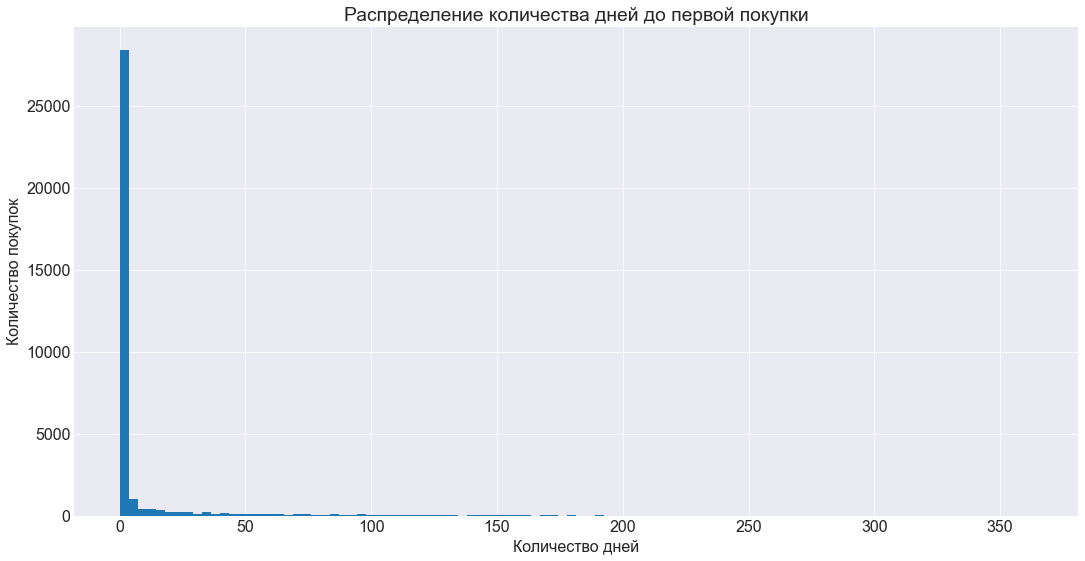

In [113]:
# посмотрим на распределение количества дней до первой покупки
fig, ax = plt.subplots()
ax.set(title = 'Распределение количества дней до первой покупки',
       xlabel = 'Количество дней',
       ylabel = 'Количество покупок')
ax.hist(orders_first['order_session_days'],
        bins = 100)
plt.show()

Распределение количества дней до первой покупки неравномерно, в основном покупки совершаются достаточно быстро после первого посещения сайта, хотя имеются и весьма продолжительные периоды задержки. В качестве меры центральной тенденции, которая лучше всего отразит количество дней до первой покупки, будем использовать моду.

In [114]:
# рассчитаем моду количества дней до первой покупки
order_session_days_mode = int(orders_first['order_session_days'].mode())
d = {'avg_order_session_days': order_session_days_mode}
order_session_metrics_all = pd.DataFrame(data = d,
                                         index = ['all'])
order_session_metrics_all

avg_order_session_days
all                       0

В основном первые покупки совершаются пользователями в первый день посещения сайта.

In [115]:
# добавим в таблицу столбец со временем в часах, прошедшим от первой сессии до первой покупки
orders_first['order_session_hours'] = orders_first['first_order'] - orders_first['first_session']
orders_first['order_session_hours'] = (orders_first['order_session_hours'] / np.timedelta64(1,'h')).round(0)\
                                                                                                   .astype('int')
orders_first.head()

uid         first_order       first_session  \
0   313578113262317 2018-01-03 21:51:00 2017-09-18 22:49:00   
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00   
2  2429014661409475 2017-10-11 18:33:00 2017-10-11 17:14:00   
3  2464366381792757 2018-01-28 15:54:00 2018-01-27 20:10:00   
4  2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00   

   order_session_days  order_session_hours  
0                 106                 2567  
1                   0                    0  
2                   0                    1  
3                   0                   20  
4                   0                    0

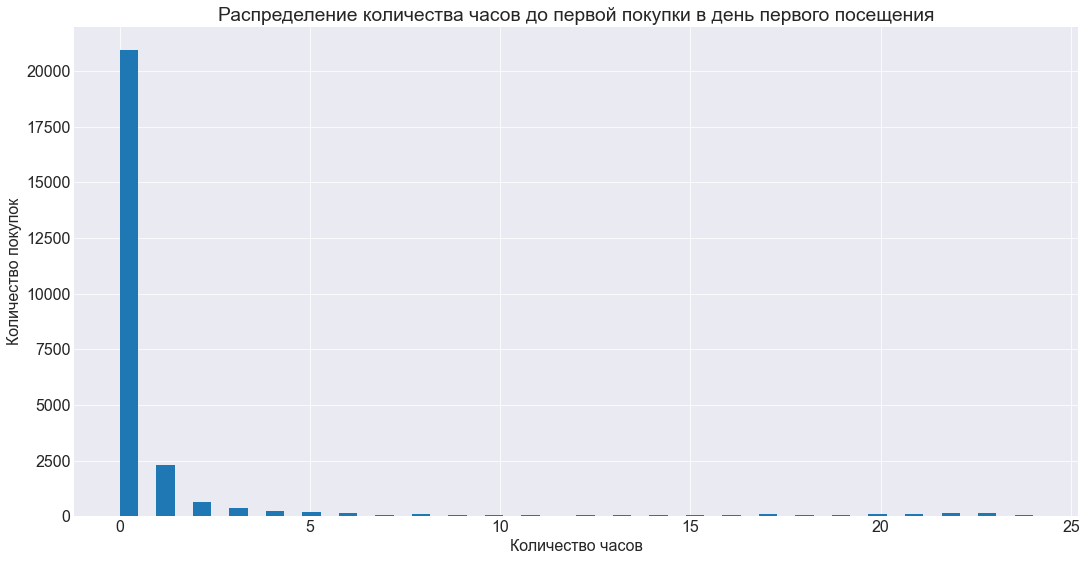

In [116]:
# посмотрим на распределение количества часов до первой покупки в день первого посещения
fig, ax = plt.subplots()
ax.set(title = 'Распределение количества часов до первой покупки в день первого посещения',
       xlabel = 'Количество часов',
       ylabel = 'Количество покупок')
ax.hist(orders_first.query('order_session_days == 0')['order_session_hours'],
        bins = 50)
plt.show()

В основном первые покупки совершаются пользователями в течение первого часа первого посещения сайта.

In [117]:
# добавим в таблицу столбцы с категориями устройств и идентификаторами рекламных источников
orders_first = orders_first.merge(visits,
                                  on = ['uid',
                                        'first_session'])
orders_first = orders_first.query('first_session == session_start_ts')\
                           .reset_index()
orders_first = orders_first[['uid',
                             'device',
                             'source_id',
                             'first_order',
                             'first_session',
                             'order_session_days',
                             'order_session_hours']]
orders_first.head()

uid   device  source_id         first_order  \
0   313578113262317  desktop          2 2018-01-03 21:51:00   
1  1575281904278712    touch         10 2017-06-03 10:13:00   
2  2429014661409475  desktop          3 2017-10-11 18:33:00   
3  2464366381792757  desktop          5 2018-01-28 15:54:00   
4  2551852515556206  desktop          5 2017-11-24 10:14:00   

        first_session  order_session_days  order_session_hours  
0 2017-09-18 22:49:00                 106                 2567  
1 2017-06-03 10:13:00                   0                    0  
2 2017-10-11 17:14:00                   0                    1  
3 2018-01-27 20:10:00                   0                   20  
4 2017-11-24 10:14:00                   0                    0

In [118]:
# проверим количество строк в таблице
len(first_order)

36522

###### По категориям устройств 

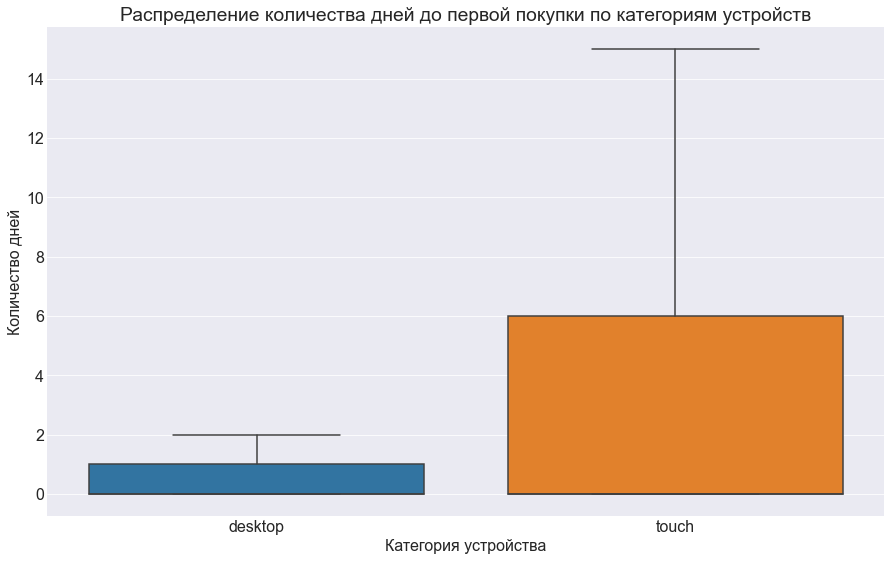

In [119]:
# посмотрим на распределение количества дней до первой покупки по категориям устройств
fig, ax = plt.subplots(figsize=(15, 9))
plt.title('Распределение количества дней до первой покупки по категориям устройств')
ax = sns.boxplot(x = 'device',
                 y = 'order_session_days',
                 data = orders_first,
                 showfliers = False)
plt.xlabel('Категория устройства')
plt.ylabel('Количество дней')
plt.show()

Пользователям мобильных устройств требуется больше времени, чтобы совершить покупку после первого посещения (для 75% пользователей устройств это период до 6 дней). Это может быть связано с неудобством совершения покупки с мобильной версии сайта.

In [120]:
# рассчитаем моду количества дней до первой покупки по категориям устройств
order_session_metrics_device = orders_first.groupby('device')['order_session_days']\
                                           .apply(lambda x: x.mode().iloc[0])\
                                           .reset_index()\
                                           .rename(columns = {'order_session_days':'avg_order_session_days'})
order_session_metrics_device

device  avg_order_session_days
0  desktop                       0
1    touch                       0

Показатель среднего количества дней до первой покупки по категориям устройств соответствует общему показателю.

###### По рекламным источникам

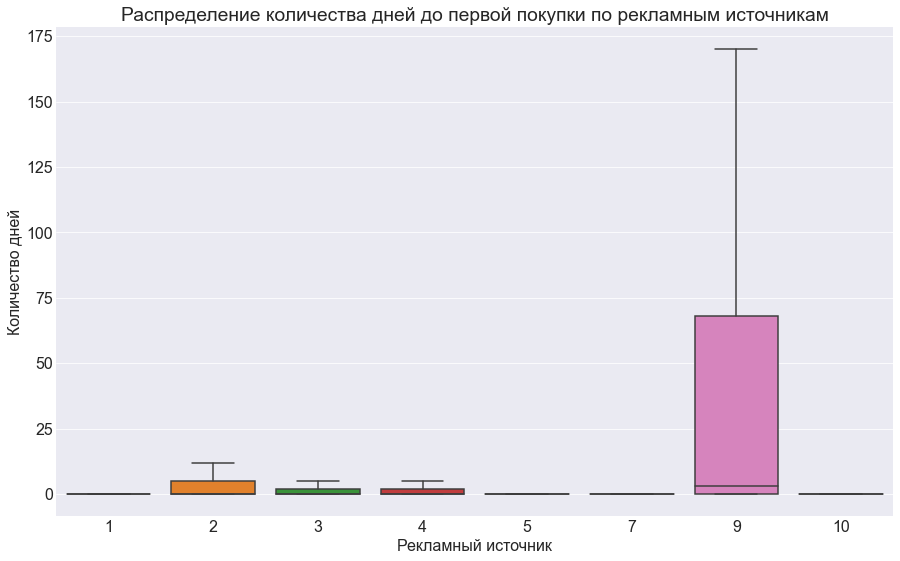

In [121]:
# посмотрим на распределение количества дней до первой покупки по рекламным источникам
fig, ax = plt.subplots(figsize=(15, 9))
plt.title('Распределение количества дней до первой покупки по рекламным источникам')
ax = sns.boxplot(x = 'source_id',
                 y = 'order_session_days',
                 data = orders_first,
                 showfliers = False)
plt.xlabel('Рекламный источник')
plt.ylabel('Количество дней')
plt.show()

Самыми "медленными" являются пользователи, привлеченные на сайт при помощи девятого рекламного источника (для 75% пользователей, пришедших из этого источника, требуется до 70 дней, чтобы совершить покупку после первого посещения). Как ранее было установлено у этого рекламного источника самый высокий средний коэффициент удержания Retention Rate по первому месяцу "жизни" когорты - пользователи возвращаются, чтобы совершить первую покупку.

In [122]:
# рассчитаем моду количества дней до первой покупки по категориям устройств
order_session_metrics_source = orders_first.groupby('source_id')['order_session_days']\
                                           .apply(lambda x: x.mode().iloc[0])\
                                           .reset_index()\
                                           .rename(columns = {'order_session_days':'avg_order_session_days'})
order_session_metrics_source

source_id  avg_order_session_days
0          1                       0
1          2                       0
2          3                       0
3          4                       0
4          5                       0
5          7                       0
6          9                       0
7         10                       0

Показатель среднего количества дней до первой покупки по рекламным источникам соответствует общему показателю.

##### Сколько раз покупают за период?  

###### По всей совокупности 

In [123]:
# посчитаем общую сумму выручки
orders['revenue'].sum()

252053.77999999997

In [124]:
# добавим в таблицу с заказами столбцы с категориями устройств и идентификаторами рекламных источников
orders = orders.merge(visits,
                      on = 'uid')
orders = orders.query('first_session == session_start_ts')\
               .reset_index()
orders = orders[['uid',
                 'device',
                 'source_id',
                 'revenue',
                 'order_ts']]
orders.head()

uid   device  source_id  revenue            order_ts
0  10329302124590727494  desktop          1    17.00 2017-06-01 00:10:00
1  11627257723692907447  desktop          2     0.55 2017-06-01 00:25:00
2  17903680561304213844  desktop          2     0.37 2017-06-01 00:27:00
3  16109239769442553005  desktop          2     0.55 2017-06-01 00:29:00
4  14200605875248379450  desktop          3     0.37 2017-06-01 07:58:00

In [125]:
# проверим общую сумму выручки
orders['revenue'].sum()

252053.78000000003

In [126]:
# добавим в таблицу столбцы с датой, днем недели и месяцем заказа
orders['order_date'] = orders['order_ts'].dt.date
orders['order_month'] = orders['order_ts'].astype('datetime64[M]')
orders['orders_day_of_week']  = orders['order_ts'].dt.weekday
orders.head()

uid   device  source_id  revenue            order_ts  \
0  10329302124590727494  desktop          1    17.00 2017-06-01 00:10:00   
1  11627257723692907447  desktop          2     0.55 2017-06-01 00:25:00   
2  17903680561304213844  desktop          2     0.37 2017-06-01 00:27:00   
3  16109239769442553005  desktop          2     0.55 2017-06-01 00:29:00   
4  14200605875248379450  desktop          3     0.37 2017-06-01 07:58:00   

   order_date order_month  orders_day_of_week  
0  2017-06-01  2017-06-01                   3  
1  2017-06-01  2017-06-01                   3  
2  2017-06-01  2017-06-01                   3  
3  2017-06-01  2017-06-01                   3  
4  2017-06-01  2017-06-01                   3

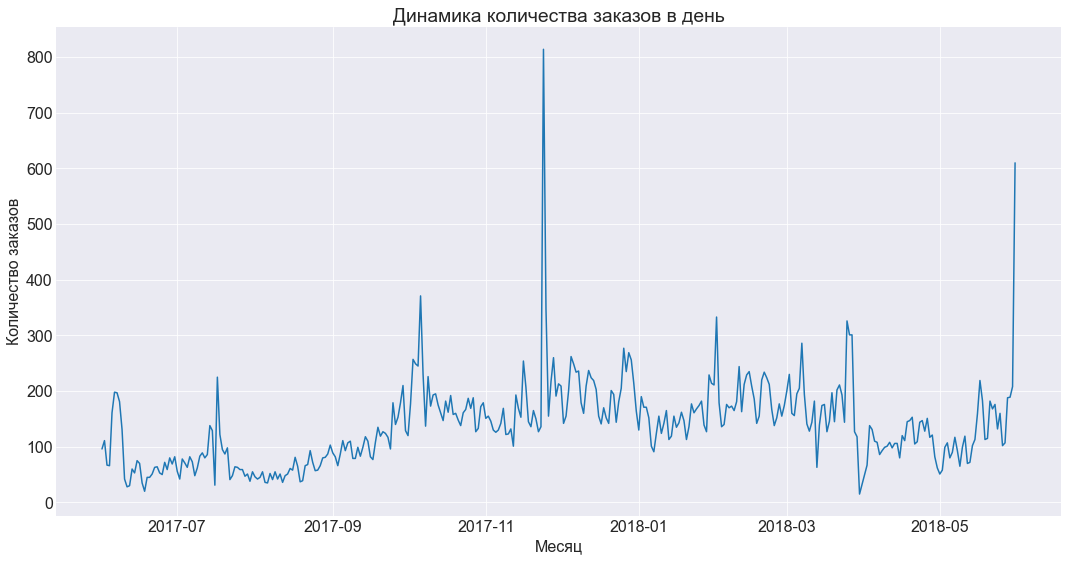

In [127]:
# посмотрим на динамику количества заказов в день
orders_per_day = orders.groupby('order_date')\
                       .agg({'uid': 'count'})\
                       .reset_index()
orders_per_day.columns = ['order_date',
                          'n_orders']
fig, ax = plt.subplots()
plt.title('Динамика количества заказов в день')
ax = sns.lineplot(x = 'order_date',
                  y = 'n_orders',
                  data = orders_per_day)       
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

График динамики количества заказов в день также имеет характерные "зубцы", которые вероятнее всего свидетельствуют о разном распределении количества заказов по дням недели. 

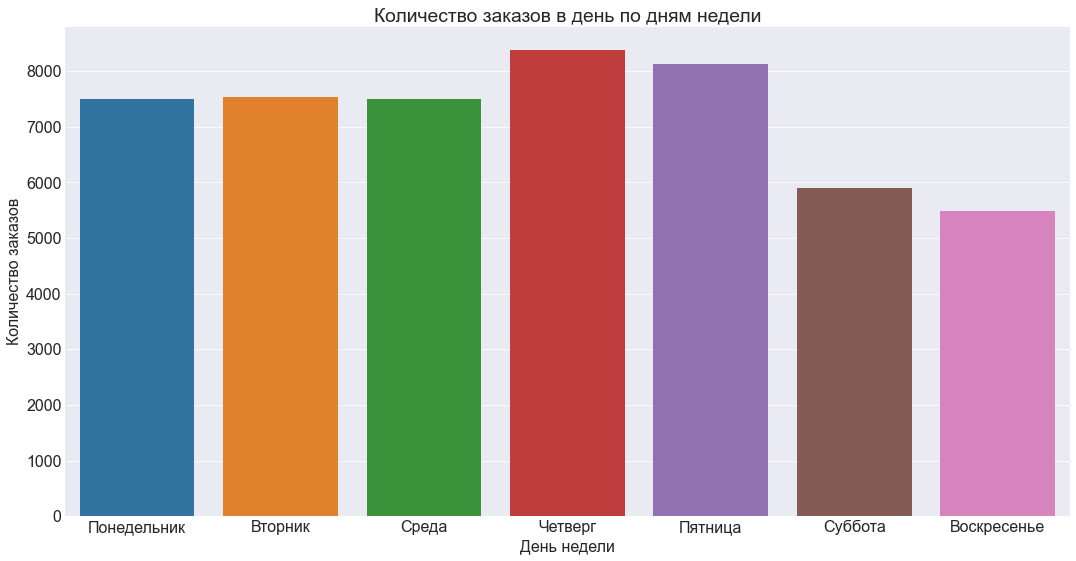

In [128]:
# посмотрим на количество заказов в день по дням недели
orders_per_day_of_week = orders.groupby('orders_day_of_week')\
                               .agg({'uid': 'count'})\
                               .reset_index()
orders_per_day_of_week.columns = ['orders_day_of_week',
                                  'n_orders']
fig, ax = plt.subplots()
plt.title('Количество заказов в день по дням недели')
ax = sns.barplot(x = 'orders_day_of_week',
                 y = 'n_orders',
                 data = orders_per_day_of_week)       
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
ax.set_xticklabels(labels = day_of_week)
plt.show()

Количество заказов, также, как и количество посещений, в выходные дни снижается.

In [129]:
# посчитаем показатели количества заказов
n_visits = visits['uid'].agg('count')
n_orders = orders['uid'].agg('count')
ratio_orders = n_orders / n_visits * 100
orders_per_day_mean = round(orders_per_day['n_orders'].mean())
d = {'n_visits': n_visits,
     'n_orders': n_orders,
     'ratio_orders_pct': float(ratio_orders),
     'orders_per_day':orders_per_day_mean}
order_metrics_all = pd.DataFrame(data = d,
                                 index = ['all'])
order_metrics_all

n_visits  n_orders  ratio_orders_pct  orders_per_day
all    359399     50414             14.03             139

Всего 14% посещений сайта связано с осуществлением заказов. В день в среднем осуществлялось 139 заказов.

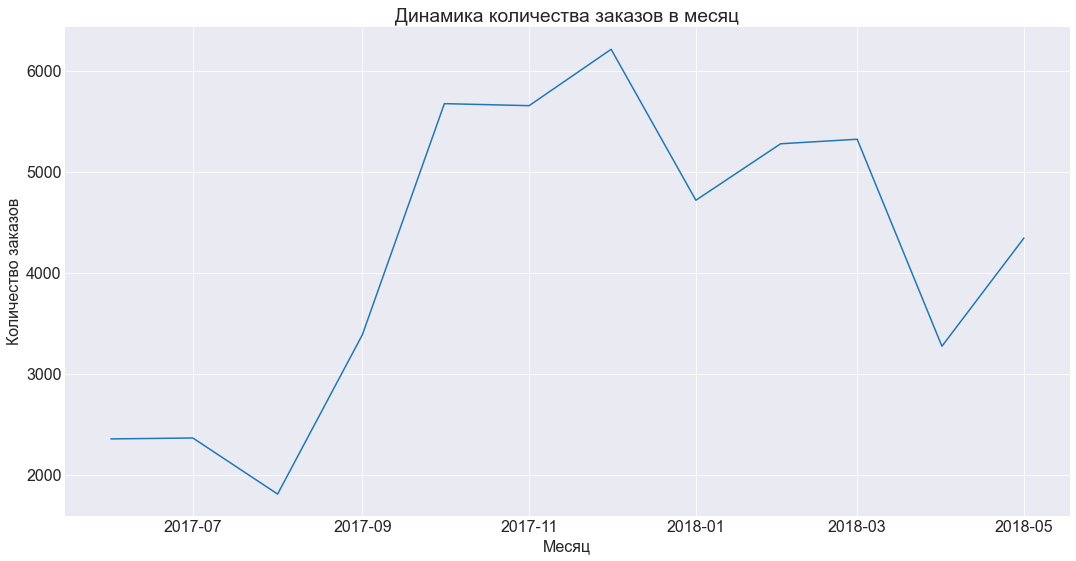

In [130]:
# посмотрим на динамику количества заказов в месяц
orders_per_month = orders.groupby('order_month')\
                         .agg({'uid': 'count'})\
                         .reset_index()
orders_per_month.columns = ['order_month',
                          'n_orders']
fig, ax = plt.subplots()
plt.title('Динамика количества заказов в месяц')
ax = sns.lineplot(x = 'order_month',
                  y = 'n_orders',
                  data = orders_per_month)       
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Наименьшее количество заказов было осуществлено в августе 2017 года, после чего начался их рост, достигший максимума в декабре 2017 года. После этого количество заказов в месяц то росло, то снижалось.

In [131]:
# посчитаем среднее количество заказов в месяц
order_metrics_all['orders_per_month'] = round(orders_per_month['n_orders'].mean())
order_metrics_all

n_visits  n_orders  ratio_orders_pct  orders_per_day  orders_per_month
all    359399     50414             14.03             139              4201

В месяц в среднем осуществляется 4201 заказ.

###### По категориям устройств 

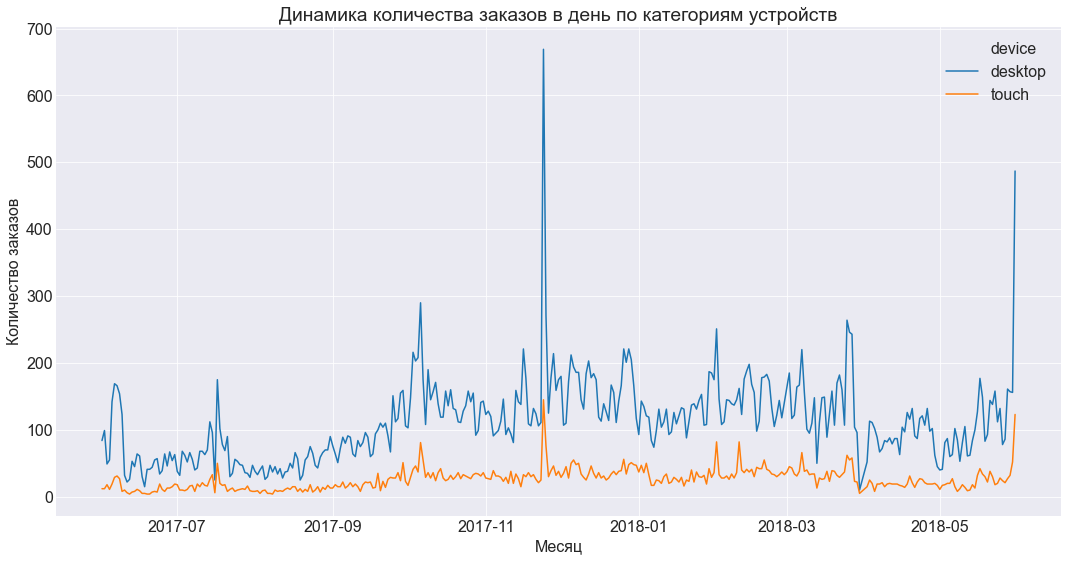

In [132]:
# посмотрим на динамику количества заказов в день по категориям устройств
orders_per_day_device = orders.groupby(['device',
                                        'order_date'])\
                              .agg({'uid': 'count'})\
                              .reset_index()
orders_per_day_device.columns = ['device',
                                 'order_date',
                                 'n_orders']
fig, ax = plt.subplots()
plt.title('Динамика количества заказов в день по категориям устройств')
ax = sns.lineplot(x = 'order_date',
                  y = 'n_orders',
                  data = orders_per_day_device,
                  hue = 'device')       
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Количество заказов со стационарных устройств подвержено большим колебаниям, чем с мобильных. Декабрьский "всплеск" количества заказов, вероятнее всего связанный с новогодними праздниками, был достигнут в основном за счет покупателей, использующих стационарные устройства.

In [133]:
# посчитаем показатели количества заказов по категориям устройств
order_metrics_device = visits.groupby('device')\
                                     .agg({'uid': 'count'})\
                                     .reset_index()\
                                     .rename(columns = {'uid':'n_visits'})
buyers_device = orders_per_day_device.groupby('device')\
                                     .agg({'n_orders': 'sum'})\
                                     .reset_index()
order_metrics_device = order_metrics_device.merge(buyers_device,
                                                  on = 'device')
order_metrics_device['ratio_orders_pct'] = order_metrics_device['n_orders'] / order_metrics_device['n_visits'] * 100
orders_per_day_device_mean = orders_per_day_device.groupby('device')['n_orders']\
                                                  .mean()\
                                                  .reset_index()\
                                                  .rename(columns = {'n_orders':'orders_per_day'})
orders_per_day_device_mean['orders_per_day'] = round(orders_per_day_device_mean['orders_per_day']).astype('int')
order_metrics_device = order_metrics_device.merge(orders_per_day_device_mean,
                                                  on = 'device')
order_metrics_device

device  n_visits  n_orders  ratio_orders_pct  orders_per_day
0  desktop    262566     40926             15.59             113
1    touch     96833      9488              9.80              26

Более 15% посещений сайта со стационарных устройств связано с осуществлением заказов. У пользователей мобильных устройств "холостых" посещений значительно больше (заказы осуществляются менее, чем в 10% посещений). Среднее количество заказов в день более чем в 4 раза больше у покупателей со стационарными устройствами.

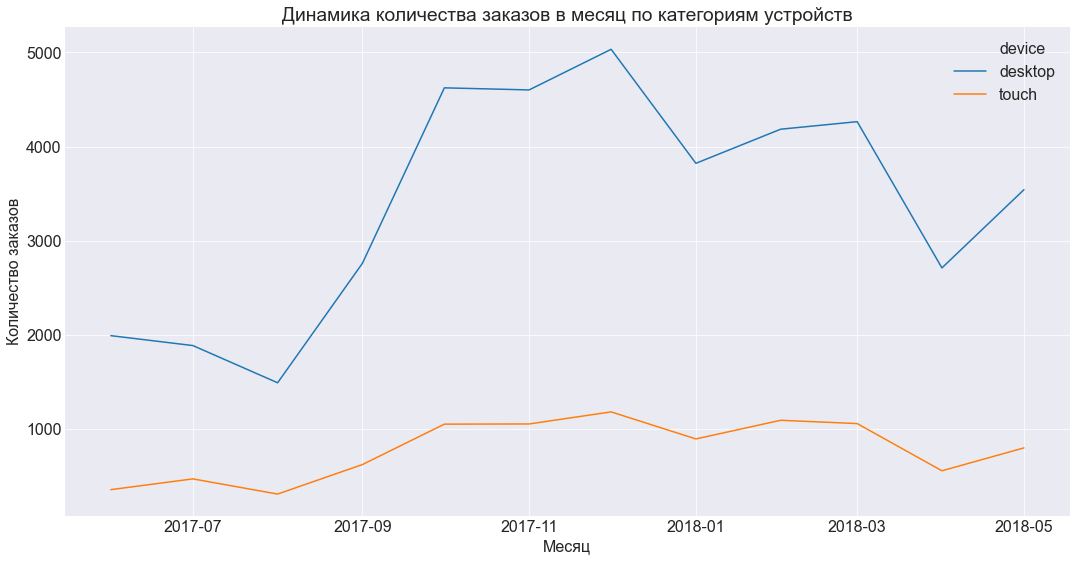

In [134]:
# посмотрим на динамику количества заказов в месяц по категориям устройств
orders_per_month_device = orders.groupby(['device',
                                          'order_month'])\
                                .agg({'uid': 'count'})\
                                .reset_index()
orders_per_month_device.columns = ['device',
                                   'order_month',
                                   'n_orders']
fig, ax = plt.subplots()
plt.title('Динамика количества заказов в месяц по категориям устройств')
ax = sns.lineplot(x = 'order_month',
                  y = 'n_orders',
                  data = orders_per_month_device,
                  hue = 'device')       
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Количество заказов в месяц у пользователей стационарных устройств подвержено большим колебаниям, тогда как количество заказов у пользователей мобильных устройств из месяца в месяц практически не меняется.

In [135]:
# посчитаем среднее количество заказов в месяц по категориям устройств
orders_per_month_device_mean = orders_per_month_device.groupby('device')['n_orders']\
                                                      .mean()\
                                                      .reset_index()\
                                                      .rename(columns = {'n_orders':'orders_per_month'})
orders_per_month_device_mean['orders_per_month'] = round(orders_per_month_device_mean['orders_per_month']).astype('int')
order_metrics_device = order_metrics_device.merge(orders_per_month_device_mean,
                                                  on = 'device')
order_metrics_device

device  n_visits  n_orders  ratio_orders_pct  orders_per_day  \
0  desktop    262566     40926             15.59             113   
1    touch     96833      9488              9.80              26   

   orders_per_month  
0              3410  
1               791

Среднее количество заказов в месяц также более чем в 4 раза больше у покупателей со стационарными устройствами.

###### По рекламным источникам 

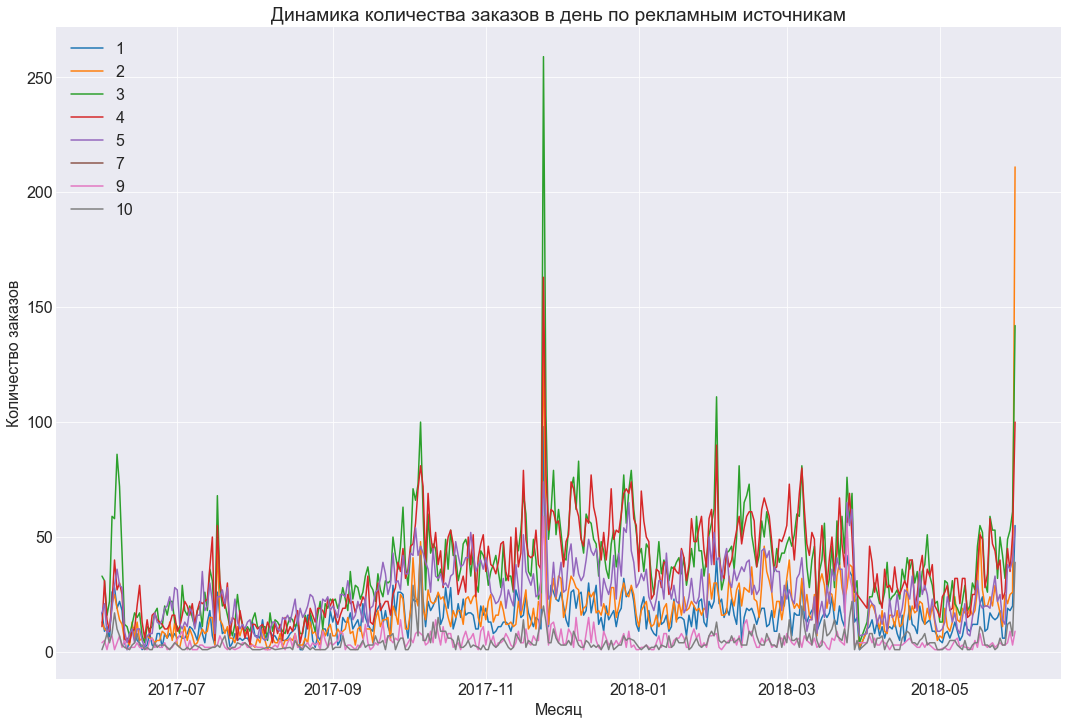

In [136]:
# посмотрим на динамику количества заказов в день по рекламным источникам
orders_per_day_source = orders.groupby(['source_id',
                                        'order_date'])\
                              .agg({'uid': 'count'})\
                              .reset_index()
orders_per_day_source.columns = ['source_id',
                                 'order_date',
                                 'n_orders']
orders_per_day_source
fig, ax = plt.subplots(figsize = (18, 12))
ax.set(title = 'Динамика количества заказов в день по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Количество заказов')
for source in orders_per_day_source['source_id'].unique():
    ax.plot(orders_per_day_source.query('source_id == @source')['order_date'],
            orders_per_day_source.query('source_id == @source')['n_orders'],
            label = source)    
ax.legend()
plt.show()

Больше всего заказов осуществляется пользователями, посетившими сайт при помощи четвертого и третьего рекламного источника. Декабрьский "всплеск" количества заказов, вероятнее всего связанный с новогодними праздниками, был обеспечен в основном именно этими источниками.

In [137]:
# посчитаем показатели количества заказов по рекламным источникам
order_metrics_source = visits.groupby('source_id')\
                                     .agg({'uid': 'count'})\
                                     .reset_index()\
                                     .rename(columns = {'uid':'n_visits'})
buyers_source = orders_per_day_source.groupby('source_id')\
                                     .agg({'n_orders': 'sum'})\
                                     .reset_index()
order_metrics_source = order_metrics_source.merge(buyers_source,
                                                  on = 'source_id')
order_metrics_source['ratio_orders_pct'] = order_metrics_source['n_orders'] / order_metrics_source['n_visits'] * 100
orders_per_day_source_mean = orders_per_day_source.groupby('source_id')['n_orders']\
                                                  .mean()\
                                                  .reset_index()\
                                                  .rename(columns = {'n_orders':'orders_per_day'})
orders_per_day_source_mean['orders_per_day'] = round(orders_per_day_source_mean['orders_per_day']).astype('int')
order_metrics_source = order_metrics_source.merge(orders_per_day_source_mean,
                                                  on = 'source_id')
order_metrics_source

source_id  n_visits  n_orders  ratio_orders_pct  orders_per_day
0          1     34121      5223             15.31              14
1          2     47626      6392             13.42              18
2          3     85610     13289             15.52              37
3          4    101793     12894             12.67              36
4          5     66905      9406             14.06              26
5          7        36         1              2.78               1
6          9     13277      1647             12.40               5
7         10     10025      1562             15.58               5

У пользователей, посетивших сайт при помощи первого, третьего и десятого рекламных источников, более 15% посещений сайта связано с осуществлением заказов. У седьмого источника лишь одно посещение из 36 привело к осуществлению заказа. Наибольшее среднее количество заказов в день у покупателей, пришедших из третьего и четвертого рекламных источников.

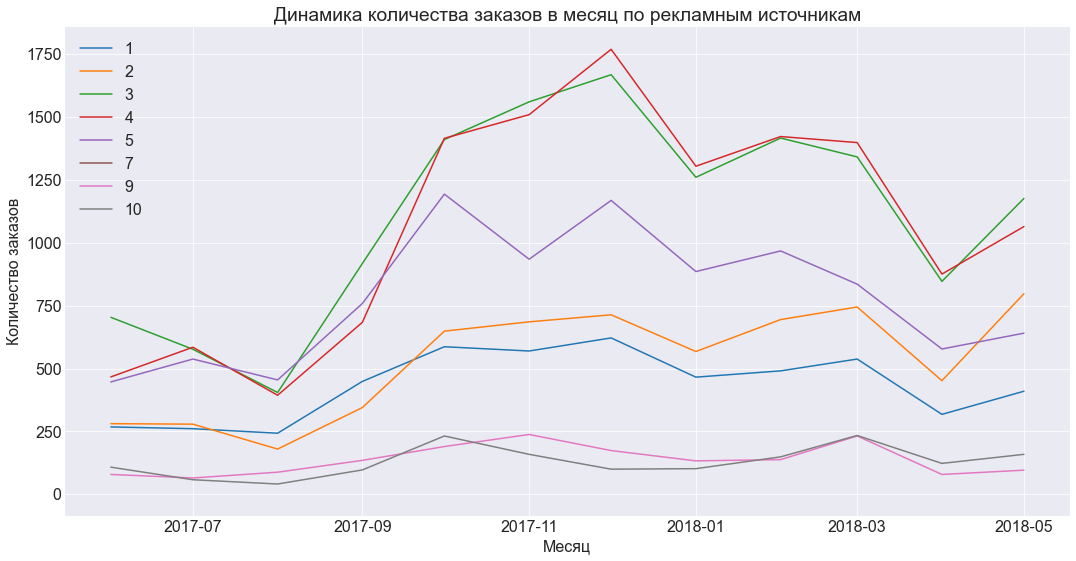

In [138]:
# посмотрим на динамику количества заказов в месяц по по рекламным источникам
orders_per_month_source = orders.groupby(['source_id',
                                          'order_month'])\
                                .agg({'uid': 'count'})\
                                .reset_index()
orders_per_month_source.columns = ['source_id',
                                   'order_month',
                                   'n_orders']
fig, ax = plt.subplots()
ax.set(title = 'Динамика количества заказов в месяц по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Количество заказов')
for source in orders_per_month_source['source_id'].unique():
    ax.plot(orders_per_month_source.query('source_id == @source')['order_month'],
            orders_per_month_source.query('source_id == @source')['n_orders'],
            label = source)
ax.legend()
plt.show()

У самых популярных рекламных источников (третьего и четвертого) рост количества заказов начался с сентября 2017 года, до этого они практически не выделялись на фоне других источников.

In [139]:
# посчитаем среднее количество заказов в месяц по категориям устройств
orders_per_month_source_mean = orders_per_month_source.groupby('source_id')['n_orders']\
                                                      .mean()\
                                                      .reset_index()\
                                                      .rename(columns = {'n_orders':'orders_per_month'})
orders_per_month_source_mean['orders_per_month'] = round(orders_per_month_source_mean['orders_per_month']).astype('int')
order_metrics_source = order_metrics_source.merge(orders_per_month_source_mean,
                                                  on = 'source_id')
order_metrics_source

source_id  n_visits  n_orders  ratio_orders_pct  orders_per_day  \
0          1     34121      5223             15.31              14   
1          2     47626      6392             13.42              18   
2          3     85610     13289             15.52              37   
3          4    101793     12894             12.67              36   
4          5     66905      9406             14.06              26   
5          7        36         1              2.78               1   
6          9     13277      1647             12.40               5   
7         10     10025      1562             15.58               5   

   orders_per_month  
0               435  
1               533  
2              1107  
3              1074  
4               784  
5                 1  
6               137  
7               130

Наибольшее среднее количество заказов в месяц также у покупателей, пришедших из третьего и четвертого рекламных источников.

##### Какой средний чек?   

###### По всей совокупности 

In [140]:
# найдем покупателей, принесших наибольшую выручку
top_buyers = orders.groupby('uid')['revenue']\
                   .sum()\
                   .sort_values(ascending = False)\
                   .head(10)
top_buyers

uid
5539673724080479777    11,810.18
11149926373378902217   10,519.46
17999372575896145244    1,979.33
6731421022966725351     1,450.68
3644482766749211722     1,444.29
9737640335185488211     1,310.71
8539015707073391293     1,240.76
13888745432979765063    1,191.02
1668300487562478408     1,163.63
6268225112727843212     1,158.32
Name: revenue, dtype: float64

In [141]:
# посчитаем долю выручки от двух самых ценных покупателей 
(top_buyers.head(2).sum() / orders['revenue'].sum() * 100).round(1)

8.9

Два покупателя принесли 8,9% всей выручки.

In [142]:
# определим категории устройств и рекламные источники самых ценных покупателей
orders.query('uid == "5539673724080479777" or uid == "11149926373378902217"')\
      .groupby(['device',
                'source_id',
                'order_month'])['revenue']\
      .sum() 

device   source_id  order_month
desktop  2          2017-12-01    1,206.63
                    2018-01-01      117.33
                    2018-02-01    3,176.07
                    2018-03-01    3,990.55
                    2018-04-01      948.44
                    2018-05-01    1,080.44
         5          2017-09-01      578.40
                    2017-11-01      147.88
                    2017-12-01    9,253.70
                    2018-01-01      420.74
                    2018-02-01    1,157.09
                    2018-03-01      146.96
                    2018-04-01      105.41
Name: revenue, dtype: float64

Самые ценные покупатели использовали стационарные устройства, стали пользователями сайта при помощи второго и пятого рекламных источников. Один из покупателей впервые совершил заказ в декабре 2017 года, второй - в сентябре 2017 года. Эти выбивающиеся значения выручки могут повлиять на дальнейшее исследование. Как уже ранее отмечалось, вероятнее всего это корпоративные клиенты, покупавшие билеты для своих работников, либо перекупщики билетов, решившие заработать на наиболее популярных мероприятиях (самые большие суммы этими покупателями потрачены в декабре - Новый год, феврале - 23 февраля, марте - 8 марта).

In [143]:
# посчитаем показатели выручки
total_revenue = orders['revenue'].agg('sum')
mean_revenue = orders['revenue'].agg('mean')
median_revenue = orders['revenue'].agg('median')
n_buyers = orders['uid'].agg('nunique')
orders_per_buyers =  n_orders / n_buyers
d = {'total_revenue': total_revenue,
     'avg_fee': mean_revenue,
     'median_fee': median_revenue,
     'n_buyers':n_buyers,
     'orders_per_buyers':orders_per_buyers}
revenue_metrics_all = pd.DataFrame(data = d,
                                   index = ['all'])
revenue_metrics_all

total_revenue  avg_fee  median_fee  n_buyers  orders_per_buyers
all     252,053.78     5.00        2.50     36522               1.38

Общая выручка составила 252053,78 рублей, средний чек - 5 рублей, медианный в 2 раза ниже - 2,5 рубля. Общее количество покупателей - 36522, в среднем один покупатель совершал 1,38 заказа.

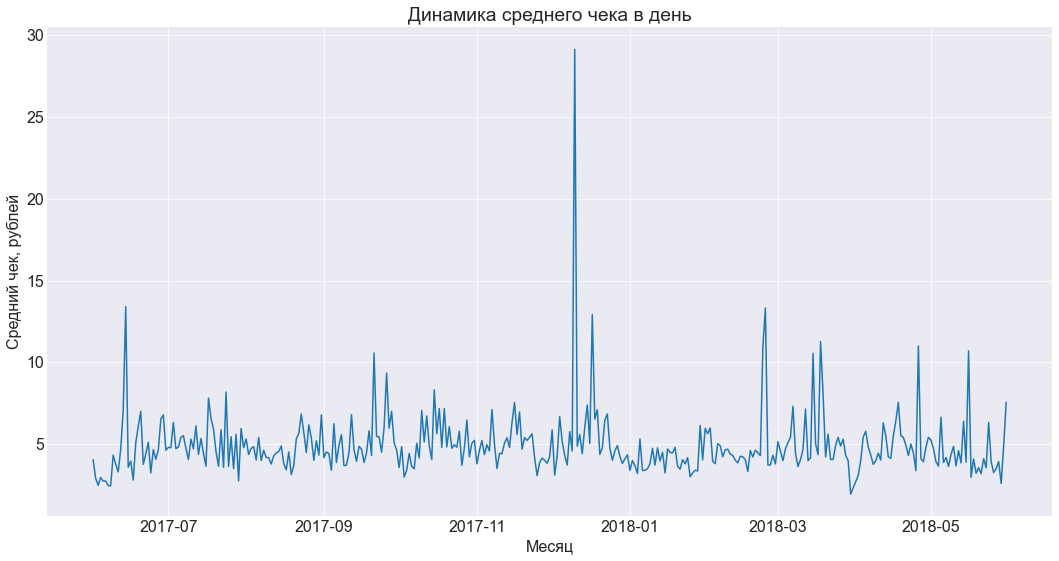

In [144]:
# посмотрим на динамику среднего чека в день
revenue_per_day = orders.groupby('order_date')\
                        .agg({'revenue': ['sum', 'count']})\
                        .reset_index()
revenue_per_day.columns = ['order_date',
                           'revenue',
                           'n_orders']
revenue_per_day['avg_fee'] = revenue_per_day['revenue'] / revenue_per_day['n_orders']
fig, ax = plt.subplots()
plt.title('Динамика среднего чека в день')
ax = sns.lineplot(x = 'order_date',
                  y = 'avg_fee',
                  data = revenue_per_day)       
plt.xlabel('Месяц')
plt.ylabel('Средний чек, рублей')
plt.show()

Есть дни с очень высокими значениями среднего чека, вероятнее всего это связано с разовыми крупными покупками в эти дни. График динамики среднего чека имеет характерные "зубцы", которые вероятнее всего свидетельствуют о его разном распределении по дням недели. Кроме того заметен рост среднего чека перед праздничными днями.

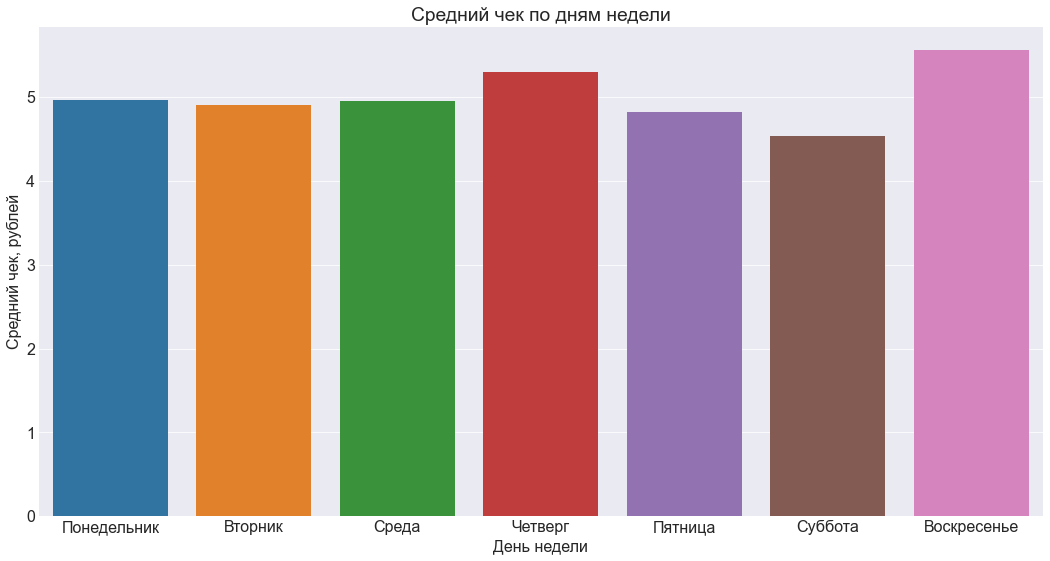

In [145]:
# посмотрим на средний чек по дням недели
revenue_per_day_of_week = orders.groupby('orders_day_of_week')\
                                .agg({'revenue': ['sum', 'count']})\
                                .reset_index()
revenue_per_day_of_week.columns = ['orders_day_of_week',
                                   'revenue',
                                   'n_orders']
revenue_per_day_of_week['avg_fee'] = revenue_per_day_of_week['revenue'] / revenue_per_day_of_week['n_orders']
fig, ax = plt.subplots()
plt.title('Средний чек по дням недели')
ax = sns.barplot(x = 'orders_day_of_week',
                 y = 'avg_fee',
                 data = revenue_per_day_of_week)       
plt.xlabel('День недели')
plt.ylabel('Средний чек, рублей')
ax.set_xticklabels(labels = day_of_week)
plt.show()

Самый низкий средний чек по субботам, а самый высокий - по воскресеньям (день с самым маленьким количеством заказов).

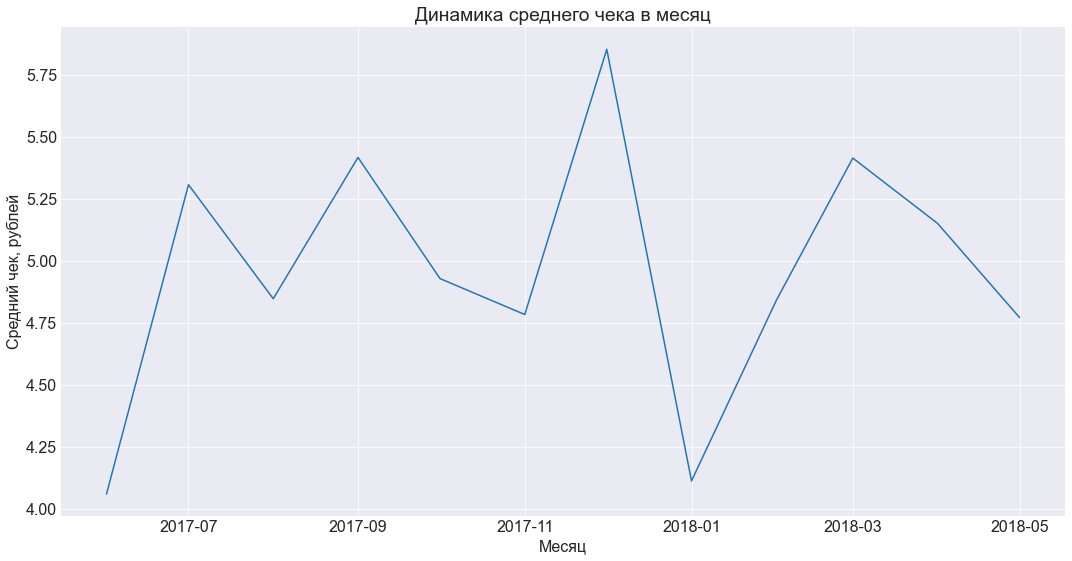

In [146]:
# посмотрим на динамику среднего чека в месяц
revenue_per_month = orders.groupby('order_month')\
                          .agg({'revenue': ['sum', 'count']})\
                          .reset_index()
revenue_per_month.columns = ['order_month',
                           'revenue',
                           'n_orders']
revenue_per_month['avg_fee'] = revenue_per_month['revenue'] / revenue_per_month['n_orders']
fig, ax = plt.subplots()
plt.title('Динамика среднего чека в месяц')
ax = sns.lineplot(x = 'order_month',
                  y = 'avg_fee',
                  data = revenue_per_month)       
plt.xlabel('Месяц')
plt.ylabel('Средний чек, рублей')
plt.show()

Самый высокий средний чек в декабре 2017 года, самый низкий - в июне 2017 года и январе 2018 года (сразу после резкого роста).

###### По категориям устройств 

In [147]:
# посчитаем показатели выручки по категориям устройств
revenue_metrics_device = orders.groupby('device')\
                               .agg({'revenue':['sum', 'mean', 'median'], 'uid':'nunique'})\
                               .reset_index()
revenue_metrics_device.columns = ['device',
                                  'total_revenue',
                                  'avg_fee',
                                  'median_fee',
                                  'n_buyers']
revenue_metrics_device['orders_per_buyers'] = order_metrics_device['n_orders'] / revenue_metrics_device['n_buyers']
revenue_metrics_device

device  total_revenue  avg_fee  median_fee  n_buyers  orders_per_buyers
0  desktop     211,326.35     5.16        2.69     29210               1.40
1    touch      40,727.43     4.29        2.44      7312               1.30

Общая выручка от покупателей со стационарными устройствами в 5 раз больше выручки от покупателей с мобильными устройствами. Средний и медианный чек, а также количество покупателей и среднее количество заказов на одного покупателя также выше у пользователей, заходящих на сайт со стационарных устройств.

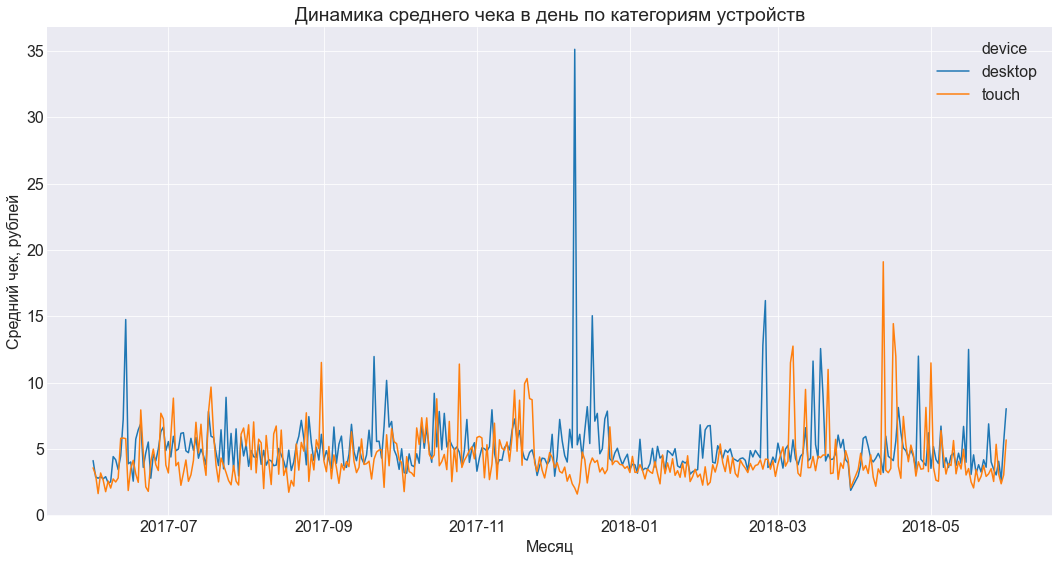

In [148]:
# посмотрим на динамику среднего чека в день по категориям устройств
revenue_per_day_device = orders.groupby(['device',
                                         'order_date'])\
                               .agg({'revenue': ['sum', 'count']})\
                               .reset_index()
revenue_per_day_device.columns = ['device',
                                  'order_date',
                                  'revenue',
                                  'n_orders']
revenue_per_day_device['avg_fee'] = revenue_per_day_device['revenue'] / revenue_per_day_device['n_orders']
fig, ax = plt.subplots()
plt.title('Динамика среднего чека в день по категориям устройств')
ax = sns.lineplot(x = 'order_date',
                  y = 'avg_fee',
                  data = revenue_per_day_device,
                  hue = 'device')       
plt.xlabel('Месяц')
plt.ylabel('Средний чек, рублей')
plt.show()

Средний чек пользователей, заходящих на сайт со стационарных устройств, выше, чем у испольующих мобильные устройства, в основном за счет нескольких дней с весьма высокими значениями среднего чека.

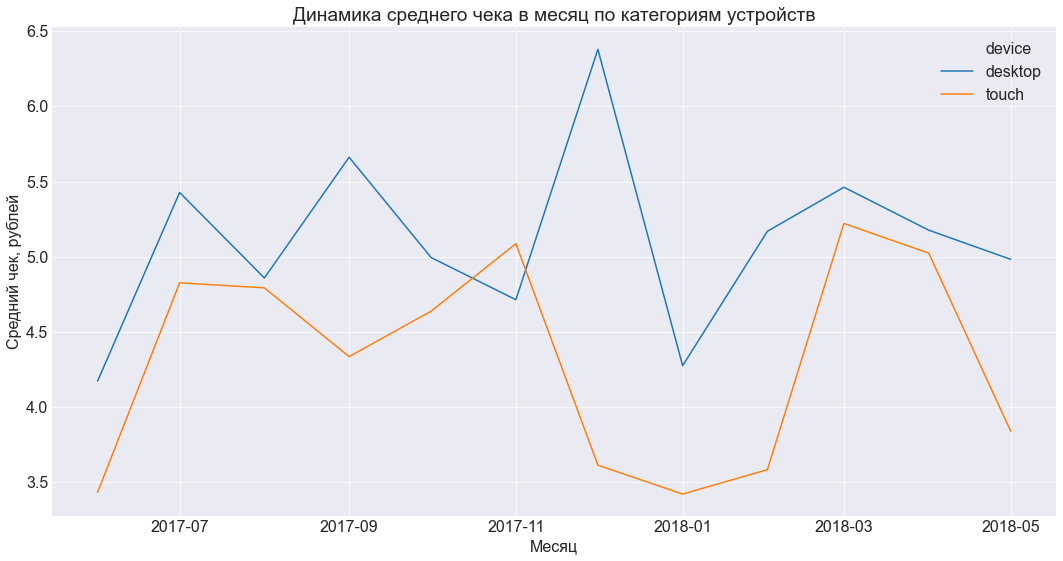

In [149]:
# посмотрим на динамику среднего чека в месяц по категориям устройств
revenue_per_month_device = orders.groupby(['device',
                                           'order_month'])\
                                 .agg({'revenue': ['sum', 'count']})\
                                 .reset_index()
revenue_per_month_device.columns = ['device',
                                    'order_month',
                                    'revenue',
                                    'n_orders']
revenue_per_month_device['avg_fee'] = revenue_per_month_device['revenue'] / revenue_per_month_device['n_orders']
revenue_per_month_device
fig, ax = plt.subplots()
plt.title('Динамика среднего чека в месяц по категориям устройств')
ax = sns.lineplot(x = 'order_month',
                  y = 'avg_fee',
                  data = revenue_per_month_device,
                  hue = 'device')       
plt.xlabel('Месяц')
plt.ylabel('Средний чек, рублей')
plt.show()

Только в ноябре 2017 года средний чек пользователей с мобильными устройствами был выше, чем у пользователей со стационарными устройствами. Средний чек декабря 2017 года у покупателей с разными устройствами находится на разных "полюсах".

###### По рекламным источникам

In [150]:
# посчитаем показатели выручки по рекламным источникам
revenue_metrics_source = orders.groupby('source_id')\
                               .agg({'revenue':['sum', 'mean', 'median'], 'uid':'nunique'})\
                               .reset_index()
revenue_metrics_source.columns = ['source_id',
                                  'total_revenue',
                                  'avg_fee',
                                  'median_fee',
                                  'n_buyers']
revenue_metrics_source['orders_per_buyers'] = order_metrics_source['n_orders'] / revenue_metrics_source['n_buyers']
revenue_metrics_source

source_id  total_revenue  avg_fee  median_fee  n_buyers  orders_per_buyers
0          1      31,090.55     5.95        3.05      2899               1.80
1          2      46,923.61     7.34        2.92      3506               1.82
2          3      54,511.24     4.10        2.44     10473               1.27
3          4      56,693.41     4.40        2.67     10295               1.25
4          5      52,624.02     5.59        2.78      6931               1.36
5          7           1.22     1.22        1.22         1               1.00
6          9       5,759.40     3.50        2.32      1088               1.51
7         10       4,450.33     2.85        1.83      1329               1.18

Самая большая выручка от покупателей, привлеченных на сайт при помощи четвертого, третьего и пятого рекламных источников, однако самый высокий средний чек от пользователей, пришедших из второго рекламного источника. В то же время, у этого рекламного источника медианный чек не самый высокий из-за присутствия в группе одного из самых "ценных" покупателей. Наибольшее количество покупателей пришли с помощью третьего и четвертого рекламных источников, однако самые высокие показатели среднего количества заказов на одного покупателя у второго и первого рекламных источников.

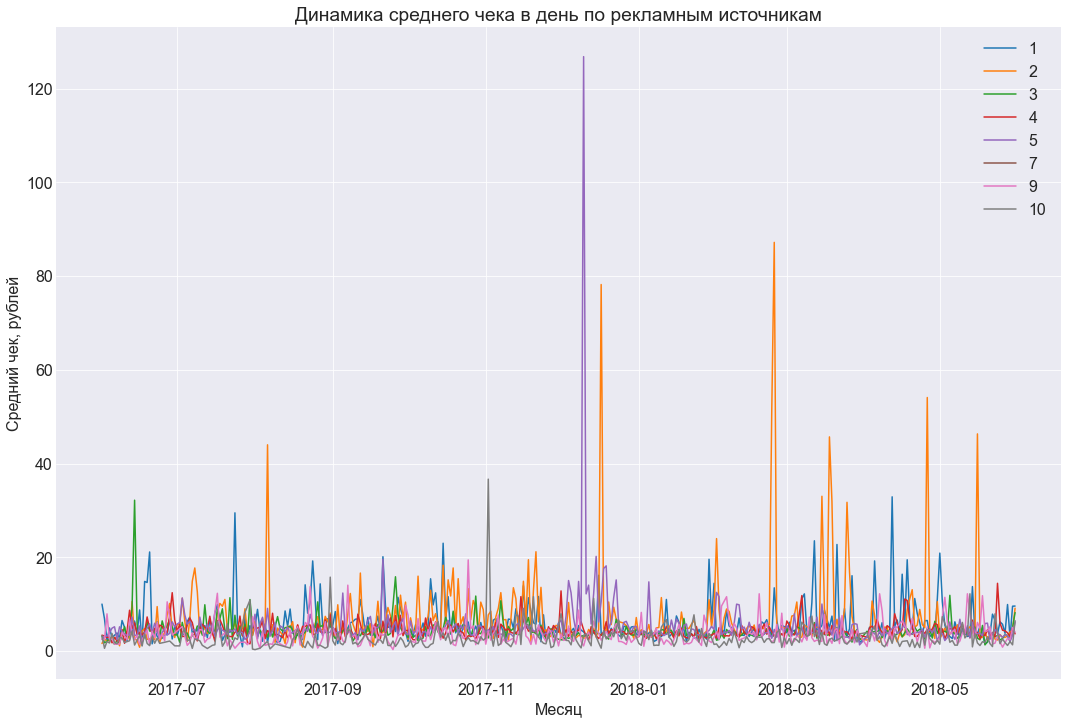

In [151]:
# посмотрим на динамику среднего чека в день по рекламным источникам
revenue_per_day_source = orders.groupby(['source_id',
                                         'order_date'])\
                               .agg({'revenue': ['sum', 'count']})\
                               .reset_index()
revenue_per_day_source.columns = ['source_id',
                                  'order_date',
                                  'revenue',
                                  'n_orders']
revenue_per_day_source['avg_fee'] = revenue_per_day_source['revenue'] / revenue_per_day_source['n_orders']
fig, ax = plt.subplots(figsize = (18, 12))
ax.set(title = 'Динамика среднего чека в день по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Средний чек, рублей')
for source in revenue_per_day_source['source_id'].unique():
    ax.plot(revenue_per_day_source.query('source_id == @source')['order_date'],
            revenue_per_day_source.query('source_id == @source')['avg_fee'],
            label = source) 
ax.legend()
plt.show()

У пятого рекламного источника в один из дней декабря 2017 года есть очень высокое значение среднего чека, вероятнее всего связанное с разовой крупной покупкой. Наибольшее количество "пиковых" дней с высокими значениями среднего чека у второго рекламного источника. 


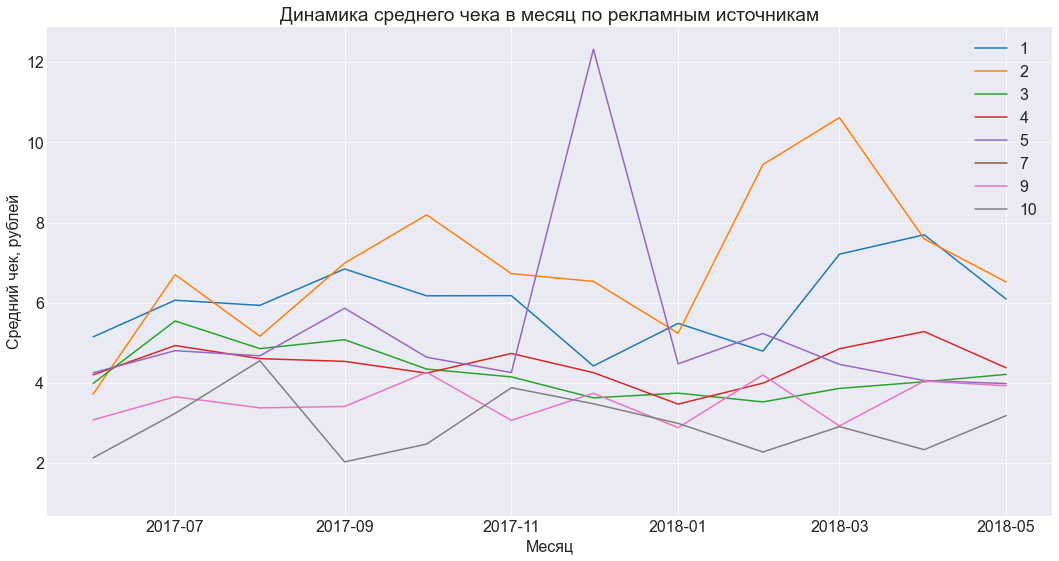

In [152]:
# посмотрим на динамику среднего чека в месяц по рекламным источникам
revenue_per_month_source = orders.groupby(['source_id',
                                           'order_month'])\
                                 .agg({'revenue': ['sum', 'count']})\
                                 .reset_index()
revenue_per_month_source.columns = ['source_id',
                                    'order_month',
                                    'revenue',
                                    'n_orders']
revenue_per_month_source['avg_fee'] = revenue_per_month_source['revenue'] / revenue_per_month_source['n_orders']
fig, ax = plt.subplots()
ax.set(title = 'Динамика среднего чека в месяц по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Средний чек, рублей')
for source in revenue_per_month_source['source_id'].unique():
    ax.plot(revenue_per_month_source.query('source_id == @source')['order_month'],
            revenue_per_month_source.query('source_id == @source')['avg_fee'],
            label = source)
ax.legend()
plt.show()

Средний чек в месяц практически по всем рекламным источникам из месяца в месяц меняется незначительно, за исключением пятого источника с большим значением среднего чека в декабре 2017 года, и второго источника с "всплеском" в феврале - марте 2018 года. Как уже отмечалось ранее в эти месяцы свои самые крупные покупки совершали наиболее "ценные" покупатели.

##### Сколько денег приносят (LTV)? 

###### По всей совокупности 

У нас отсутствует информация о маржинальности продаж, следовательно будем считать, что валовая прибыль равна выручке. Предположим, что Яндекс.Афиша получает фиксированный доход (или процент) от продаж, не неся каких-либо затрат (т.е. с нулевой себестоимостью).

In [153]:
# в таблицу с датой первого заказа добавим столбец с месяцем первого заказа
first_order['first_order_month'] = first_order['first_order'].astype('datetime64[M]')
first_order.head()

uid         first_order first_order_month
0   313578113262317 2018-01-03 21:51:00        2018-01-01
1  1575281904278712 2017-06-03 10:13:00        2017-06-01
2  2429014661409475 2017-10-11 18:33:00        2017-10-01
3  2464366381792757 2018-01-28 15:54:00        2018-01-01
4  2551852515556206 2017-11-24 10:14:00        2017-11-01

In [154]:
# определим исходное количество покупателей в когортах
cohort_sizes = first_order.groupby('first_order_month')\
                          .agg({'uid': 'nunique'})\
                          .reset_index()
cohort_sizes.columns = ['first_order_month',
                        'n_buyers']
cohort_sizes

first_order_month  n_buyers
0         2017-06-01      2023
1         2017-07-01      1923
2         2017-08-01      1370
3         2017-09-01      2581
4         2017-10-01      4340
5         2017-11-01      4081
6         2017-12-01      4383
7         2018-01-01      3373
8         2018-02-01      3651
9         2018-03-01      3533
10        2018-04-01      2276
11        2018-05-01      2988

In [155]:
# в таблицу с заказами добавим сведения о месяце первого заказа
orders = orders.merge(first_order,
                      on = 'uid')
orders.head()

uid   device  source_id  revenue            order_ts  \
0  10329302124590727494  desktop          1    17.00 2017-06-01 00:10:00   
1  11627257723692907447  desktop          2     0.55 2017-06-01 00:25:00   
2  17903680561304213844  desktop          2     0.37 2017-06-01 00:27:00   
3  16109239769442553005  desktop          2     0.55 2017-06-01 00:29:00   
4  14200605875248379450  desktop          3     0.37 2017-06-01 07:58:00   

   order_date order_month  orders_day_of_week         first_order  \
0  2017-06-01  2017-06-01                   3 2017-06-01 00:10:00   
1  2017-06-01  2017-06-01                   3 2017-06-01 00:25:00   
2  2017-06-01  2017-06-01                   3 2017-06-01 00:27:00   
3  2017-06-01  2017-06-01                   3 2017-06-01 00:29:00   
4  2017-06-01  2017-06-01                   3 2017-06-01 07:58:00   

  first_order_month  
0        2017-06-01  
1        2017-06-01  
2        2017-06-01  
3        2017-06-01  
4        2017-06-01

In [156]:
# проверим общую сумму выручки
orders['revenue'].sum()

252053.78000000003

In [157]:
# сформируем когорты покупателей  по месяцу первого заказа
cohorts_orders = orders.groupby(['first_order_month',
                                 'order_month'])\
                       .agg({'revenue': 'sum'})\
                       .reset_index()
cohorts_orders.head()

first_order_month order_month  revenue
0        2017-06-01  2017-06-01 9,557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01 1,931.30
4        2017-06-01  2017-10-01 2,068.58

In [158]:
# добавим в таблицу столбец с количеством покупателей в когортах
report = cohort_sizes.merge(cohorts_orders,
                            on = 'first_order_month')
report.head()

first_order_month  n_buyers order_month  revenue
0        2017-06-01      2023  2017-06-01 9,557.49
1        2017-06-01      2023  2017-07-01   981.82
2        2017-06-01      2023  2017-08-01   885.34
3        2017-06-01      2023  2017-09-01 1,931.30
4        2017-06-01      2023  2017-10-01 2,068.58

In [159]:
# проверим общую сумму выручки
report['revenue'].sum()

252053.77999999933

In [160]:
# добавим в таблицу столбец с lifetime покупателей и посчитаем LTV по когортам и lifetime
report['cohort_lifetime'] = ((report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')).round()\
                                                                                                            .astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
report.head()

first_order_month  n_buyers order_month  revenue  cohort_lifetime  ltv
0        2017-06-01      2023  2017-06-01 9,557.49                0 4.72
1        2017-06-01      2023  2017-07-01   981.82                1 0.49
2        2017-06-01      2023  2017-08-01   885.34                2 0.44
3        2017-06-01      2023  2017-09-01 1,931.30                3 0.95
4        2017-06-01      2023  2017-10-01 2,068.58                4 1.02

In [161]:
# построим сводную таблицу с показателем LTV по когортам и lifetime
ltv = report.pivot_table(index = 'first_order_month', 
                         columns = 'cohort_lifetime', 
                         values = 'ltv', 
                         aggfunc = 'mean')\
            .round(2)
ltv.fillna('')

cohort_lifetime     0    1    2    3    4    5    6    7    8    9    10   11
first_order_month                                                            
2017-06-01        4.72 0.49 0.44 0.95 1.02 0.74 0.95 0.58 0.55 0.61 0.57 0.26
2017-07-01        6.01 0.34 0.62 0.36 0.18 0.16 0.12 0.14 0.16 0.15 0.16     
2017-08-01        5.28 0.47 0.46 0.39 0.49 0.28 0.21 0.41 0.29 0.19          
2017-09-01        5.64 1.12 0.52 3.98 0.40 0.65 0.70 0.24 0.18               
2017-10-01        5.00 0.54 0.19 0.16 0.15 0.12 0.08 0.12                    
2017-11-01        5.15 0.40 0.20 0.32 0.15 0.05 0.11                         
2017-12-01        4.74 0.26 0.93 1.07 0.31 0.34                              
2018-01-01        4.14 0.29 0.30 0.14 0.06                                   
2018-02-01        4.16 0.28 0.08 0.07                                        
2018-03-01        4.84 0.30 0.32                                             
2018-04-01        4.66 0.53                                                  
2018-05-01        4.66

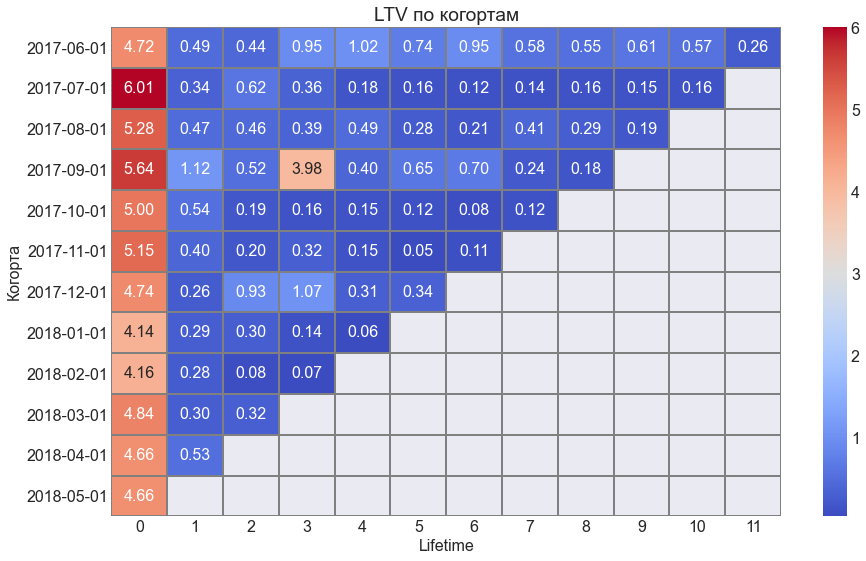

In [162]:
# создадим тепловую карту с показателем LTV по когортам и lifetime
plt.figure(figsize = (15, 9))
plt.title('LTV по когортам')
ax = sns.heatmap(ltv,
                 annot = True,
                 fmt = '.2f',
                 linewidths = 1,
                 cmap = 'coolwarm',
                 linecolor = 'gray',
                 yticklabels = ltv.index.date)
plt.xlabel('Lifetime')
plt.ylabel('Когорта')
plt.show()

Для всех когорт лучший показатель ценности клиента LTV - в месяц совершения первого заказа. В дальнейшем показатель LTV лишь изредка превышал 1 рубль. У когорты сентября 2017 года есть значительный "всплеск" в третий месяц ее "жизни", вероятнее всего связанный с крупными разовыми покупками в декабре 2017 года.

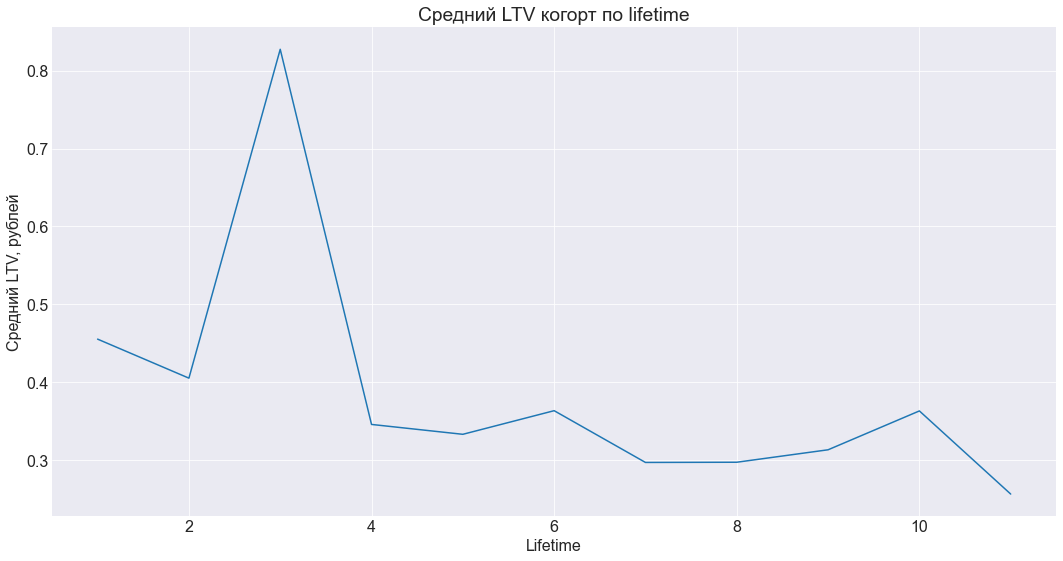

In [163]:
# посмотрим на динамику среднего LTV по времени "жизни" когорты без учета ее нулевого месяца
ltv_mean = report.groupby('cohort_lifetime')['ltv']\
                 .mean()\
                 .reset_index()
fig, ax = plt.subplots()
plt.title('Средний LTV когорт по lifetime')
ax = sns.lineplot(x = ltv_mean['cohort_lifetime'][1:12],
                  y = ltv_mean['ltv'][1:12])
plt.xlabel('Lifetime')
plt.ylabel('Средний LTV, рублей')
plt.show()

Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" с течением "жизни" когорт неуклонно снижается, за исключением 3 месяца, когда произошел значительный "всплеск" у когорты сентября 2017 года.

In [164]:
# рассчитаем средний LTV по нулевому месяцу "жизни" когорты
ltv_null_mean = report.query('cohort_lifetime == 0')['ltv'].mean() 
d = {'avg_ltv_null': ltv_null_mean}
ltv_metrics_all = pd.DataFrame(data = d,
                               index = ['all'])
ltv_metrics_all

avg_ltv_null
all          4.92

Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты составляет 4,92 рубля.

In [165]:
# построим сводную таблицу с показателем накопительного LTV по когортам и lifetime
ltv_cumsum = ltv.cumsum(axis = 1)
ltv_cumsum.fillna('')

cohort_lifetime     0    1    2     3     4     5     6     7     8     9   \
first_order_month                                                            
2017-06-01        4.72 5.21 5.65  6.60  7.62  8.36  9.31  9.89 10.44 11.05   
2017-07-01        6.01 6.35 6.97  7.33  7.51  7.67  7.79  7.93  8.09  8.24   
2017-08-01        5.28 5.75 6.21  6.60  7.09  7.37  7.58  7.99  8.28  8.47   
2017-09-01        5.64 6.76 7.28 11.26 11.66 12.31 13.01 13.25 13.43         
2017-10-01        5.00 5.54 5.73  5.89  6.04  6.16  6.24  6.36               
2017-11-01        5.15 5.55 5.75  6.07  6.22  6.27  6.38                     
2017-12-01        4.74 5.00 5.93  7.00  7.31  7.65                           
2018-01-01        4.14 4.43 4.73  4.87  4.93                                 
2018-02-01        4.16 4.44 4.52  4.59                                       
2018-03-01        4.84 5.14 5.46                                             
2018-04-01        4.66 5.19                                                  
2018-05-01        4.66                                                       

cohort_lifetime      10    11  
first_order_month              
2017-06-01        11.62 11.88  
2017-07-01         8.40        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

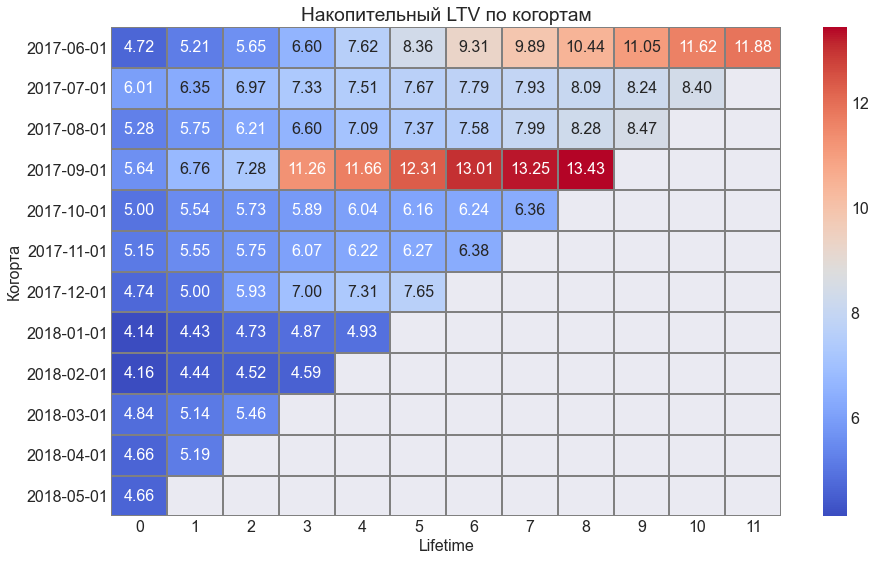

In [166]:
# создадим тепловую карту с показателем накопительного LTV по когортам и lifetime
plt.figure(figsize = (15, 9))
plt.title('Накопительный LTV по когортам')
ax = sns.heatmap(ltv_cumsum,
                 annot = True,
                 fmt = '.2f',
                 linewidths = 1,
                 cmap = 'coolwarm',
                 linecolor = 'gray',
                 yticklabels = ltv.index.date)
plt.xlabel('Lifetime')
plt.ylabel('Когорта')
plt.show()

Наибольшая средняя выручка с одного покупателя (13,43 рубля) - у когорты сентября 2017 года, в которую входит один из двух самых "ценных" покупателей. Хороший накопительный LTV и у самой "старой" когорты  - июня 2017 года (11,88 рублей).

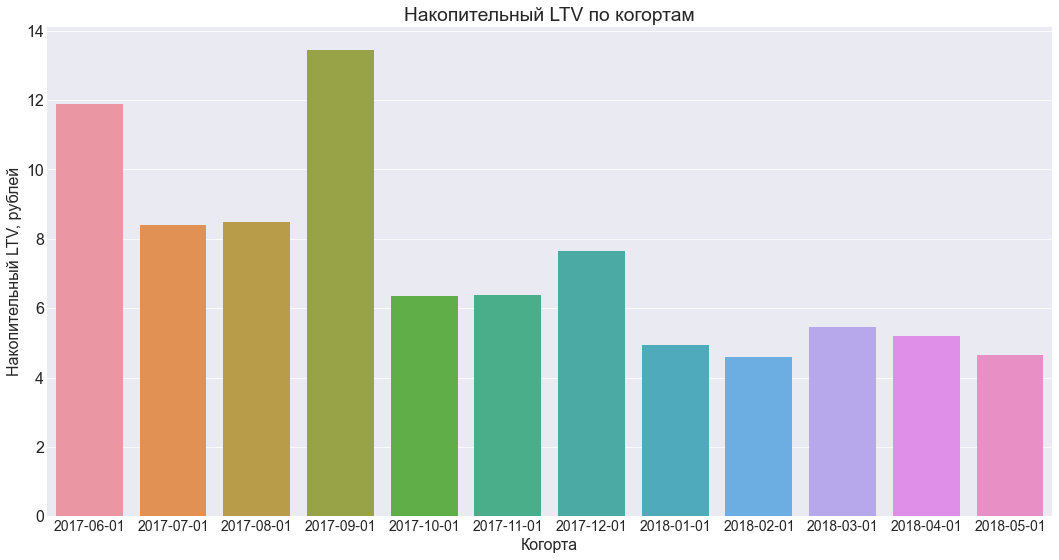

In [167]:
# посмотрим на накопительный LTV по когортам
ltv_sum = report.groupby('first_order_month')['ltv']\
                .sum()\
                .reset_index()
fig, ax = plt.subplots()
plt.title('Накопительный LTV по когортам')    
ax = sns.barplot(x = 'first_order_month',
                 y = 'ltv',
                 data = ltv_sum)
ax.set_xticklabels(labels = ltv_sum['first_order_month'].dt.strftime('%Y-%m-%d'),
                   fontsize = 14)
plt.xlabel('Когорта')
plt.ylabel('Накопительный LTV, рублей')
ax.grid = True
plt.show()

Чем моложе когорта, тем меньше средняя выручка с одного покупателя. Эту тенденцию нарушают покупатели когорт сентября и декабря 2017 года, в которые входят самые ценные клиенты.

In [168]:
# посчитаем средний LTV по всем покупателям
ltv_metrics_all['avg_ltv'] = revenue_metrics_all['total_revenue'].sum() / revenue_metrics_all['n_buyers'].sum()
ltv_metrics_all

avg_ltv_null  avg_ltv
all          4.92     6.90

Средняя выручка с одного покупателя - 6,9 рублей.

###### По категориям устройств 

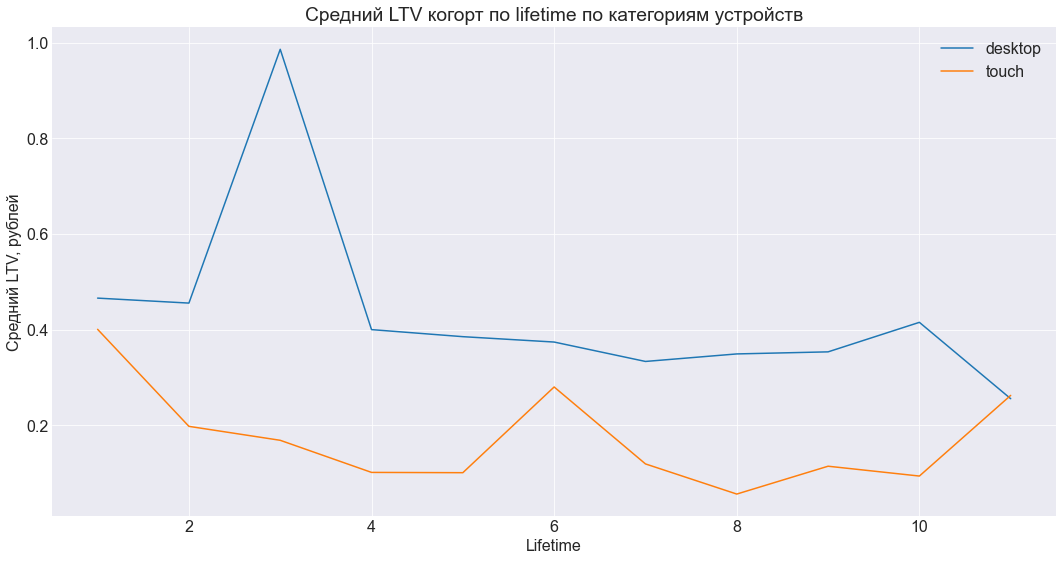

In [169]:
# посмотрим на динамику среднего LTV по времени "жизни" когорты по категориям устройств без учета ее нулевого месяца
cohort_sizes_device = orders.groupby(['device',
                                      'first_order_month'])\
                            .agg({'uid':'nunique'})\
                            .reset_index()
cohort_sizes_device.columns = ['device',
                               'first_order_month',
                               'n_buyers']
cohorts_orders_device = orders.groupby(['device',
                                        'first_order_month',
                                        'order_month'])\
                              .agg({'revenue': 'sum'})\
                              .reset_index()
report_device = cohort_sizes_device.merge(cohorts_orders_device,
                                          on = ['device',
                                                'first_order_month'])
report_device['cohort_lifetime'] = ((report_device['order_month'] - report_device['first_order_month'])\
                                        / np.timedelta64(1, 'M')).round().astype('int')
report_device['ltv'] = report_device['revenue'] / report_device['n_buyers']
ltv_mean_device = report_device.groupby(['device',
                                         'cohort_lifetime'])['ltv']\
                               .mean()\
                               .reset_index()
fig, ax = plt.subplots()
ax.set(title = 'Средний LTV когорт по lifetime по категориям устройств',
       xlabel = 'Lifetime',
       ylabel = 'Средний LTV, рублей')
for device in ltv_mean_device['device'].unique():
    ax.plot(ltv_mean_device.query('device == @device')['cohort_lifetime'][1:12],
            ltv_mean_device.query('device == @device')['ltv'][1:12],
            label = device )
ax.legend()
plt.show()

Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" у пользователей с мобильными устройствами в течение "жизни" когорт снижается медленнее, чем у пользователей со стационарными устройствами. 

In [170]:
# проверим общую сумму выручки
report_device['revenue'].sum()

252053.77999999968

In [171]:
# рассчитаем средний LTV по нулевому месяцу "жизни" когорты по категориям устройств
ltv_metrics_device = report_device.query('cohort_lifetime == 0')\
                                  .groupby('device')['ltv']\
                                  .mean()\
                                  .reset_index()\
                                  .rename(columns = {'ltv':'avg_ltv_null'})
ltv_metrics_device

device  avg_ltv_null
0  desktop          4.97
1    touch          4.69

Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты выше у пользователей со стационарными устройствами.

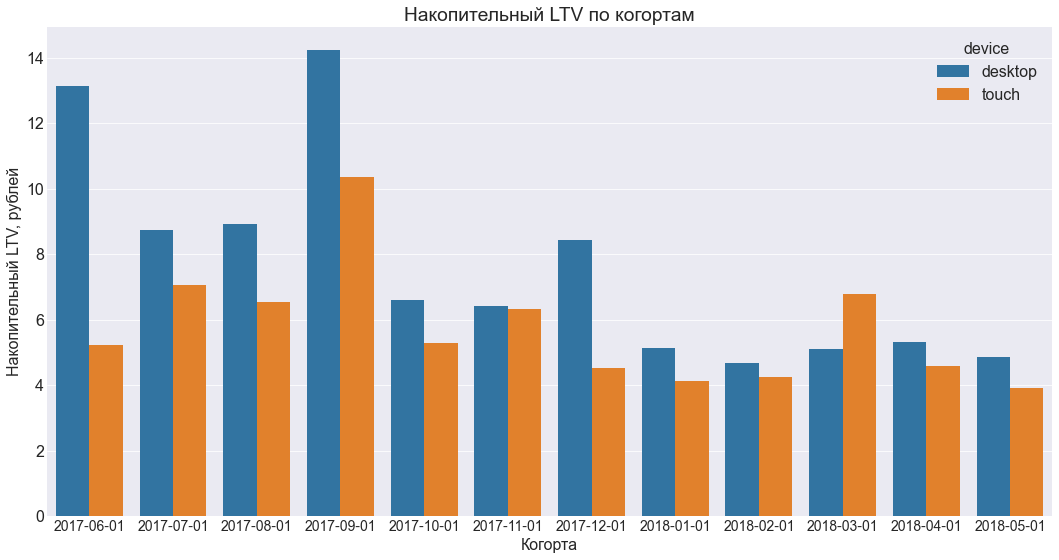

In [172]:
# посмотрим на накопительный LTV по когортам по категориям устройств
ltv_sum_device = report_device.groupby(['device',
                                        'first_order_month'])['ltv']\
                              .sum()\
                              .reset_index()
fig, ax = plt.subplots()
plt.title('Накопительный LTV по когортам')    
ax = sns.barplot(x = 'first_order_month',
                 y = 'ltv',
                 data = ltv_sum_device, 
                 hue = 'device')
ax.set_xticklabels(labels = ltv_sum_device['first_order_month'].dt.strftime('%Y-%m-%d'),
                   fontsize = 14)
plt.xlabel('Когорта')
plt.ylabel('Накопительный LTV, рублей')
plt.show()

Только у когорты покупателей марта 2018 года средняя выручка с одного покупателя выше у пользователей с мобильными устройствами.

In [173]:
# посчитаем средний LTV по всем покупателям по категориям устройств
f = revenue_metrics_device.groupby('device')['total_revenue'].sum()\
    / revenue_metrics_device.groupby('device')['n_buyers'].sum()
ltv_metrics_device['avg_ltv'] = ltv_metrics_device['device'].apply(lambda x: f[x])
ltv_metrics_device

device  avg_ltv_null  avg_ltv
0  desktop          4.97     7.23
1    touch          4.69     5.57

Средняя выручка с одного покупателя по категориям устройств значительно выше у покупателей со стационарными устройствами.

###### По рекламным источникам

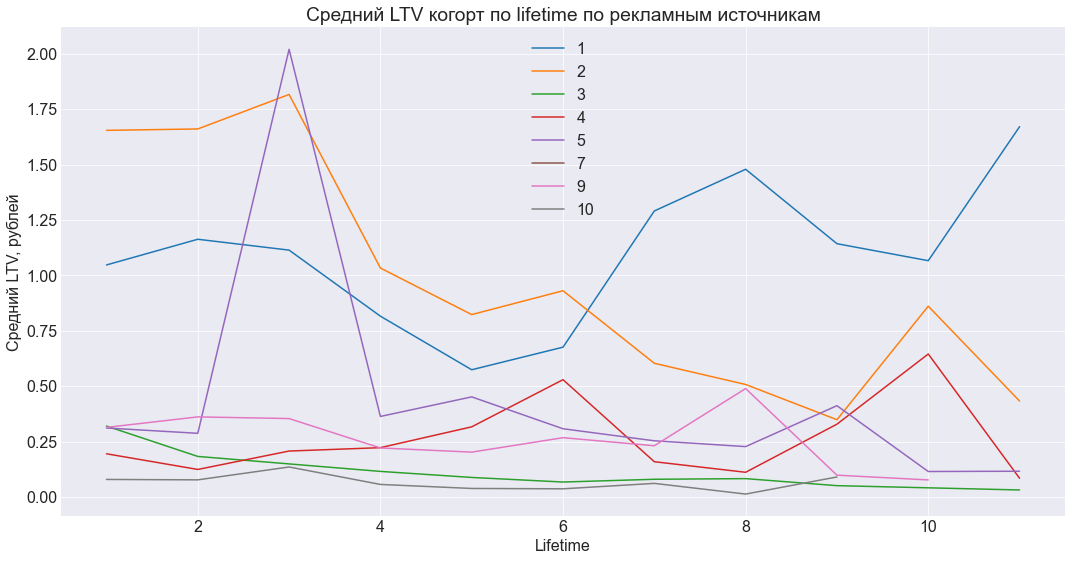

In [174]:
# посмотрим на динамику среднего LTV по времени "жизни" когорты по рекламным источникам без учета ее нулевого месяца
cohort_sizes_source = orders.groupby(['source_id',
                                      'first_order_month'])\
                            .agg({'uid':'nunique'})\
                            .reset_index()
cohort_sizes_source.columns = ['source_id',
                               'first_order_month',
                               'n_buyers']
cohorts_orders_source = orders.groupby(['source_id',
                                        'first_order_month',
                                        'order_month'])\
                              .agg({'revenue': 'sum'})\
                              .reset_index()
report_source = cohort_sizes_source.merge(cohorts_orders_source,
                                          on = ['source_id',
                                                'first_order_month'])
report_source['cohort_lifetime'] = ((report_source['order_month'] - report_source['first_order_month'])\
                                        / np.timedelta64(1, 'M')).round().astype('int')
report_source['ltv'] = report_source['revenue'] / report_source['n_buyers']
ltv_mean_source = report_source.groupby(['source_id',
                                         'cohort_lifetime'])['ltv']\
                               .mean()\
                               .reset_index()
fig, ax = plt.subplots()
ax.set(title = 'Средний LTV когорт по lifetime по рекламным источникам',
       xlabel = 'Lifetime',
       ylabel = 'Средний LTV, рублей')
for source in ltv_mean_source['source_id'].unique():
    ax.plot(ltv_mean_source.query('source_id == @source')['cohort_lifetime'][1:12],
            ltv_mean_source.query('source_id == @source')['ltv'][1:12],
            label = source )
ax.legend()
plt.show()

Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" в течение "жизни" когорт растет только у покупателей, пришедших на сайт с помощью первого рекламного источника. 

In [175]:
# проверим общую сумму выручки
report_source['revenue'].sum()

252053.78000000003

In [176]:
# рассчитаем средний LTV по нулевому месяцу "жизни" когорты по рекламным источникам
ltv_metrics_source = report_source.query('cohort_lifetime == 0')\
                                  .groupby('source_id')['ltv']\
                                  .mean()\
                                  .reset_index()\
                                  .rename(columns = {'ltv':'avg_ltv_null'})
ltv_metrics_source

source_id  avg_ltv_null
0          1          6.31
1          2          6.50
2          3          4.61
3          4          4.67
4          5          4.83
5          7          1.22
6          9          4.01
7         10          3.27

Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты самый высокий у покупателей, посетивших сайт при помощи второго и первого рекламных источников.

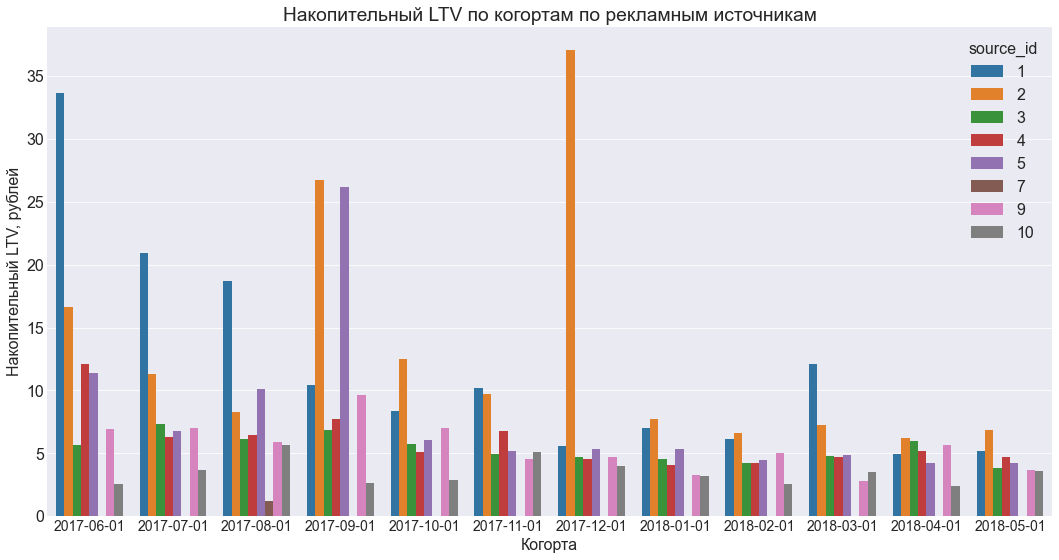

In [177]:
# посмотрим на накопительный LTV по когортам по рекламным источникам
ltv_sum_source = report_source.groupby(['source_id',
                                        'first_order_month'])['ltv']\
                              .sum()\
                              .reset_index()
fig, ax = plt.subplots()
plt.title('Накопительный LTV по когортам по рекламным источникам')    
ax = sns.barplot(x = 'first_order_month',
                 y = 'ltv',
                 data = ltv_sum_source, 
                 hue = 'source_id')
ax.set_xticklabels(labels = ltv_sum_source['first_order_month'].dt.strftime('%Y-%m-%d'),
                   fontsize = 14)
plt.xlabel('Когорта')
plt.ylabel('Накопительный LTV, рублей')
ax.grid = True
plt.show()

У разных когорт разные "лидеры" среди рекламных источников по уровню средней выручки с одного покупателя -  либо первый, либо второй рекламные источники. 

In [178]:
# посчитаем средний LTV по всем покупателям по рекламным источникам
f = revenue_metrics_source.groupby('source_id')['total_revenue'].sum()\
    / revenue_metrics_source.groupby('source_id')['n_buyers'].sum()
ltv_metrics_source['avg_ltv'] = ltv_metrics_source['source_id'].apply(lambda x: f[x])
ltv_metrics_source

source_id  avg_ltv_null  avg_ltv
0          1          6.31    10.72
1          2          6.50    13.38
2          3          4.61     5.20
3          4          4.67     5.51
4          5          4.83     7.59
5          7          1.22     1.22
6          9          4.01     5.29
7         10          3.27     3.35

Средняя выручка с одного покупателя самая высокая от покупателей, пришедших из второго (13,38 рублей) и первого (10,72 рублей) рекламных источников, самая низкая - от покупателей, пришедших из десятого (3,35 рублей) источника. Покупатели, пришедшие из второго рекламного источника, более половины выручки приносят после нулевого месяца "жизни" когорт.

#### Вывод

In [179]:
# сведем в одну таблицу все рассчитанные торговые метрики
trading_metrics_all = pd.concat([order_session_metrics_all,
                                 order_metrics_all,
                                 revenue_metrics_all,
                                 ltv_metrics_all],
                                axis = 1)
trading_metrics_all_tr = trading_metrics_all.transpose()
trading_metrics_all_tr

all
avg_order_session_days       0.00
n_visits               359,399.00
n_orders                50,414.00
ratio_orders_pct            14.03
orders_per_day             139.00
orders_per_month         4,201.00
total_revenue          252,053.78
avg_fee                      5.00
median_fee                   2.50
n_buyers                36,522.00
orders_per_buyers            1.38
avg_ltv_null                 4.92
avg_ltv                      6.90

In [180]:
# сведем в одну таблицу все рассчитанные торговые метрики по категориям устройств
trading_metrics_device = order_session_metrics_device.merge(order_metrics_device,
                                                            on = 'device')\
                                                     .merge(revenue_metrics_device,
                                                            on = 'device')\
                                                     .merge(ltv_metrics_device,
                                                            on = 'device')
trading_metrics_device.set_index('device', inplace = True)
trading_metrics_device_tr = trading_metrics_device.transpose()
trading_metrics_device_tr

device                    desktop     touch
avg_order_session_days       0.00      0.00
n_visits               262,566.00 96,833.00
n_orders                40,926.00  9,488.00
ratio_orders_pct            15.59      9.80
orders_per_day             113.00     26.00
orders_per_month         3,410.00    791.00
total_revenue          211,326.35 40,727.43
avg_fee                      5.16      4.29
median_fee                   2.69      2.44
n_buyers                29,210.00  7,312.00
orders_per_buyers            1.40      1.30
avg_ltv_null                 4.97      4.69
avg_ltv                      7.23      5.57

In [181]:
# сведем в одну таблицу все рассчитанные торговые метрики по рекламным источникам
trading_metrics_source = order_session_metrics_source.merge(order_metrics_source,
                                                            on = 'source_id')\
                                                     .merge(revenue_metrics_source,
                                                            on = 'source_id')\
                                                     .merge(ltv_metrics_source,
                                                            on = 'source_id')
trading_metrics_source.set_index('source_id', inplace = True)
trading_metrics_source_tr = trading_metrics_source.transpose()
trading_metrics_source_tr

source_id                     1         2         3          4         5   \
avg_order_session_days      0.00      0.00      0.00       0.00      0.00   
n_visits               34,121.00 47,626.00 85,610.00 101,793.00 66,905.00   
n_orders                5,223.00  6,392.00 13,289.00  12,894.00  9,406.00   
ratio_orders_pct           15.31     13.42     15.52      12.67     14.06   
orders_per_day             14.00     18.00     37.00      36.00     26.00   
orders_per_month          435.00    533.00  1,107.00   1,074.00    784.00   
total_revenue          31,090.55 46,923.61 54,511.24  56,693.41 52,624.02   
avg_fee                     5.95      7.34      4.10       4.40      5.59   
median_fee                  3.05      2.92      2.44       2.67      2.78   
n_buyers                2,899.00  3,506.00 10,473.00  10,295.00  6,931.00   
orders_per_buyers           1.80      1.82      1.27       1.25      1.36   
avg_ltv_null                6.31      6.50      4.61       4.67      4.83   
avg_ltv                    10.72     13.38      5.20       5.51      7.59   

source_id                 7         9         10  
avg_order_session_days  0.00      0.00      0.00  
n_visits               36.00 13,277.00 10,025.00  
n_orders                1.00  1,647.00  1,562.00  
ratio_orders_pct        2.78     12.40     15.58  
orders_per_day          1.00      5.00      5.00  
orders_per_month        1.00    137.00    130.00  
total_revenue           1.22  5,759.40  4,450.33  
avg_fee                 1.22      3.50      2.85  
median_fee              1.22      2.32      1.83  
n_buyers                1.00  1,088.00  1,329.00  
orders_per_buyers       1.00      1.51      1.18  
avg_ltv_null            1.22      4.01      3.27  
avg_ltv                 1.22      5.29      3.35

###### Когда люди начинают покупать?    
<br>1. Распределение количества дней до первой покупки неравномерно, в основном покупки совершаются достаточно быстро после первого посещения сайта, хотя имеются и весьма продолжительные периоды задержки. По этой причине показателем, который лучше всего отразит среднее количество дней до первой покупки, будет являться мода, которая равна 0 дней, в разрезе категорий устройств и рекламных источников значение среднего количества дней до первой покупки соответствует значению этого показателя по всей совокупности. 
<br>2. Таким образом, в основном первые покупки совершаются пользователями в первый день посещения сайта. Мало того, первые покупки совершаются пользователями в основном в течение первого часа первого посещения сайта. Пользователям мобильных устройств требуется больше времени, чтобы совершить покупку после первого посещения (для 75% пользователей устройств это период до 6 дней). Среди рекламных источников самыми "медленными" являются пользователи, привлеченные на сайт при помощи девятого  источника (для 75% пользователей, пришедших из этого источника, требуется до 70 дней, чтобы совершить покупку после первого посещения). Как ранее было установлено у этого рекламного источника самый высокий средний коэффициент удержания Retention Rate по первому месяцу "жизни" когорты, то есть пользователи возвращаются, чтобы совершить первую покупку.   
###### Сколько раз покупают за период?
<br>1. Всего из  359399 посещений сайта заказы были осуществлены в 50414 случаях, что составило чуть более 14%. Более 15% посещений сайта со стационарных устройств связано с осуществлением заказов, у пользователей мобильных устройств "холостых" посещений значительно больше (заказы осуществлялись менее, чем в 10% посещений). У пользователей, посетивших сайт при помощи первого, третьего и десятого рекламных источников, более 15% посещений сайта связано с осуществлением заказов, у седьмого источника лишь одно посещение из 36 привело к осуществлению заказа. Среднее количество заказов в день - 139, в месяц - 4201. У покупателей со стационарными устройствами эти показатели более чем в 4 раза выше, чем у покупателей с мобильными. Самые высокие значения среднего количество заказов в день и месяц у покупателей, пришедших из третьего и четвертого рекламных источников.    
<br>2. График динамики количества заказов в день также имеет характерные "зубцы", которые свидетельствуют о разном распределении количества заказов по дням недели - количество заказов, также, как и количество посещений, в выходные дни снижается. Наименьшее количество заказов было осуществлено в августе 2017 года, после чего начался их рост, достигший максимума в декабре 2017 года. После этого количество заказов в месяц то росло, то снижалось. Количество заказов в день со стационарных устройств подвержено большим колебаниям, чем с мобильных. Декабрьский "всплеск" количества заказов, вероятнее всего связанный с новогодними праздниками, был достигнут в основном за счет покупателей, использующих стационарные устройства. Количество заказов в месяц у пользователей стационарных устройств также подвержено большим колебаниям, тогда как количество заказов у пользователей мобильных устройств из месяца в месяц практически не меняется. У самых популярных рекламных источников (третьего и четвертого) рост количества заказов начался с сентября 2017 года, до этого они практически не выделялись на фоне других источников. Декабрьский "всплеск" количества заказов, вероятнее всего связанный с новогодними праздниками, был обеспечен в основном именно этими источниками.    
###### Какой средний чек?    
<br>1. Общая выручка составила 252053,78 рублей, средний чек - 5 рублей, медианный в 2 раза ниже - 2,5 рубля. Общее количество покупателей - 36522, в среднем один покупатель совершал 1,38 заказа. Два покупателя принесли 8,9% всей выручки. Самые ценные покупатели использовали стационарные устройства, стали пользователями сайта при помощи второго и пятого рекламных источников. Один из покупателей впервые совершил заказ в декабре 2017 года, второй - в сентябре 2017 года. Эти выбивающиеся значения выручки могут повлиять на дальнейшее исследование. Вероятнее всего это корпоративные клиенты, покупавшие билеты для своих работников, либо перекупщики билетов, решившие заработать на наиболее популярных мероприятиях (самые большие суммы этими покупателями потрачены в декабре - Новый год, феврале - 23 февраля, марте - 8 марта). Общая выручка от покупателей со стационарными устройствами в 5 раз больше выручки от покупателей с мобильными устройствами. Средний и медианный чек, а также количество покупателей и среднее количество заказов на одного покупателя также выше у пользователей, приходящих на сайт со стационарных устройств. Средний чек пользователей, заходящих на сайт со стационарных устройств, выше, чем у использующих мобильные устройства, в основном за счет нескольких дней с весьма высокими значениями среднего чека. Самая большая выручка от покупателей, привлеченных на сайт при помощи четвертого, третьего и пятого рекламных источников, однако самый высокий средний чек от пользователей, пришедших из второго рекламного источника. В то же время, у этого рекламного источника медианный чек не самый высокий из-за присутствия в группе одного из самых "ценных" покупателей. Наибольшее количество покупателей пришли с помощью третьего и четвертого рекламных источников, однако самые высокие показатели среднего количества заказов на одного покупателя у второго и первого рекламных источников.  
<br>2. Есть дни с очень высокими значениями среднего чека, вероятнее всего это связано с разовыми крупными покупками в эти дни. График динамики среднего чека имеет характерные "зубцы", которые свидетельствуют о его разном распределении по дням недели - самый низкий средний чек по субботам, а самый высокий - по воскресеньям (день с самым маленьким количеством заказов). Кроме того заметен рост среднего чека перед праздничными днями. Самый высокий средний чек в декабре 2017 года, самый низкий - в июне 2017 года и январе 2018 года (сразу после резкого роста). Только в ноябре 2017 года средний чек пользователей с мобильными устройствами был выше, чем у пользователей со стационарными устройствами. Средний чек декабря 2017 года у покупателей с разными устройствами находится на разных "полюсах". У пятого рекламного источника в один из дней декабря 2017 года есть очень высокое значение среднего чека, вероятнее всего связанное с разовой крупной покупкой. Наибольшее количество "пиковых" дней с высокими значениями среднего чека у второго рекламного источника. Средний чек в месяц практически по всем рекламным источникам из месяца в месяц меняется незначительно, за исключением пятого источника с большим значением среднего чека в декабре 2017 года, и второго источника с "всплеском" в феврале - марте 2018 года. Как уже отмечалось ранее в эти месяцы свои самые крупные покупки совершали наиболее "ценные" покупатели.  
###### Сколько денег приносят?  
<br>1. У нас отсутствует информация о маржинальности продаж, следовательно будем считать, что валовая прибыль равна выручке. 
Предположим, что Яндекс.Афиша получает фиксированный доход (или процент) от продаж, не неся каких-либо затрат (т.е. с нулевой себестоимостью). Для всех когорт лучший показатель ценности клиента LTV - в месяц совершения первого заказа. В дальнейшем показатель LTV лишь изредка превышал 1 рубль. У когорты сентября 2017 года есть значительный "всплеск" в третий месяц ее "жизни", вероятнее всего связанный с крупными разовыми покупками в декабре 2017 года. Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" с течением "жизни" когорт неуклонно снижается, за исключением 3 месяца, когда произошел значительный "всплеск" у когорты сентября 2017 года. Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты составляет 4,92 рубля. Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" у пользователей с мобильными устройствами в течение "жизни" когорт снижается медленнее, чем у пользователей со стационарными устройствами. Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты выше у пользователей со стационарными устройствами. Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" в течение "жизни" когорт растет только у покупателей, пришедших на сайт с помощью первого рекламного источника. Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты самый высокий у покупателей, посетивших сайт при помощи второго и первого рекламных источников.
<br>2. Наибольшая средняя выручка с одного покупателя (13,43 рубля) - у когорты сентября 2017 года, в которую входит один из двух самых "ценных" покупателей. Хороший накопительный LTV и у самой "старой" когорты  - июня 2017 года (11,88 рублей).  
Чем моложе когорта, тем меньше средняя выручка с одного покупателя. Эту тенденцию нарушают покупатели когорт сентября и декабря 2017 года, в которые входят самые ценные клиенты. Средняя выручка с одного покупателя - 6,9 рублей. Только у когорты покупателей марта 2018 года средняя выручка с одного покупателя выше у пользователей с мобильными устройствами. Средняя выручка с одного покупателя по категориям устройств значительно выше у покупателей со стационарными устройствами. У разных когорт разные "лидеры" среди рекламных источников по уровню средней выручки с одного покупателя -  либо первый, либо второй рекламные источники. Средняя выручка с одного покупателя самая высокая от покупателей, пришедших из второго (13,38 рублей) и первого (10,72 рублей) рекламных источников, самая низкая - от покупателей, пришедших из десятого (3,35 рублей) источника. Покупатели, пришедшие из второго рекламного источника, более половины выручки приносят после нулевого месяца "жизни" когорт.

#### Маркетинговые метрики
<a name="marketing"></a>

##### Сколько денег потратили (всего / на каждый источник / по времени)?   

###### По всей совокупности

In [182]:
# посчитаем общую сумму затрат
total_costs = costs['costs'].agg('sum')
d = {'total_costs': total_costs}
costs_metrics_all = pd.DataFrame(data = d,
                                 index = ['all'])
costs_metrics_all

total_costs
all   329,131.62

Всего на рекламу потратили 329 131,62 рубля.

###### По рекламным источникам

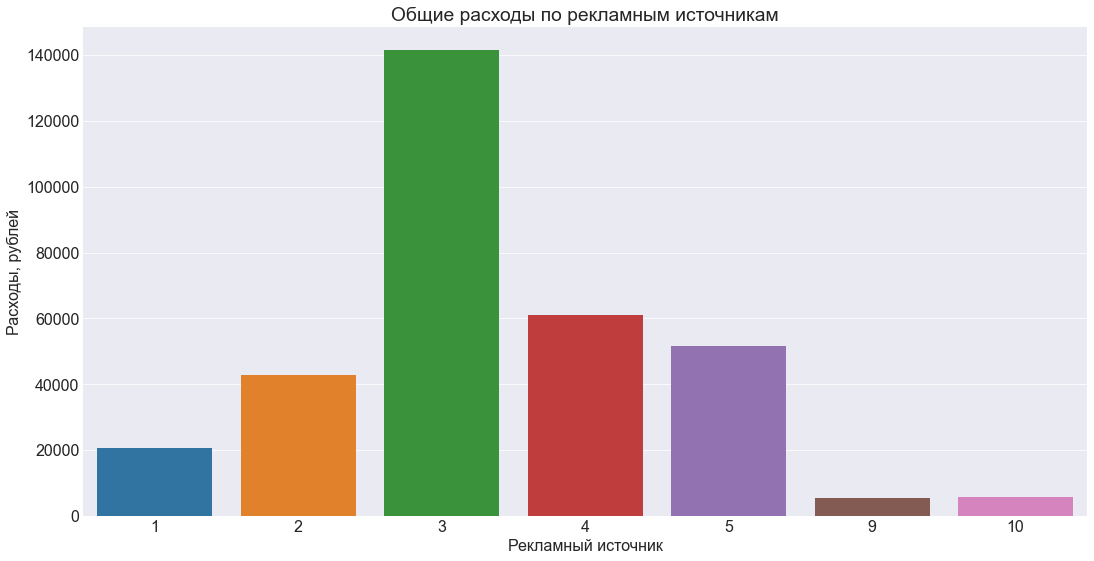

In [183]:
# посмотрим на общие расходы в разрезе рекламных источников
costs_metrics_source = costs.pivot_table(index = 'source_id',
                                         values = 'costs',
                                         aggfunc = 'sum')\
                    .reset_index()\
                    .rename(columns = {'costs':'total_costs'})
fig, ax = plt.subplots()
plt.title('Общие расходы по рекламным источникам')
ax = sns.barplot(x = 'source_id',
                 y = 'total_costs',
                 data = costs_metrics_source)
plt.xlabel('Рекламный источник')
plt.ylabel('Расходы, рублей')
ax.grid = True
plt.show()

In [184]:
# отсортируем затраты в разрезе рекламных источников
costs_metrics_source.sort_values(by = 'total_costs',
                                 ascending = False)


source_id  total_costs
2          3   141,321.63
3          4    61,073.60
4          5    51,757.10
1          2    42,806.04
0          1    20,833.27
6         10     5,822.49
5          9     5,517.49

Больше всего было потрачено на третий рекламный источник (141 321,63 рубля - более чем в 2 раза, чем на какой-либо другой), меньше всего - на девятый (5,517,49 рубля) и десятый (5 822,49 рубля) рекламные источники. На седьмой рекламный источник, из которого пришел один покупатель, затраты не осуществлялись.

In [185]:
# добавим в таблицу строку с нулевым значением затрат на рекламу по седьмому источнику
costs_metrics_source.loc[7] = [7, 0]
costs_metrics_source = costs_metrics_source.sort_values(by = 'source_id')
costs_metrics_source['source_id'] = costs_metrics_source['source_id'].astype('int')
costs_metrics_source

source_id  total_costs
0          1    20,833.27
1          2    42,806.04
2          3   141,321.63
3          4    61,073.60
4          5    51,757.10
7          7         0.00
5          9     5,517.49
6         10     5,822.49

###### По времени по всей совокупности

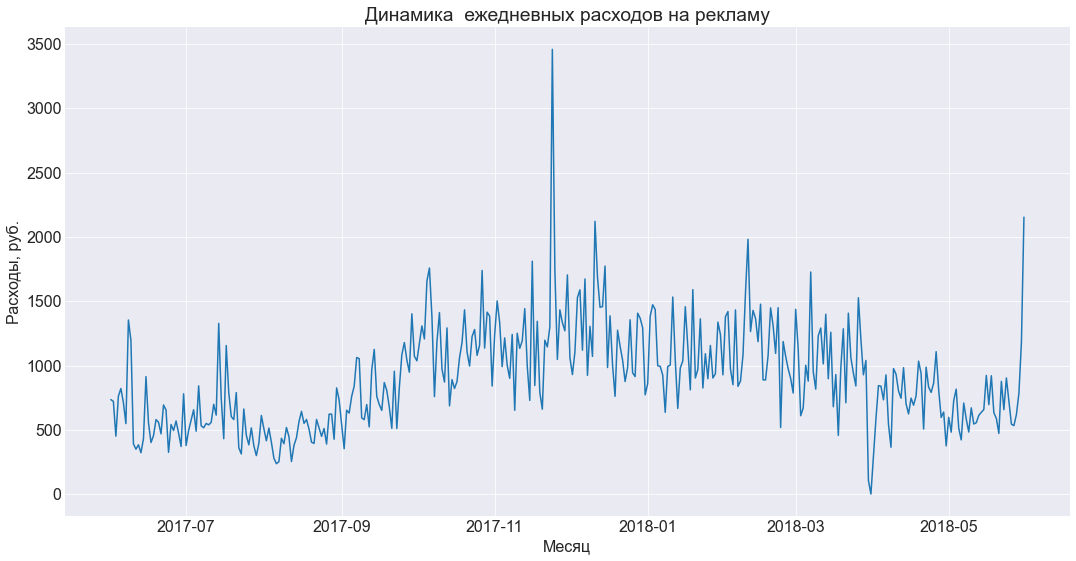

In [186]:
# посмотрим на динамику ежедневных расходов на рекламу
costs_date = costs.groupby('date')\
                   .agg({'costs': 'sum'})\
                   .reset_index()
fig, ax = plt.subplots()
plt.title('Динамика  ежедневных расходов на рекламу')
ax = sns.lineplot(x = 'date',
                  y = 'costs',
                  data = costs_date)
plt.xlabel('Месяц')
plt.ylabel('Расходы, руб.')
plt.show()

На графике имеется множество "всплесков", которые, вероятнее всего, говорят о проведении рекламных акций в эти дни. Динамика ежедневных расходов на рекламу очень похожа на динамику ежедневных заказов, что, вероятно, свидетельствует о наличии зависимости между этими показателями.

In [187]:
# посчитаем коэффициент корреляции между ежедневными затратами на рекламу и ежедневным количеством заказов
orders_per_day['order_date'] = pd.to_datetime(orders_per_day['order_date'])
costs_orders_date = costs_date.merge(orders_per_day,
                                     left_on = 'date',
                                     right_on = 'order_date',
                                     how = 'outer')
costs_orders_corr = costs_orders_date['costs'].corr(costs_orders_date['n_orders']).round(2)
costs_orders_corr

0.79

Полученное значение коэффициента корреляции 0,79 свидетельствует о достаточно высокой зависимости количества ежедневных заказов от ежедневных расходов на рекламу.

In [188]:
# добавим в таблицу столбцы с месяцем и днем недели затрат на рекламу
costs['costs_month'] = costs['date'].astype('datetime64[M]')
costs['costs_day_of_week']  = costs['date'].dt.weekday
costs.head()

source_id  costs       date costs_month  costs_day_of_week
0          1  75.20 2017-06-01  2017-06-01                  3
1          1  62.25 2017-06-02  2017-06-01                  4
2          1  36.53 2017-06-03  2017-06-01                  5
3          1  55.00 2017-06-04  2017-06-01                  6
4          1  57.08 2017-06-05  2017-06-01                  0

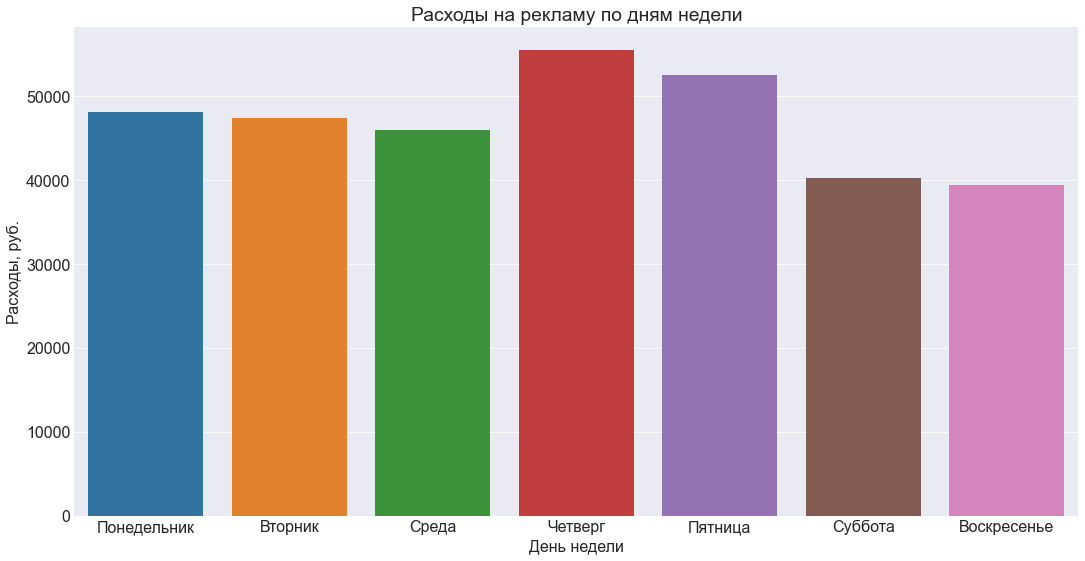

In [189]:
# посмотрим на расходы на рекламу по дням недели
costs_month = costs.groupby('costs_day_of_week')\
                   .agg({'costs': 'sum'})\
                   .reset_index()
plt.title('Расходы на рекламу по дням недели')
ax = sns.barplot(x = 'costs_day_of_week',
                 y = 'costs',
                 data = costs_month)       
plt.xlabel('День недели')
plt.ylabel('Расходы, руб.')
ax.set_xticklabels(labels = day_of_week)
plt.show()

Самые высокие затраты на рекламу в четверг и пятницу, самые низкие - в выходные дни.

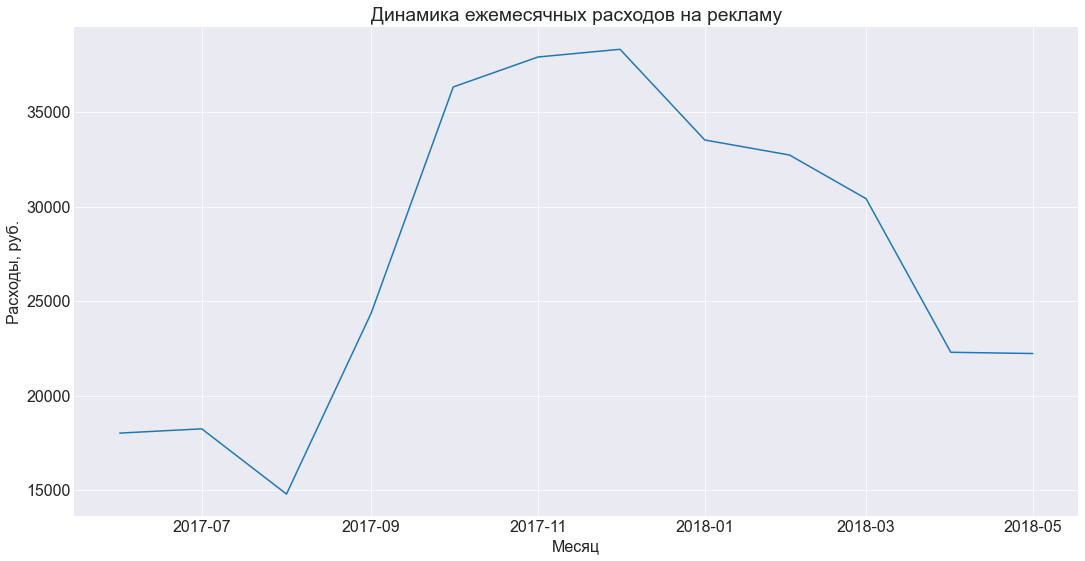

In [190]:
# посмотрим на динамику ежемесячных расходов на рекламу
costs_month = costs.groupby('costs_month')\
                   .agg({'costs': 'sum'})\
                   .reset_index()
fig, ax = plt.subplots()
plt.title('Динамика ежемесячных расходов на рекламу')
ax = sns.lineplot(x = 'costs_month',
                  y = 'costs',
                  data = costs_month)
plt.xlabel('Месяц')
plt.ylabel('Расходы, руб.')
plt.show()

Общие расходы на рекламу начали расти с сентября 2017 года, достигли своего максимума в декабре 2017 года, после чего начали снижаться.

###### По времени по рекламным источникам

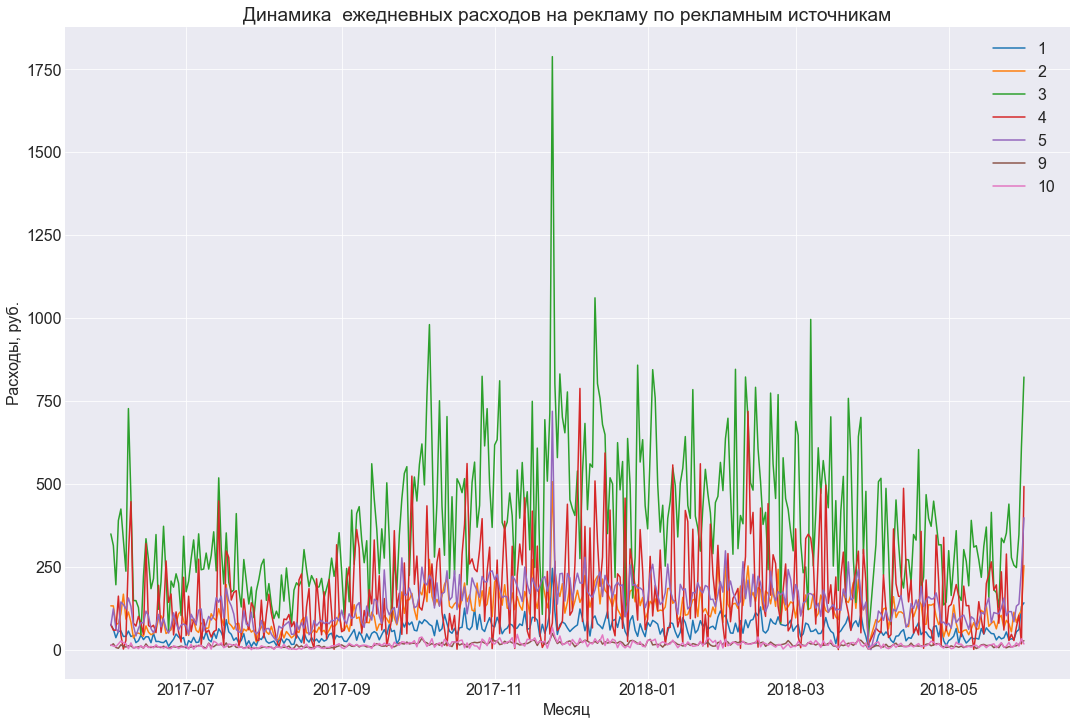

In [191]:
# посмотрим на динамику ежедневных расходов по рекламным источникам
costs_source_date = costs.groupby(['source_id',
                                   'date'])\
                         .agg({'costs': 'sum'})\
                         .reset_index()
fig, ax = plt.subplots(figsize = (18, 12))
ax.set(title = 'Динамика  ежедневных расходов на рекламу по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Расходы, руб.')
for source in costs_source_date['source_id'].unique():
    ax.plot(costs_source_date.query('source_id == @source')['date'],
            costs_source_date.query('source_id == @source')['costs'],
            label = source)
ax.legend()
plt.show()

По всем источникам ежедневные затраты на рекламу крайне неравномерны. Декабрьский "всплеск" затрат на рекламу, вероятнее всего связанный с новогодними праздниками, достигнут исключительно благодаря третьему источнику.

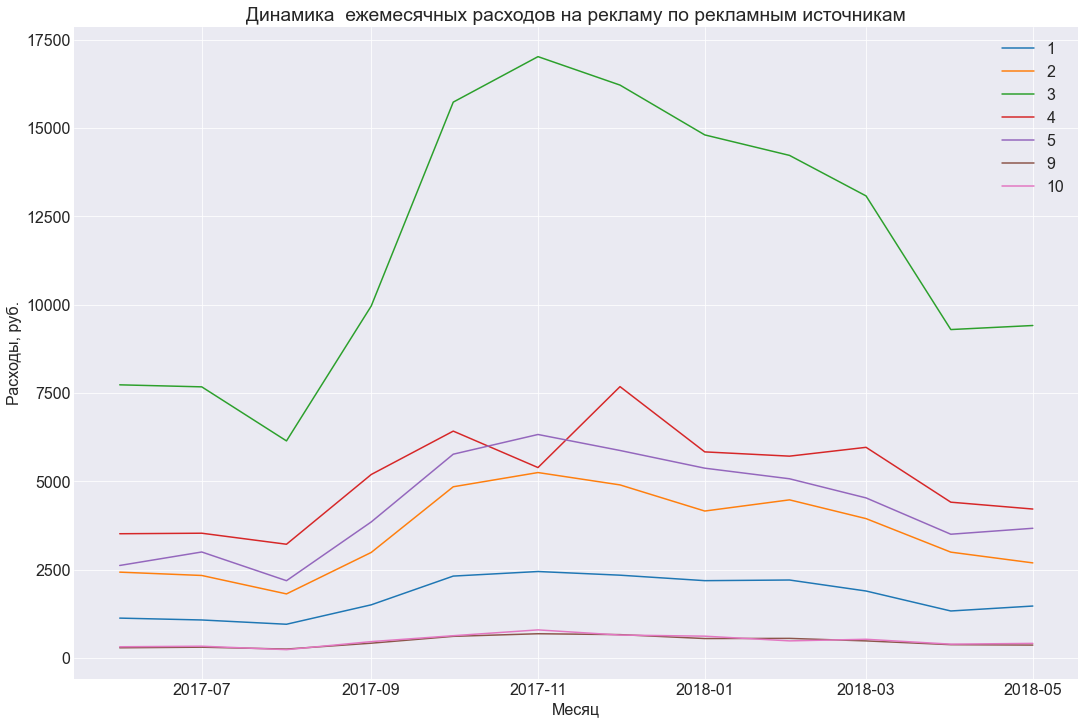

In [192]:
# посмотрим на динамику ежемесячных расходов по рекламным источникам
costs_source_month = costs.groupby(['source_id',
                                    'costs_month'])\
                          .agg({'costs': 'sum'})\
                          .reset_index()
fig, ax = plt.subplots(figsize = (18, 12))
ax.set(title = 'Динамика  ежемесячных расходов на рекламу по рекламным источникам',
       xlabel = 'Месяц',
       ylabel = 'Расходы, руб.')
for source in costs_source_month['source_id'].unique():
    ax.plot(costs_source_month.query('source_id == @source')['costs_month'],
            costs_source_month.query('source_id == @source')['costs'],
            label = source)
ax.legend()
plt.show()

Ежемесячные расходы на рекламу по всем рекламным источникам, за исключением третьего, в анализируемом периоде производились достаточно равномерно. Динамика затрат на самый "дорогой" рекламный источник - третий - соответствует динамике общих затрат на рекламу по всем источникам.

##### Сколько стоило привлечение одного покупателя из каждого источника?  

###### По всей совокупности

In [193]:
# добавим в таблицу с когортами покупателей расходы на рекламу и посчитаем CAC
report_new = report.merge(costs_month,
                          left_on = 'first_order_month',
                          right_on = 'costs_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

first_order_month  n_buyers order_month  revenue  cohort_lifetime  ltv  \
0        2017-06-01      2023  2017-06-01 9,557.49                0 4.72   
1        2017-06-01      2023  2017-07-01   981.82                1 0.49   
2        2017-06-01      2023  2017-08-01   885.34                2 0.44   
3        2017-06-01      2023  2017-09-01 1,931.30                3 0.95   
4        2017-06-01      2023  2017-10-01 2,068.58                4 1.02   

  costs_month     costs  cac  
0  2017-06-01 18,015.00 8.91  
1  2017-06-01 18,015.00 8.91  
2  2017-06-01 18,015.00 8.91  
3  2017-06-01 18,015.00 8.91  
4  2017-06-01 18,015.00 8.91

In [194]:
# проверим общую сумму выручки
report_new['revenue'].sum()

252053.77999999933

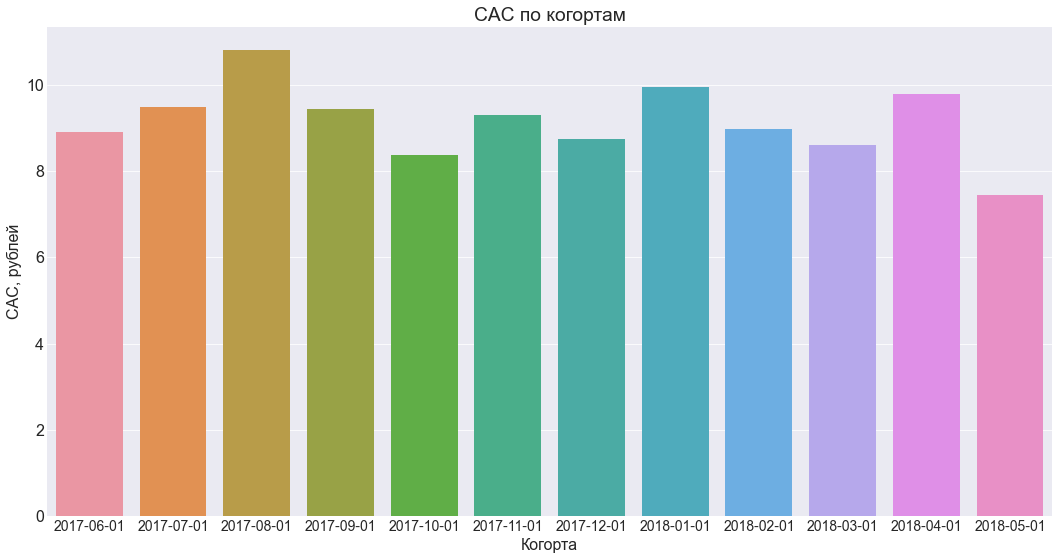

In [195]:
# посмотрим на CAC по когортам
cac = report_new.groupby('first_order_month')['cac']\
                .mean()\
                .reset_index()
fig, ax = plt.subplots()
plt.title('CAC по когортам')    
ax = sns.barplot(x = 'first_order_month',
                 y = 'cac',
                 data = cac)
ax.set_xticklabels(labels = cac['first_order_month'].dt.strftime('%Y-%m-%d'),
                   fontsize = 14)
plt.xlabel('Когорта')
plt.ylabel('CAC, рублей')
plt.show()

In [196]:
# отсортируем таблицу по показателю CAC
cac.sort_values(by = 'cac',
                ascending=False)\
   .reset_index(drop = True)

first_order_month   cac
0         2017-08-01 10.80
1         2018-01-01  9.94
2         2018-04-01  9.79
3         2017-07-01  9.49
4         2017-09-01  9.44
5         2017-11-01  9.29
6         2018-02-01  8.96
7         2017-06-01  8.91
8         2017-12-01  8.74
9         2018-03-01  8.61
10        2017-10-01  8.37
11        2018-05-01  7.44

Самыми дорогими по стоимости привлечения оказались покупатели когорты августа 2017 года (CAC составил 10,8 рублей), января (CAC - 9,9 рублей) и апреля 2018 года (CAC - 9,8 рублей). Дешевле всего по стоимости привлечения оказались пользователи мая 2018 года (CAC - 7,4 рубля) и октября 2017 года (CAC - 8,4 рубля).

In [197]:
# посчитаем средний CAC по всем покупателям
cac_mean = costs['costs'].sum() / revenue_metrics_all['n_buyers']
d = {'avg_cac': cac_mean}
cac_metrics_all = pd.DataFrame(data = d,
                               index = ['all'])
cac_metrics_all

avg_cac
all     9.01

Средний показатель CAC по всем покупателям составил 9,01 рубль.

###### По рекламным источникам

In [198]:
# добавим в таблицу с когортами покупателей расходы на рекламу и посчитаем CAC
report_source_new = report_source.merge(costs_source_month,
                                        left_on = ['source_id',
                                                   'first_order_month'],
                                        right_on = ['source_id',
                                                    'costs_month'],
                                        how = 'outer')
report_source_new['cac'] = report_source_new['costs'] / report_source_new['n_buyers']
report_source_new.head()

source_id first_order_month  n_buyers order_month  revenue  \
0          1        2017-06-01       190  2017-06-01 1,378.70   
1          1        2017-06-01       190  2017-07-01   414.98   
2          1        2017-06-01       190  2017-08-01   419.43   
3          1        2017-06-01       190  2017-09-01   714.24   
4          1        2017-06-01       190  2017-10-01   811.20   

   cohort_lifetime  ltv costs_month    costs  cac  
0                0 7.26  2017-06-01 1,125.61 5.92  
1                1 2.18  2017-06-01 1,125.61 5.92  
2                2 2.21  2017-06-01 1,125.61 5.92  
3                3 3.76  2017-06-01 1,125.61 5.92  
4                4 4.27  2017-06-01 1,125.61 5.92

In [199]:
# проверим общую сумму выручки
report_source_new['revenue'].sum()

252053.78000000003

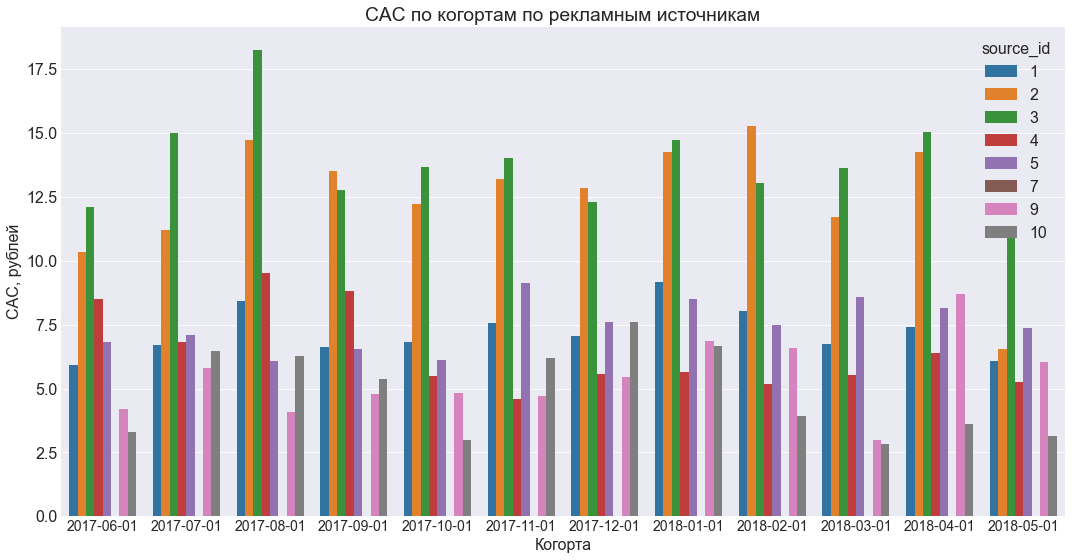

In [200]:
# посмотрим на CAC по когортам по рекламным источникам
cac_source = report_source_new.groupby(['source_id',
                                        'first_order_month'])['cac']\
                              .mean()\
                              .reset_index()
fig, ax = plt.subplots()
plt.title('CAC по когортам по рекламным источникам')    
ax = sns.barplot(x = 'first_order_month',
                 y = 'cac',
                 data = cac_source,
                 hue = 'source_id')
ax.set_xticklabels(labels = cac_source['first_order_month'].dt.strftime('%Y-%m-%d'),
                   fontsize = 14)
plt.xlabel('Когорта')
plt.ylabel('CAC, рублей')
plt.show()

Во всех когортах наибольшая стоимость привлечения клиентов у второго и третьего рекламных источников, наименьшая у большинства когорт - у девятого и десятого источника. 

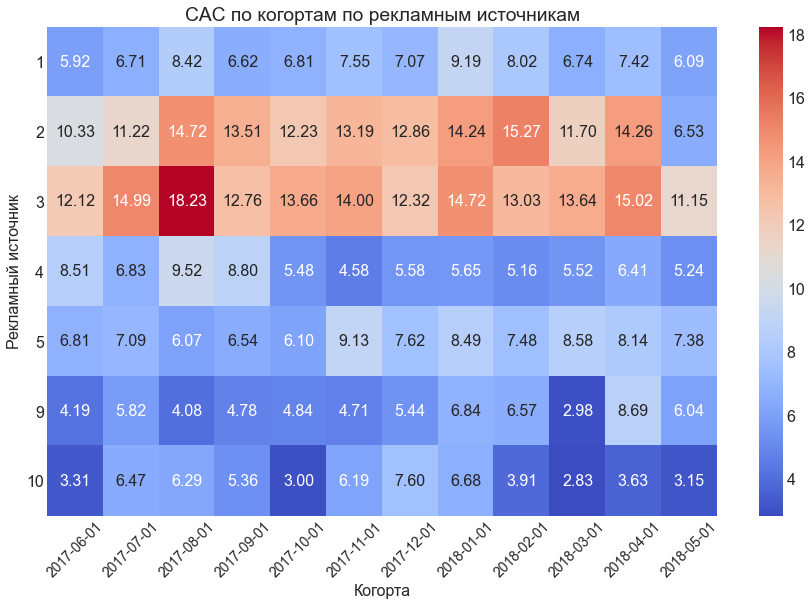

In [201]:
# создадим тепловую карту с показателем CAC по рекламным источникам
cac_source_pivot = cac_source.pivot_table(index = 'source_id',
                                          columns = 'first_order_month',
                                          values = 'cac')
plt.figure(figsize = (15, 9))
plt.title('CAC по когортам по рекламным источникам')
ax = sns.heatmap(cac_source_pivot,
                 annot = True,
                 fmt = '.2f',
                 cmap = 'coolwarm',
                 linecolor = 'gray')
plt.xlabel('Когорта')
plt.ylabel('Рекламный источник')
ax.set_xticklabels(labels = cac_source_pivot.columns.date,
                   fontsize = 14,
                   rotation = 45)
ax.set_yticklabels(labels = cac_source_pivot.index,
                   rotation = 0)
plt.show()

Самая высокая стоимость привлечения клиентов CAC у когорты августа 2017 года третьим источником - 18,23 рубля, самая низкая - у когорты марта 2018 года десятым источником - 2,83 рубля.

In [202]:
# посчитаем средний CAC по всем покупателям по рекламным источникам
cac_mean_source = costs_metrics_source.groupby('source_id')['total_costs'].sum()\
    / revenue_metrics_source.groupby('source_id')['n_buyers'].sum()
d = {'avg_cac': cac_mean_source}
cac_metrics_source = pd.DataFrame(data = d)
cac_metrics_source = cac_metrics_source.reset_index()
cac_metrics_source

source_id  avg_cac
0          1     7.19
1          2    12.21
2          3    13.49
3          4     5.93
4          5     7.47
5          7     0.00
6          9     5.07
7         10     4.38

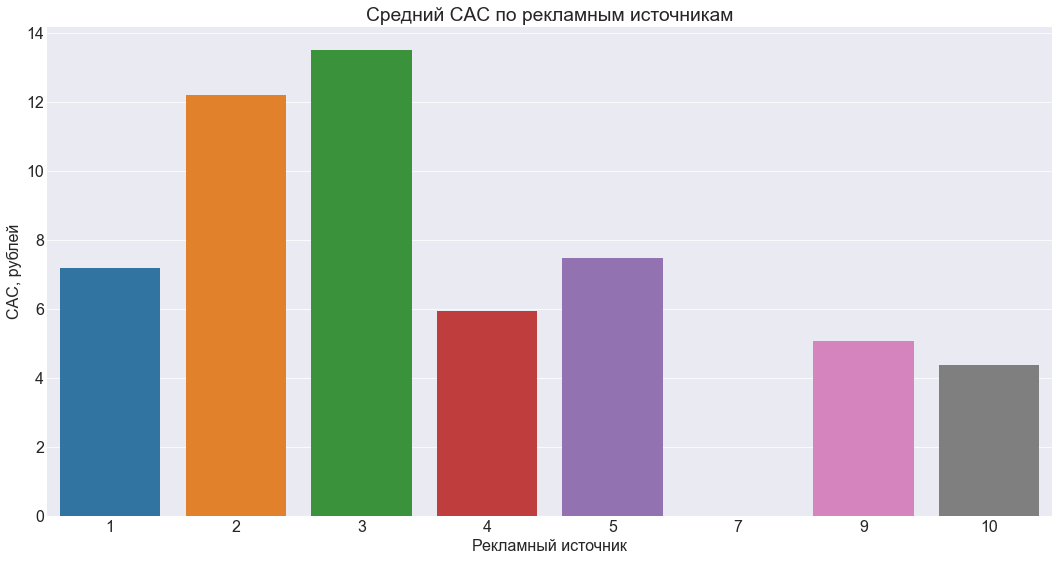

In [203]:
# посмотрим на средний CAC по рекламным источникам
fig, ax = plt.subplots()
plt.title('Средний CAC по рекламным источникам')    
ax = sns.barplot(x = 'source_id',
                 y = 'avg_cac',
                 data = cac_metrics_source)
plt.xlabel('Рекламный источник')
plt.ylabel('CAC, рублей')
plt.show()

Самая высокая средняя стоимость привлечения покупателей CAC у третьего рекламного источника - 13,49 рублей, чуть ниже у второго - 12,21 рубль. Самый низкий средний показатель CAC у десятого рекламного источника - 4,38 рубля.

##### На сколько окупились расходы (ROI)? 

###### По всей совокупности

In [204]:
# добавим в таблицу с когортами покупателей столбец с ROMI
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new.head()

first_order_month  n_buyers order_month  revenue  cohort_lifetime  ltv  \
0        2017-06-01      2023  2017-06-01 9,557.49                0 4.72   
1        2017-06-01      2023  2017-07-01   981.82                1 0.49   
2        2017-06-01      2023  2017-08-01   885.34                2 0.44   
3        2017-06-01      2023  2017-09-01 1,931.30                3 0.95   
4        2017-06-01      2023  2017-10-01 2,068.58                4 1.02   

  costs_month     costs  cac  romi  
0  2017-06-01 18,015.00 8.91  0.53  
1  2017-06-01 18,015.00 8.91  0.05  
2  2017-06-01 18,015.00 8.91  0.05  
3  2017-06-01 18,015.00 8.91  0.11  
4  2017-06-01 18,015.00 8.91  0.11

In [205]:
# построим сводную таблицу с показателем ROMI по когортам и lifetime
romi = report_new.pivot_table(index = 'first_order_month', 
                              columns = 'cohort_lifetime', 
                              values = 'romi', 
                              aggfunc = 'mean')
romi_cumsum = romi.cumsum(axis = 1)
romi_cumsum.fillna('')

cohort_lifetime     0    1    2    3    4    5    6    7    8    9    10   11
first_order_month                                                            
2017-06-01        0.53 0.59 0.63 0.74 0.86 0.94 1.05 1.11 1.17 1.24 1.31 1.33
2017-07-01        0.63 0.67 0.73 0.77 0.79 0.81 0.82 0.84 0.85 0.87 0.88     
2017-08-01        0.49 0.53 0.57 0.61 0.66 0.68 0.70 0.74 0.77 0.78          
2017-09-01        0.60 0.72 0.77 1.19 1.23 1.30 1.38 1.40 1.42               
2017-10-01        0.60 0.66 0.68 0.70 0.72 0.74 0.75 0.76                    
2017-11-01        0.55 0.60 0.62 0.65 0.67 0.68 0.69                         
2017-12-01        0.54 0.57 0.68 0.80 0.84 0.87                              
2018-01-01        0.42 0.45 0.48 0.49 0.50                                   
2018-02-01        0.46 0.49 0.50 0.51                                        
2018-03-01        0.56 0.60 0.63                                             
2018-04-01        0.48 0.53                                                  
2018-05-01        0.63

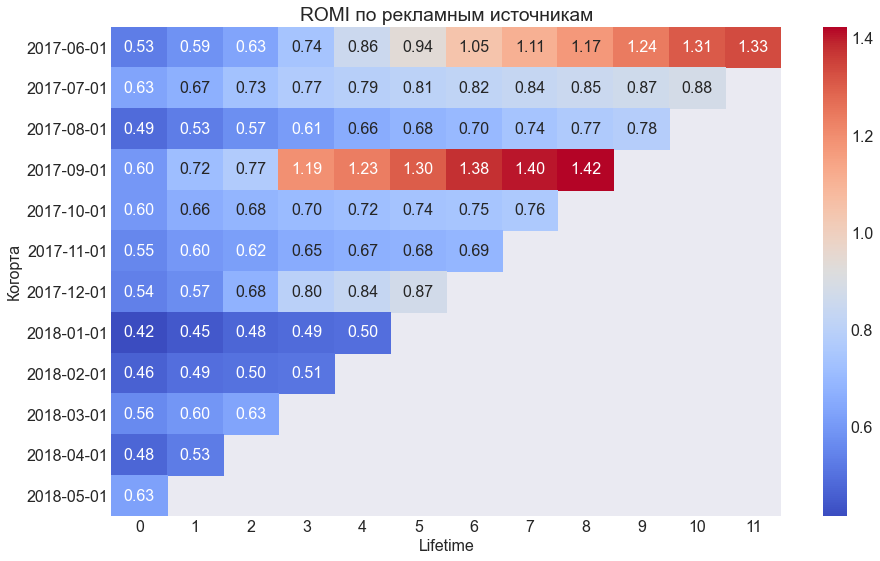

In [206]:
# создадим тепловую карту с показателем ROMI по рекламным источникам
plt.figure(figsize = (15, 9))
plt.title('ROMI по рекламным источникам')
ax = sns.heatmap(romi_cumsum,
                 annot = True,
                 fmt = '.2f',
                 cmap = 'coolwarm',
                 linecolor = 'gray',
                 yticklabels = ltv.index.date)
plt.xlabel('Lifetime')
plt.ylabel('Когорта')
plt.show()

Быстрее всего окупилась когорта сентября 2017 года, в которую входит один из двух наиболее ценных клиентов, - на 3 месяц. Самая "старая" когорта - июня 2017 года - окупилась на шестой месяц. Остальные когорты на момент окончания анализируемого периода не окупились.

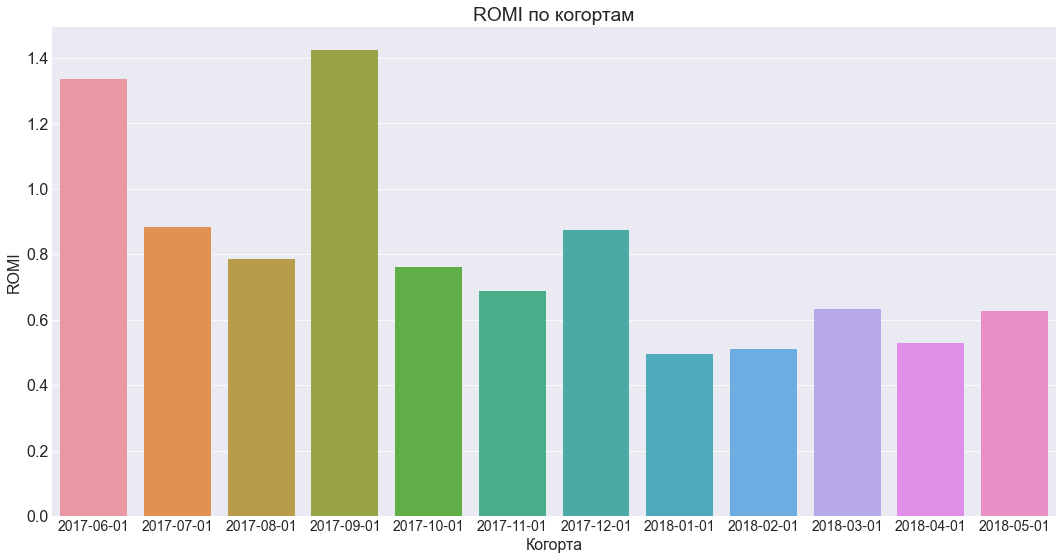

In [207]:
# посмотрим на ROMI по когортам
romi_cohorts = report_new.groupby('first_order_month')['romi']\
                         .sum()\
                         .reset_index()
fig, ax = plt.subplots()
plt.title('ROMI по когортам')    
ax = sns.barplot(x = 'first_order_month',
                 y = 'romi',
                 data = romi_cohorts)
ax.set_xticklabels(labels = romi_cohorts['first_order_month'].dt.strftime('%Y-%m-%d'), fontsize = 14)
plt.xlabel('Когорта')
plt.ylabel('ROMI')
plt.show()

In [208]:
# отсортируем таблицу по показателю ROMI
romi_cohorts.sort_values(by = 'romi',
                         ascending = False)\
            .reset_index(drop = True)

first_order_month  romi
0         2017-09-01  1.42
1         2017-06-01  1.33
2         2017-07-01  0.88
3         2017-12-01  0.87
4         2017-08-01  0.78
5         2017-10-01  0.76
6         2017-11-01  0.69
7         2018-03-01  0.63
8         2018-05-01  0.63
9         2018-04-01  0.53
10        2018-02-01  0.51
11        2018-01-01  0.50

Средний показатель возврата маркетинговых инвестиций ROMI выше единицы только в двух когортах - сентября (ROMI составил 1,42) и июня 2017 года (ROMI - 1,33). Самый низкий показатель ROMI у покупателей, совершивших первый заказ в январе (ROMI - 0,5), феврале (ROMI - 0,51) и апреле 2018 года (ROMI - 0,53).

In [209]:
# посчитаем, когда в среднем начинают окупаться когорты
romi.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0    0.54
1    0.58
2    0.63
3    0.72
4    0.78
5    0.86
6    0.90
7    0.97
8    1.05
9    0.96
10   1.09
11   1.33
dtype: float64

В среднем, когорты окупаются к концу девятого - десятого месяца.

In [210]:
# посчитаем средний ROMI по всем покупателям
romi_mean = ltv_metrics_all['avg_ltv'] / cac_metrics_all['avg_cac']
d = {'avg_romi': romi_mean}
romi_metrics_all = pd.DataFrame(data = d,
                                index = ['all'])
romi_metrics_all

avg_romi
all      0.77

Средний показатель ROMI по всем покупателям составил 0,77, т.е. по всей совокупности наши затраты не окупились.

###### По рекламным источникам

In [211]:
# добавим в таблицу с когортами покупателей столбец с ROMI
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']
report_source_new.head()

source_id first_order_month  n_buyers order_month  revenue  \
0          1        2017-06-01       190  2017-06-01 1,378.70   
1          1        2017-06-01       190  2017-07-01   414.98   
2          1        2017-06-01       190  2017-08-01   419.43   
3          1        2017-06-01       190  2017-09-01   714.24   
4          1        2017-06-01       190  2017-10-01   811.20   

   cohort_lifetime  ltv costs_month    costs  cac  romi  
0                0 7.26  2017-06-01 1,125.61 5.92  1.22  
1                1 2.18  2017-06-01 1,125.61 5.92  0.37  
2                2 2.21  2017-06-01 1,125.61 5.92  0.37  
3                3 3.76  2017-06-01 1,125.61 5.92  0.63  
4                4 4.27  2017-06-01 1,125.61 5.92  0.72

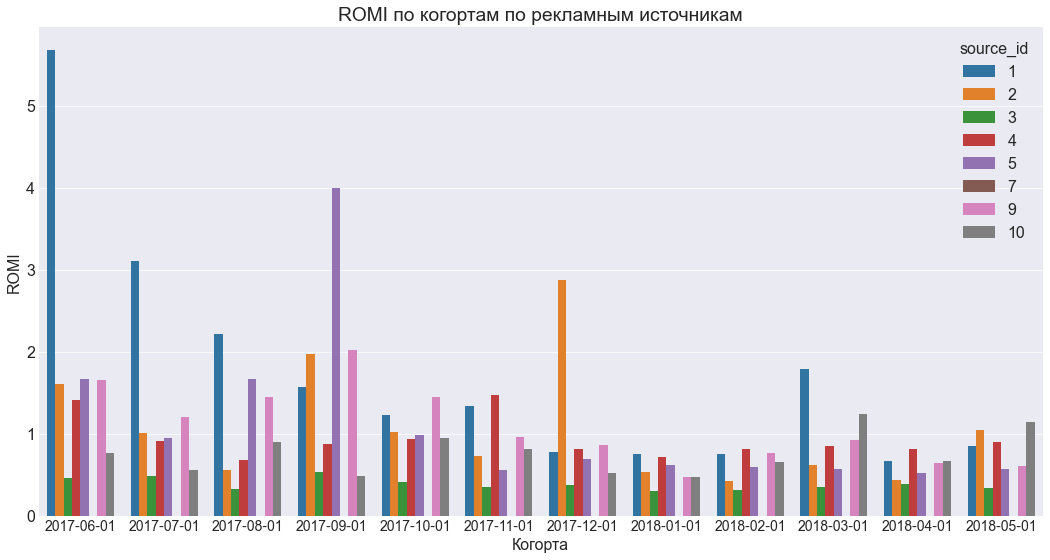

In [212]:
# посмотрим на ROMI по когортам по рекламным источникам
romi_cohorts_source = report_source_new.groupby(['source_id',
                                                 'first_order_month'])['romi']\
                                       .sum()\
                                       .reset_index()
fig, ax = plt.subplots()
plt.title('ROMI по когортам по рекламным источникам')    
ax = sns.barplot(x = 'first_order_month',
                 y = 'romi',
                 data = romi_cohorts_source,
                 hue = 'source_id')
ax.set_xticklabels(labels = romi_cohorts_source['first_order_month'].dt.strftime('%Y-%m-%d'),
                   fontsize = 14)
plt.xlabel('Когорта')
plt.ylabel('ROMI')
plt.show()

Для разных когорт среди рекламных источников разные "лидеры" по показателю возврата маркетинговых инвестиций ROMI. Самый "дорогой" рекламный источник - третий - до конца анализируемого периода не окупился ни у одной из когорт.

In [213]:
# посчитаем количество когорт с ROMI больше 1
romi_cohorts_source.query('romi >= 1')\
                   .groupby('source_id')['romi']\
                   .count()\
                   .sort_values(ascending = False)

source_id
1     7
2     6
9     5
5     3
10    2
4     2
Name: romi, dtype: int64

У семи из 12 когорт средний показатель возврата маркетинговых инвестиций ROMI выше единицы у покупателей из первого рекламного источника, у 6 - из второго, у 5 - из девятого.

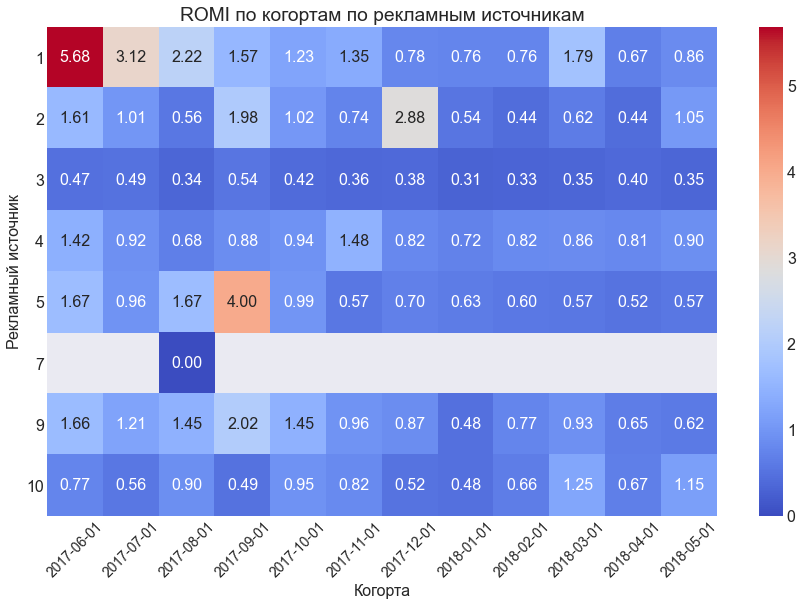

In [214]:
# создадим тепловую карту с показателем ROMI по рекламным источникам
romi_source_pivot = romi_cohorts_source.pivot_table(index = 'source_id',
                                                    columns = 'first_order_month',
                                                    values = 'romi')
plt.figure(figsize = (15, 9))
plt.title('ROMI по когортам по рекламным источникам')
ax = sns.heatmap(romi_source_pivot,
                 annot = True,
                 fmt = '.2f',
                 cmap = 'coolwarm',
                 linecolor = 'gray')
plt.xlabel('Когорта')
plt.ylabel('Рекламный источник')
ax.set_xticklabels(labels = romi_source_pivot.columns.date,
                   fontsize = 14,
                   rotation = 45)
ax.set_yticklabels(labels = romi_source_pivot.index,
                   rotation = 0)
plt.show()

Самый высокий средний показатель возврата маркетинговых инвестиций ROMI у когорты июня 2017 года первым источником (ROMI - 5,68) и сентября 2017 года пятым (ROMI - 4), самый низкий - у когорты января 2018 года третьим источником (0,31).

In [215]:
# посчитаем средний ROMI по всем покупателям по рекламным источникам
romi_mean_source = ltv_metrics_source.groupby('source_id')['avg_ltv'].first()\
    / cac_metrics_source.groupby('source_id')['avg_cac'].first()
romi_mean_source[7] = 0
d = {'avg_romi': romi_mean_source}
romi_metrics_source = pd.DataFrame(data = d)
romi_metrics_source = romi_metrics_source.reset_index()
romi_metrics_source

source_id  avg_romi
0          1      1.49
1          2      1.10
2          3      0.39
3          4      0.93
4          5      1.02
5          7      0.00
6          9      1.04
7         10      0.76

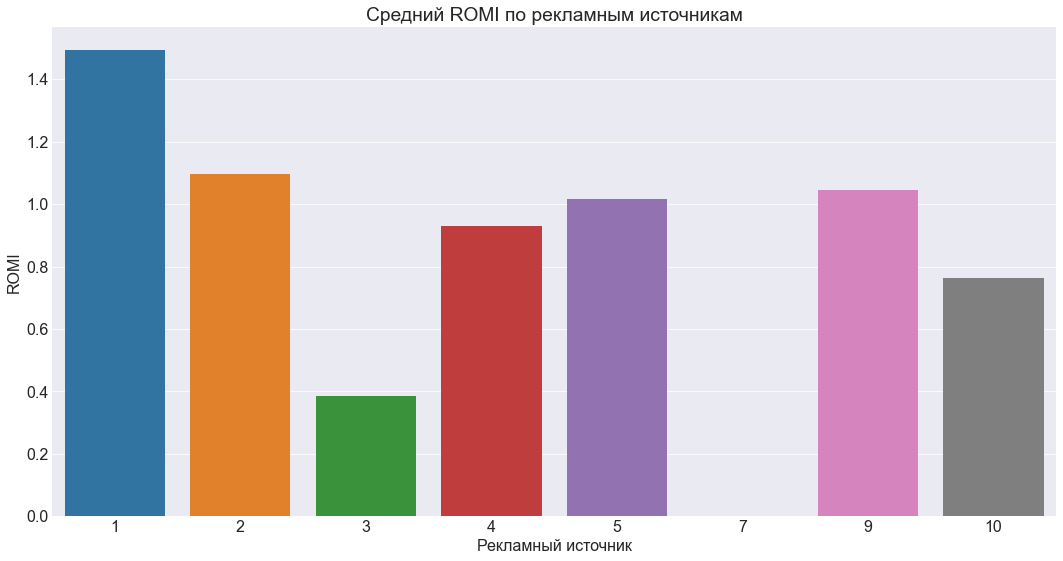

In [216]:
# посмотрим на средний ROMI по рекламным источникам
fig, ax = plt.subplots()
plt.title('Средний ROMI по рекламным источникам')    
ax = sns.barplot(x = 'source_id',
                 y = 'avg_romi',
                 data = romi_metrics_source)
plt.xlabel('Рекламный источник')
plt.ylabel('ROMI')
plt.show()

К концу анализируемого периода окупились 4 рекламных источника: первый (ROMI - 1,49), второй (ROMI - 1,1), девятый (ROMI - 1,04) и пятый (ROMI - 1,02). У самого затратного рекламного источника - третьего - показатель возврата маркетинговых инвестиций ROMI самый низкий - всего 0,39.

#### Вывод

In [217]:
# сведем в одну таблицу все рассчитанные маркетинговые метрики
marketing_metrics_all = pd.concat([costs_metrics_all,
                                   cac_metrics_all,
                                   romi_metrics_all],
                                  axis = 1)
marketing_metrics_all_tr = marketing_metrics_all.transpose()
marketing_metrics_all_tr

all
total_costs 329,131.62
avg_cac           9.01
avg_romi          0.77

In [218]:
# сведем в одну таблицу все рассчитанные маркетинговые метрики по рекламным источникам
marketing_metrics_source = costs_metrics_source.merge(cac_metrics_source, on = 'source_id')\
                                               .merge(romi_metrics_source, on = 'source_id')
marketing_metrics_source.set_index('source_id', inplace = True)
marketing_metrics_source_tr = marketing_metrics_source.transpose()
marketing_metrics_source_tr

source_id          1         2          3         4         5    7        9   \
total_costs 20,833.27 42,806.04 141,321.63 61,073.60 51,757.10 0.00 5,517.49   
avg_cac          7.19     12.21      13.49      5.93      7.47 0.00     5.07   
avg_romi         1.49      1.10       0.39      0.93      1.02 0.00     1.04   

source_id         10  
total_costs 5,822.49  
avg_cac         4.38  
avg_romi        0.76

###### Сколько денег потратили?    
<br>1. Всего на рекламу потратили 329 131,62 рубля. Больше всего было потрачено на третий рекламный источник (141 321,63 рубля - более чем в 2 раза, чем на какой-либо другой), меньше всего - на девятый (5,517,49 рубля) и десятый (5 822,49 рубля) рекламные источники. На седьмой рекламный источник, из которого пришел один покупатель, затраты не осуществлялись.    
<br>2. Динамика ежедневных расходов на рекламу имеет множество "всплесков", которые, вероятнее всего, говорят о проведении рекламных акций в эти дни. Динамика ежедневных расходов на рекламу очень похожа на динамику ежедневных заказов, что, вероятно, свидетельствует о наличии зависимости между этими показателями. Полученное значение коэффициента корреляции 0,79 подтвердило предположение об этой зависимости. По дням недели - самые высокие затраты на рекламу в четверг и пятницу, самые низкие - в выходные дни. Общие расходы на рекламу начали расти с сентября 2017 года, достигли своего максимума в декабре 2017 года, после чего начали снижаться. По всем источникам ежедневные затраты на рекламу крайне неравномерны. Декабрьский "всплеск" затрат на рекламу, вероятнее всего связанный с новогодними праздниками, достигнут исключительно благодаря третьему источнику.   
Ежемесячные расходы на рекламу по всем рекламным источникам, за исключением третьего, в анализируемом периоде производились достаточно равномерно. Динамика затрат на самый "дорогой" рекламный источник - третий - соответствует динамике общих затрат на рекламу по всем источникам.    
###### Сколько стоило привлечение одного покупателя из каждого источника?
<br>1. Самыми дорогими по стоимости привлечения оказались покупатели когорты августа 2017 года (CAC составил 10,8 рублей), января (CAC - 9,9 рублей) и апреля 2018 года (CAC - 9,8 рублей). Дешевле всего по стоимости привлечения оказались пользователи мая 2018 года (CAC - 7,4 рубля) и октября 2017 года (CAC - 8,4 рубля). Средний показатель CAC по всем покупателям составил 9,01 рубль. Во всех когортах наибольшая стоимость привлечения клиентов у второго и третьего рекламных источников, наименьшая у большинства когорт - у девятого и десятого источника. Самая высокая стоимость привлечения клиентов у когорты августа 2017 года третьим источником - 18,23 рубля, самая низкая - у когорты марта 2018 года десятым источником - 2,83 рубля. Самая высокая средняя стоимость привлечения покупателей у третьего рекламного источника - 13,49 рублей, чуть ниже у второго - 12,21 рубль. Самый низкий средний показатель CAC у десятого рекламного источника - 4,38 рубля.     
<br>2. Быстрее всего окупилась когорта сентября 2017 года, в которую входит один из двух наиболее ценных клиентов, - на 3 месяц. Самая "старая" когорта - июня 2017 года - окупилась на шестой месяц. Остальные когорты на момент окончания анализируемого периода не окупились. 
###### На сколько окупились расходы?    
<br>1. Средний показатель возврата маркетинговых инвестиций ROMI выше единицы только в двух когортах - сентября (ROMI составил 1,42) и июня 2017 года (ROMI - 1,33). Самый низкий показатель ROMI у покупателей, совершивших первый заказ в январе (ROMI - 0,5), феврале (ROMI - 0,51) и апреле 2018 года (ROMI - 0,53). В среднем, когорты окупаются к концу девятого - десятого месяца. 
Средний показатель ROMI по всем покупателям составил 0,77, т.е. по всей совокупности затраты не окупились. Для разных когорт среди рекламных источников разные "лидеры" по показателю возврата маркетинговых инвестиций. Самый "дорогой" рекламный источник - третий - до конца анализируемого периода не окупился ни у одной из когорт. У семи из 12 когорт средний показатель возврата маркетинговых инвестиций выше единицы у покупателей из первого рекламного источника, у 6 - из второго, у 5 - из девятого. Самый высокий средний показатель возврата маркетинговых инвестиций у когорты июня 2017 года первым источником (ROMI - 5,68) и сентября 2017 года пятым (ROMI - 4), самый низкий - у когорты января 2018 года третьим источником (0,31).   
<br>2. К концу анализируемого периода окупились 4 рекламных источника: первый (ROMI - 1,49), второй (ROMI - 1,1), девятый (ROMI - 1,04) и пятый (ROMI - 1,02). У самого затратного рекламного источника - третьего - показатель возврата маркетинговых инвестиций ROMI самый низкий - всего 0,39.

### Общий вывод
<a name="conclusion"></a>

#### Основные метрики

1. Количество уникальных пользователей: 
  - общее количество - 228168;  
  - в день (DAU) - 907; 
  - в неделю (WAU) - 5321; 
  - в месяц (MAU) - 23228. 
2. Sticky factor по отношению к:
  - недельной аудитории -16,15%;
  - месячной аудитории - 3,91%. 
3. Количество посещений сайта:
  - всего - 359399;
  - в день - 987;
  - в день на одного пользователя - 1,08.
4. Средняя продолжительность одного посещения (ASL) - 60 секунд.
5. Средний коэффициент удержания (Retention Rate) по первому месяцу "жизни" когорты - 6,52%.  
6. Среднее время между первым посещением и первой покупкой - 0 дней.
7. Количество покупок:
  - всего - 50414;
  - на одного покупателя - 1,38;
  - в день - 139;
  - в месяц - 4201.  
8. Количество покупателей - 36522.  
9. Общая выручка - 252053,78 рублей.
10. Средний чек от одной покупки - 5 рублей.  
11. Средняя выручка от одного покупателя (LTV):  
  - по нулевому месяцу "жизни" когорты - 4,92 рубля;  
  - всего - 6,9 рублей.
12. Общие расходы на рекламу - 329131,62 рублей.
13. Средняя стоимость привлечения одного покупателя (CAC) - 9,01 рубль.
14. Средний показатель возврата маркетинговых инвестиций (ROMI) - 0,77.

#### Категории устройств

Уникальных пользователей со стационарными устройствами более чем в 2,3 раза больше, чем с мобильными, в связи с чем у них выше и все показатели пользовательской активности. Показатели вовлечённости пользователей у посетителей сайта со стационарных устройств тоже выше, но незначительно. В свою очередь среднее количество сессий в день у пользователей со стационарными устройствами более чем в 2,7 раза больше, чем с мобильными, а среднее количство сессий в день на одного пользователя у них выше совсем незначительно - всего на 4%. Колебания количества сессий в день значительно выше при использовании стационарных устройств, кроме того, ни в один из дней не было превышения случаев использования мобильных устройств для посещения сайта по сравнению со стационарными. В динамике ежедневного количества сессий, приходящихся на одного пользователя, по категориям устройств наблюдаются более значительные колебания этого показателя у пользователей мобильных устройств, кроме того есть дни, когда количество сессий, приходящихся на одного пользователя, выше именно у посетителей сайта из мобильных устройств. Значения средней продолжительности сессии в разрезе категорий устройств равны. Средний коэффициент удержания Retention Rate по первому месяцу "жизни" когорты у пользователей со стационарными устройствами немного выше, чем у пользователей с мобильными. И покупатели со стационарными устройствами, и с мобильными в основном первые покупки совершают в первый день посещения сайта.  В то же время, пользователям мобильных устройств требуется больше времени, чтобы совершить покупку после первого посещения (для 75% пользователей устройств это период до 6 дней). Более 15% посещений сайта со стационарных устройств связано с осуществлением заказов, у пользователей мобильных устройств "холостых" посещений значительно больше (заказы осуществлялись менее, чем в 10% посещений).  У покупателей со стационарными устройствами показатели среднего количества заказов в день и месяц более чем в 4 раза выше, чем у покупателей с мобильными. Количество заказов в день со стационарных устройств подвержено большим колебаниям, чем с мобильных. Декабрьский "всплеск" количества заказов, вероятнее всего связанный с новогодними праздниками, был достигнут в основном за счет покупателей, использующих стационарные устройства. Количество заказов в месяц у пользователей стационарных устройств также подвержено большим колебаниям, тогда как количество заказов у пользователей мобильных устройств из месяца в месяц практически не меняется.  Общая выручка от покупателей со стационарными устройствами в 5 раз больше выручки от покупателей с мобильными устройствами. Средний и медианный чек, а также количество покупателей и среднее количество заказов на одного покупателя также выше у пользователей, приходящих на сайт со стационарных устройств. Средний чек пользователей, заходящих на сайт со стационарных устройств, выше, чем у использующих мобильные устройства, в основном за счет нескольких дней с весьма высокими значениями среднего чека. Только в ноябре 2017 года средний чек пользователей с мобильными устройствами был выше, чем у пользователей со стационарными устройствами. Средний чек декабря 2017 года у покупателей с разными устройствами находится на разных "полюсах". Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" у пользователей с мобильными устройствами в течение "жизни" когорт снижается медленнее, чем у пользователей со стационарными устройствами. Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты выше у пользователей со стационарными устройствами. Только у когорты покупателей марта 2018 года средняя выручка с одного покупателя выше у пользователей с мобильными устройствами. Средняя выручка с одного покупателя по категориям устройств значительно выше у покупателей со стационарными устройствами. 

#### Рекламные источники  

In [219]:
# проранжируем метрики по рекламным источникам
metrics_source = product_metrics_source.merge(trading_metrics_source,
                                              left_index = True,
                                              right_index = True)\
                                       .merge(marketing_metrics_source,
                                              left_index = True,
                                              right_index = True)
metrics_source = metrics_source.reset_index()
metrics_source = metrics_source.drop(index = 5)
metrics_source.set_index('source_id',
                         inplace = True)
metrics_source = metrics_source.transpose()
metrics_source_rank = metrics_source.rank(ascending = False,
                                          axis = 1)\
                                    .astype('int')
metrics_source_rank

source_id                     1   2   3   4   5   9   10
n_users                        5   4   2   1   3   6   7
dau                            5   4   2   1   3   6   7
wau                            5   4   2   1   3   6   7
mau                            5   4   2   1   3   6   7
sticky_factor_wau_pct          1   2   7   5   6   4   3
sticky_factor_mau_pct          1   2   7   5   6   4   3
avg_sessions_per_day           5   4   2   1   3   7   6
avg_sessions_per_user_day      1   2   6   4   3   7   5
asl_sec                        4   4   4   4   4   4   4
avg_retention_rate_first_pct   3   2   6   4   7   1   5
avg_order_session_days         4   4   4   4   4   4   4
n_visits                       5   4   2   1   3   6   7
n_orders                       5   4   1   2   3   6   7
ratio_orders_pct               3   5   2   6   4   7   1
orders_per_day                 5   4   1   2   3   6   6
orders_per_month               5   4   1   2   3   6   7
total_revenue                  5   4   2   1   3   6   7
avg_fee                        2   1   5   4   3   6   7
median_fee                     1   2   5   4   3   6   7
n_buyers                       5   4   1   2   3   7   6
orders_per_buyers              2   1   5   6   4   3   7
avg_ltv_null                   2   1   5   4   3   6   7
avg_ltv                        2   1   6   4   3   5   7
total_costs                    5   4   1   2   3   7   6
avg_cac                        4   2   1   5   3   6   7
avg_romi                       1   2   7   5   4   3   6

Наибольшее общее количество уникальных пользователей привлечено на сайт при помощи четвертого и третьего рекламных источников, соответственно у этих источников выше и все показатели пользовательской активности. Через шестой и седьмой рекламные источники пользователи практически не привлекались. Показатели вовлечённости аудитории выше у первого и второго рекламных источников. Среднее количество сессий в день наибольшее у пользователей из третьего и четвертого рекламных источников, однако показатели количества сессий в день на одного пользователя иные. Здесь наилучшие значения этого показателя у пользователей из первого источника. У третьего и четвертого рекламных источников, при помощи которых пользователи посещали сайт чаще, количество сессий в день на одного пользователя очень мала. Динамика количества сессий в день по рекламным источникам очень похожа, декабрьский "пик" при этом достигнут, в основном, благодаря пользователям, пришедшим из третьего и четвертого рекламных источников. Динамика количества сессий в день на одного пользователя по рекламным источникам подвержена более значительным колебаниям, при этом у первого рекламного источника имеется самое большое количество "всплесков" этого показателя. Значения средней продолжительности сессии в разрезе рекламных источников равны, за исключением шестого и седьмого рекламных источников, при помощи которых привлечено совсем небольшое количество пользователей. Из двух рекламных источников с наибольшим привлечением пользователей - третьего и четвертого - коэффициент удержания Retention Rate по первому месяцу "жизни" когорты у третьего источника очень низок. Более 15% пользователей, привлеченных с использованием девятого, второго и первого рекламных источников, возвращаются на сайт в первый месяц "жизни" когорты. Покупатели, пришедшие из всех рекламных источников, в основном первые покупки совершают в первый день посещения сайта. Среди рекламных источников самыми "медленными" являются пользователи, привлеченные на сайт при помощи девятого  источника (для 75% пользователей, пришедших из этого источника, требуется до 70 дней, чтобы совершить покупку после первого посещения). У пользователей, посетивших сайт при помощи первого, третьего и десятого рекламных источников, более 15% посещений сайта связано с осуществлением заказов, у седьмого источника лишь одно посещение из 36 привело к осуществлению заказа.  Самые высокие значения среднего количество заказов в день и месяц у покупателей, пришедших из третьего и четвертого рекламных источников. У самых популярных рекламных источников (третьего и четвертого) рост количества заказов начался с сентября 2017 года, до этого они практически не выделялись на фоне других источников. Декабрьский "всплеск" количества заказов, вероятнее всего связанный с новогодними праздниками, был обеспечен в основном именно этими источниками. Самая большая выручка от покупателей, привлеченных на сайт при помощи четвертого, третьего и пятого рекламных источников, однако самый высокий средний чек от пользователей, пришедших из второго рекламного источника. В то же время, у этого рекламного источника медианный чек не самый высокий из-за присутствия в группе одного из самых "ценных" покупателей. Наибольшее количество покупателей пришли с помощью третьего и четвертого рекламных источников, однако самые высокие показатели среднего количества заказов на одного покупателя у второго и первого рекламных источников. У пятого рекламного источника в один из дней декабря 2017 года есть очень высокое значение среднего чека, вероятнее всего связанное с разовой крупной покупкой. Наибольшее количество "пиковых" дней с высокими значениями среднего чека у второго рекламного источника. Средний чек в месяц практически по всем рекламным источникам из месяца в месяц меняется незначительно, за исключением пятого источника с большим значением среднего чека в декабре 2017 года, и второго источника с "всплеском" в феврале - марте 2018 года.  Средний показатель ценности клиента LTV без учета нулевого месяца "жизни" в течение "жизни" когорт растет только у покупателей, пришедших на сайт с помощью первого рекламного источника. Средний показатель ценности клиента LTV по нулевому месяцу "жизни" когорты самый высокий у покупателей, посетивших сайт при помощи второго и первого рекламных источников.  У разных когорт разные "лидеры" среди рекламных источников по уровню средней выручки с одного покупателя -  либо первый, либо второй рекламные источники. Средняя выручка с одного покупателя самая высокая от покупателей, пришедших из второго и первого рекламных источников, самая низкая - от покупателей, пришедших из десятого источника. Покупатели, пришедшие из второго рекламного источника, более половины выручки приносят после нулевого месяца "жизни" когорт. Больше всего было потрачено на третий рекламный источник (более чем в 2 раза, чем на какой-либо другой), меньше всего - на девятый и десятый рекламные источники. На седьмой рекламный источник, из которого пришел один покупатель, затраты не осуществлялись. Ежемесячные расходы на рекламу по всем рекламным источникам, за исключением третьего, в анализируемом периоде производились достаточно равномерно. Во всех когортах наибольшая стоимость привлечения клиентов у второго и третьего рекламных источников, наименьшая у большинства когорт - у девятого и десятого источника. Самая высокая стоимость привлечения клиентов у когорты августа 2017 года третьим источником, самая низкая - у когорты марта 2018 года десятым источником. Самая высокая средняя стоимость привлечения покупателей у третьего рекламного источника, чуть ниже у второго. Самый низкий средний показатель CAC у десятого рекламного источника. Для разных когорт среди рекламных источников разные "лидеры" по показателю возврата маркетинговых инвестиций. Самый "дорогой" рекламный источник - третий - до конца анализируемого периода не окупился ни у одной из когорт. У семи из 12 когорт средний показатель возврата маркетинговых инвестиций выше единицы у покупателей из первого рекламного источника, у 6 - из второго, у 5 - из девятого. Самый высокий средний показатель возврата маркетинговых инвестиций у когорты июня 2017 года первым источником и сентября 2017 года пятым, самый низкий - у когорты января 2018 года третьим источником. К концу анализируемого периода окупились 4 рекламных источника: первый (ROMI - 1,49), второй (ROMI - 1,1), девятый (ROMI - 1,04) и пятый (ROMI - 1,02). У самого затратного рекламного источника - третьего - показатель возврата маркетинговых инвестиций ROMI самый низкий - всего 0,39.    

### Рекомендации
<a name="recommendations"></a>

1. Наиболее эффективным рекламным источником является первый - у него самый высокий средний показатель возврата маркетинговых инвестиций. У этого источника наибольший показатель вовлечённости аудитории и среднего количества сессий в день. Этот рекламный источник будучи на 4 месте по средним затратам на одного покупателя, по средней выручке от одного покупателя - на 2 месте. В то же время показатели пользовательской активности у этого рекламного источника невысоки (5 место из 7), что свидетельствует о недостаточной распространенности данного источника.  
2. Очень хорошие показатели у второго рекламного источника. У него самые высокие значения средней выручки от одного покупателя и среднего чека. Кроме того у клиентов из этого источника наибольший показатель количества покупок на одного покупателя. Показатели пользовательской активности у второго источника немного лучше, чем у первого. В то же время у второго источника высокие затраты - 2 место по средним затратам на одного покупателя, кроме того показатели этого рекламного источника достаточно сильно зависят от одного из наиболее "ценных" клиентов.   
3. Показатель возврата маркетинговых инвестиций выше 1 еще у девятого и пятого рекламных источников. На девятый источник было осуществлено меньше всего затрат, но и показатели общей выручки у этого рекламного источника крайне невысоки. Кроме того, распространенность девятого источника очень низка. У пятого рекламного источника, в свою очередь, самые высокие показатели пользовательской активности из всех перечисленных источников, по общей выручке он на 3 месте, но у этого источника очень высоки затраты (тоже 3 место).  
4. Источники, которые принесли наибольшую выручку и которые являются самыми популярными, - третий и четвертый - очень затратны, особенно третий. Вследствие этого у третьего источника самый низкий показатель возврата маркетинговых инвестиций - всего 0,39.  По возможности следует рассмотреть сокращение затрат на эти рекламные источники.   
5. Десятый  и седьмой рекламный источник предлагается исключить из применения. У десятого источника самые низкие показатели пользовательской активности и среднего чека. Кроме того при больших по сравнению с 9 источником затратах, выручка от него значительно ниже. На седьмой источник, в свою очередь, хоть затраты и не осуществлялись, но им был привлечен всего один покупатель.  
6. При разработке маркетинговой стратегии следует принять во внимание, что в большинстве случаев пользователи склонны моментально совершать покупки, поэтому необходимо в первую очередь привлекать клиентов.
7. Необходимо не допускать технических неполадок в работе сайта, так как это может привести к потере большого числа пользователей и потенциальных покупателей.  
8. Строить рекламную кампанию необходимо, учитывая что большинство пользователей используют стационарные устройства.  
9. Следует проверить удобство совершения покупки с мобильных устройств. 